In [1]:
import sys
sys.path.append('../../')

import torch
import pytorch_lightning as p
import numpy as np
import pandas as pd

from syndatagenerators.models.wgan.wgan_baseline_model import BaselineWGAN, Generator, Critic
from syndatagenerators.models.utils.plot_functions import plot_sample_grid
from syndatagenerators.data_preparation.datasets import PowerDataModule 

from syndatagenerators.metrics.mmd_score import mmd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

### Load trained model

In [3]:
!ls -hl /share/data1/bschaefermeier/chkpt/wgan/wpuq/

total 980K
-rw-r--r--  1 bschaefermeier bschaefermeier 975K Jul  6 13:36 BaselineWGAN_1-v1.ckpt
drwxr-xr-x 13 bschaefermeier bschaefermeier 4.0K Jul  6 09:45 lightning_logs


In [4]:
! ls -hl /share/data1/bschaefermeier/chkpt/wgan/openmeter

total 2.0M
-rw-r--r-- 1 bschaefermeier bschaefermeier 975K Jul 13 13:02 BaselineWGAN_1.ckpt
-rw-r--r-- 1 bschaefermeier bschaefermeier 975K Jul 13 16:55 BaselineWGAN_1-v2.ckpt
drwxr-xr-x 5 bschaefermeier bschaefermeier   70 Jul 13 14:10 lightning_logs


In [5]:
!ls -hl /share/data1/bschaefermeier/chkpt/wgan/openmeter2122

total 1.3M
-rw-r--r-- 1 bschaefermeier bschaefermeier 1.3M Jul 22 17:50 BaselineWGAN_1-v1.ckpt
drwxr-xr-x 3 bschaefermeier bschaefermeier   30 Jul 21 16:35 lightning_logs


In [7]:
!ls ~/data1/chkpt/wgan/

1			       openmeter
BaselineWGAN_1.ckpt	       openmeter2122
BaselineWGAN_1-v1-backup.ckpt  openmeter2122_kernelsize3
BaselineWGAN_1-v1.ckpt	       wpuq
BaselineWGAN_1-v2.ckpt	       wpuq2
finetune


In [2]:
def load_checkpoint(path):
    model = BaselineWGAN.load_from_checkpoint(path)
    model.eval()
    return model

chkpt = '~/data1/chkpt/wgan/wpuq2/BaselineWGAN_1-v1.ckpt'
chkpt = '~/data1/chkpt/wgan/openmeter/BaselineWGAN_1-v2.ckpt'
chkpt = '~/data1/chkpt/wgan/openmeter2122/BaselineWGAN_1-v1.ckpt'
#chkpt = '~/data1/chkpt/wgan/openmeter2122_kernelsize3/BaselineWGAN_1-v3.ckpt'
model = load_checkpoint(chkpt)

### Generate samples

In [6]:
def generate_synthetic_samples(generator, size: int = 5000,
                               clip: bool = True):
    generator.eval()
    z = torch.randn(size, generator.latent_dim).float()
    x_gen = generator(z).detach()
    x_gen = generator(z).detach()

    if clip:
        x_gen = torch.clamp(x_gen, 0, 1)
    return x_gen

In [7]:
def reshape(x):
    return x.reshape((x.shape[0], x.shape[-1]))

In [8]:
xgen = generate_synthetic_samples(model.generator, size=366*60, clip=False)
xgen.shape
xgen_ = reshape(xgen)

In [6]:
series = xtrain.reshape(-1)
ids = np.array([96*[i] for i in range(xtrain.shape[0])]).reshape(-1)
timepoints = np.array([list(range(96)) for _ in range(xtrain.shape[0])]).reshape(-1)
assert series.shape == ids.shape == timepoints.shape
dfreal = pd.DataFrame({"series": series, "id": ids, "timepoint" : timepoints})
dfreal

NameError: name 'xtrain' is not defined

In [18]:
series = xgen_.numpy().reshape(-1)
ids = np.array([96*[i] for i in range(xgen_.shape[0])]).reshape(-1)
timepoints = np.array([list(range(96)) for _ in range(xgen_.shape[0])]).reshape(-1)
assert series.shape == ids.shape == timepoints.shape

In [19]:
df = pd.DataFrame({"series": series, "id": ids, "timepoint" : timepoints})
df

,series,id,timepoint
0,0.008376,0,0
1,0.008736,0,1
2,0.007037,0,2
3,0.006594,0,3
4,0.008125,0,4
...,...,...,...
2108155,0.007968,21959,91
2108156,0.006399,21959,92
2108157,0.006351,21959,93
2108158,0.008630,21959,94


In [10]:
sns.__version__

'0.12.2'

In [18]:
# Load openmeter data

In [71]:
start_date = '2020-01-01 00:00:00+01'
split_date = '2020-12-29 00:00:00'
end_date   = '2020-12-31 00:00:00+01'
pdm = PowerDataModule(dataset="wpuq", start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm.setup()

In [10]:
start_date = '2020-01-01 00:00:00+01'
split_date = '2020-12-29 00:00:00'
end_date   = '2020-12-31 00:00:00+01'
pdm = PowerDataModule(dataset="openmeter", start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm.setup()

In [29]:
# Reload OpenMeter but only the households which will be used for training (Privat, removing one outlier household with extremely high power consumption)
households_to_use_list = ['22d3fd2c-a23d-4620-899a-1faee6da511c', '28769f0b-7601-4e5e-823f-97f8ef469910', 'e016926c-fa5c-49a7-a715-6b30d4aab4ed', '18025781-5a6c-4489-a850-7ba0f76eaadc', '8a579476-1069-4087-9ac2-12f728a6cc66', 'e58f2df6-778c-44d8-9c51-1deb5afd99a5', '6b253309-89b7-4282-a2f6-337284356dab', '5c8fbb63-735e-44ec-8f2f-0e0d99aadbfd', '2ed46eeb-bb38-4bd4-b16b-85db6f9f4267', 'cce1b7bc-4290-4312-8534-db7bc2b23a8f', '24595c1e-dd40-4c2e-b2d0-f8499ea7bd7b', '376c1716-47cd-4972-ad72-5ff9bd0e96c1', '8fabd8cb-1261-464b-a0c7-84b948bba530', 'b68504d5-b0d7-44af-a129-745dcc7f4345', 'fa90c793-cba7-4cb7-baad-3b0d8358fa87', '2241a124-0e4c-4b18-abb0-0e31108c543b', 'b06afddc-157f-4acb-a3c0-dabd217e47a9', '7558ee98-7e2c-443c-90af-fc0e7e247ef5', 'cec3d5cc-0548-43b4-9d62-772cae2f6034', '7aaf6ed0-00d8-447b-80ea-ddab8849f36c', 'c6f7ab70-0be6-4531-a65c-1d18e57a9aad', 'b2014e5b-0fce-4bf7-9088-36474df74662', 'b1a70e4d-45a4-449a-8f67-e66c21f12d85', 'd3f8e8c4-32ec-4035-a9b5-ba8c945caa4b', '6b0845f1-fbf6-40fb-9a69-9d104cfa75c6', '248f76e2-0154-466c-a85a-3a3fc22c43fa', '2d873d88-54d9-4a10-92ee-a716cae15a0f', '6e77f347-726a-4b41-a259-c9b55ae723eb', '496f1d46-1cf9-4c2a-96cd-2dc69c66d13a', '6f7d1d04-49af-456b-8f6f-1edf0f8a65f9', 'baacb198-9a92-4826-b1f2-13bb4f922f78', 'b65b40a8-489a-4266-9320-e96d85dd44e0', 'da91589e-a16e-4235-9778-f91d0182a857', '33d8f854-cd3f-41aa-bc22-b6a66a034dd8', '77926d4b-10eb-4e64-8ee4-6458cede1882', '286087f2-254e-430f-950d-b13f92346b7d', '44a6a6ba-5fa6-489d-9c61-139f59788c4c', 'd772f57f-1333-4be7-b43a-200c7dd22b8b', '7205a5fd-6307-493e-bf23-892f3eb3633a', '76ee0e6a-d86e-44a5-bc35-7cb81dc30c82', '52832fa5-6515-4188-950a-8f3d65eebce2', 'c0fcf7f2-f21b-4bdb-8b80-c809a263d7cd', '8e07b268-b0e8-4fc4-b02b-4badd5571957', 'efcf63db-735e-4339-98a2-8c9960c928dc', 'b5605a1a-3ed4-4759-8f3b-ec0164f15747', '347dc5f0-fcc8-4631-bbbf-49dc5e1a7955', 'fd440cb5-d81e-40ee-9819-8395a61c3a35', '9ce5483b-a1fc-41ef-8016-e87847613f44', 'd068fe37-f8a8-4e33-a5c1-c046f96a8af4', '504486d3-8316-47ae-82db-bc31e28e12ba', '0252a8f5-9913-47bb-a70f-c86e5c69f71a', '126327a9-1748-498c-a52d-d333b3879074', '1f2d6239-4aa7-48de-a41b-730399e0d405', '3b42328b-52e3-4027-83b6-13b938c7c2ed', '401ba297-e962-4e75-97c9-7f7f20fb48ca', 'f8e1b12a-268d-4021-8140-0375d4d936be', '0247a559-2660-4434-b204-d8f7ef9da4d4', '8060e043-c622-48b8-a963-ba7fbd4b1e52', '23937e19-e689-4ddc-99dd-bdbed63f3eb7', 'f4ae88f2-4183-4f39-86ff-0b3bfa44211b', 'e0a16fc2-dd90-4015-af33-c1378508f9ed', '6f4ad391-b95c-4ac7-b59f-371c947bcdb5', 'c95842e3-1125-4ad9-9940-0f132773469b', 'f3c1bd43-0076-4c08-9f16-b86200328a52', '1fafc377-6171-4b57-affd-f4cb989c1792', 'a14e7cba-cb2c-4154-9a5c-72b0cb5fb479', '2dc461e9-3a9e-4860-975b-6c88d5204b48', 'ad594dbc-f077-4fd2-9dcd-42b3cbcd2192', '7f18dee7-69f5-4075-8ac3-e530188e3739', 'e83fd0c9-1fc4-4395-b144-36232430bc31', '0520f1fd-30d5-4ffe-8c57-35c36615586c', '718d8e77-f83f-4856-840d-8df0a3d09da8', '946e85d5-1700-4de4-aa43-80d72defebfe', '271a4536-185e-46b1-a407-a37ca78b7dae', '1666d51f-e1b0-4825-9acf-3b312f032483', '54bb3ccc-d1e2-4246-91bb-c2ec61bfe2eb', '9468ecb1-45d4-498d-bcca-e04f27b1dcea', '5de58362-7ebb-40b1-9335-60562b2cdcbb', 'ce281f72-1cb7-4db1-99cc-9c196a7f4e00', 'cecfe8bb-c817-46d2-aa27-008174fe3128', '001dce72-b1c1-44b1-bf16-0c22cfe3a420', 'ddad5aec-cf51-4321-a649-3fa209c1498c', '9ce00f15-6d49-4010-a16a-9416cc542031', '87211969-c89f-4207-8f8e-60c9086dbc7f', '51995fa8-aff1-4efb-a366-bd2e60c2ac18', '6fafd6fb-e139-44f8-9f63-960f607221ca', '50cbb5c5-aba9-434f-8519-7535a7b735ab', '555a243d-7c29-454a-8374-d8e55c1e80d3', '79c4b2a4-8184-48e0-b36e-24146f28e12e', '39627f86-c458-4d90-a520-2f003529f93c', '51b02e2a-3702-4f33-8f8c-cbd06cf79050', 'a49ef75f-c934-447f-bd23-559a6a799a6c', 'e8d5afeb-1ea9-4121-b14f-48f939624c7e', 'a2ab14fc-b563-4e70-bbfe-d64cc9cdade9', '0358067f-cd41-4d91-ba9e-91405fbfc704', 'c21da8e5-e1fa-4b47-9d85-5abd92b48676', '19636f91-d044-4bc4-8cab-d9fae1bd07c0', '7cf6335e-2892-4057-83be-294074cf605b', '904cdf3f-e79b-4b80-8531-79f6343eb70e', '9510637f-edd1-4362-b77a-5e5af2afbd40', 'e8169711-d925-4032-8b84-ab2cebb1bd8c', '220ea888-da70-483a-8e85-ea169bb96638', '30dc5b53-e184-405a-bb21-43a60c7344fb', '4fc5c9de-ad94-4c52-b1b3-329cf6a3f5cc', '0987b42a-c841-4454-90ac-69e5b1054cd5', '6028b036-d45e-4271-b5be-3b2a825f61bb', '66f02100-c3ec-4480-9fba-1b3260129cd6', '96593fda-33be-4d8f-88f7-9a5fc6b8b888', '12aedcfd-33cd-47ac-b495-81c13e0c3039', '0de28587-2941-47f6-9555-b4456ab5ae9c', '6402f9bb-b2ac-47d2-b944-75945fa856e4', '9415ae40-f716-4e78-88b9-51b17fe8acc9', 'baceccf6-99c2-4782-b9d1-691b90968879', '787941a4-d4bf-47bc-8bfc-dd750fe651f3', '9514b930-b41a-4990-8b6d-c0ac4e0b0d67', 'e3a17831-e2af-4002-83a1-57c2aa51f190', '94526bac-11c0-4854-8475-25afcc35dcbd', 'c43336bd-9e0c-46e7-9b27-c712d8ba0a14', '13f73a8c-8876-4d5d-aa85-c7c44c0a960d', '6c2c5ed1-5c20-49c9-9587-0acf85a4ea55', '2f82df5e-78d4-4616-9ab9-5ba69dddabb3', 'da54df98-ffa4-4b1d-9552-40bc0164da8b', '1cc862fc-6e3a-4454-92ac-0649984a9b72', '65a9f0d9-35f1-4fe8-a447-e6f533e9368c', 'c7fd6823-b724-4a5f-9c96-0d9e30133ed4', 'c31919ec-7b31-41f7-a881-8760656f5a78', 'f34846ac-1d2a-457b-ad84-660e7c76fa5d', 'c828b042-f102-4186-b543-ff52fe146342', '6c926838-cd1f-4d5e-a50f-e8ff3f53510d', '8018bb28-1612-461b-afb2-649af8f29a98', '90063fab-7535-459a-b4da-789124247aaf', 'f08a52b7-119f-4797-a306-078abf8f3426', '1714f630-6922-4bfa-84cf-07b61aa076ba', '44d22209-778b-4244-ad0b-f7eecf5d339c', '729c42e9-5169-45ad-a693-58e30038281a', 'de0931c5-afb9-4e52-a745-48dcbc11308f', '7c5ed116-c213-4a50-b330-4d3328ed3e95', '65e70984-7b9d-4e2c-a324-aef5460b202e', 'fe352710-860f-4686-ad4e-e187e99c7256', '9dd60a04-82ff-4979-933b-3f765fdebee3', '5fa47966-1bb1-4f1d-8df1-c31ced754b63', 'bd00a4b7-d6a3-4310-8173-f16e868e96c2', '31bfee98-6de8-4a2b-8896-daf7069f0827', 'c4040dbd-7657-451b-af8a-7e2d35a20982', '6205b6cc-e9ae-4065-8b74-7e0e52e42b49', 'f430e0e4-5cc1-4f40-a5bd-9af423c06677', 'e2304ab3-913c-437e-b363-415361651bb5', 'd4c9f05d-57e0-41b9-b1de-c98942d0c9c8', '9ab2ac51-6547-4a2a-a1ac-02ac4c99883b', 'bca24757-0acc-42fb-a531-a14655da6bd0', 'bd184654-3a4b-4609-b41d-b3b5e55bb1c6', 'e472f992-aad5-4fea-8fa0-e26b6591a323', '4225ef3a-8c23-44a6-a38b-892171d3adcb', 'ef2e3567-bcad-4c28-ac21-9bcbaaf4c385', 'e8eec69f-4ea6-44bc-9ffc-b434575ca38a', '75106228-f23e-4f7b-a3da-9456bb35ea93', '721b47b2-d5cc-411d-80ea-56a2f857acaf', '04b1dc78-587d-4837-978e-ac288a2b480c', 'ccca55e4-25e2-4f2e-a48b-6ca1ec31d96e', 'cd2807e1-0085-4fc6-adfc-6367995d7c34', '3a06e019-2b14-4ed6-9d37-0031640b80a5', '1178737b-13d0-4f18-be37-485975448f37', '319cebc4-74f3-4f4b-b52c-9f6b707a28b3', '9f5a00c2-f4ff-426c-bb2e-921c2bbd21c6', '689006b1-50c6-451a-9e53-89b245dee080', 'b226ba15-8433-4d9d-a3fd-9161439a1b4d', '54e347ca-e41d-427d-ae60-b86443802881', 'e44b6322-1e88-483f-90d3-7e32519b769f', '305f98a7-94fa-413f-a490-1a471d17f547', '8c119331-71a1-4ef2-a5fe-6122e240adef', '9ea84709-259f-4f37-99ee-b8d774894925', 'c24d301f-6475-40e3-b291-43d9cfd88134', '17497f18-6482-4b24-a6d2-02f909d66a37', '21253f10-b379-4846-8891-744b9bad9778', '8cd8c86c-df1c-45b7-85b1-6337d7dcac89', '8aaaad56-171e-4b04-9c6f-5e243d6f3507', '75504b66-0cb8-4235-97f1-6c1591a61260', '84722250-7b20-4b27-b112-db08af7854f6', '5df5fe62-598d-4b46-bb40-ffe9e169d4c4', 'b9d7c4d8-2f13-4f6c-80ca-bbbc9cbd550d', '6b5714fb-56e8-4f68-b05c-b44b8ae7044d', 'bba43084-3a42-4ee1-a261-92b353b24c0a', 'b9bb01f1-e80f-4473-ab13-2455a2eb7ff5', 'fd53424d-2cfa-4a08-8010-98a2b1aec35f', '720a7976-86b1-4a51-95fc-1cb9ba92849d', 'e360e958-e0ce-4c2f-94e2-01e31d151b32', '6a9cb54f-0257-4e2d-9055-1216c51d7a2d', 'cc9122c8-ebdc-4238-a5c3-ec90df8d91bd', '67d6ef4b-f11c-4077-b71e-a3dbb5e91623', 'e7d993b3-fb7d-4fde-bec1-53ac74f24904', '848c4714-27c2-4064-9de8-7a88d60360bc', '0320fee3-66fb-4f70-b139-ff45d4e03a17', '33b6957c-d968-4397-bec1-4ead226b5f68', '63d87914-8afd-4856-90cd-2d00f5d36b4c', 'a5da17fc-3765-4e65-927a-53e54dd2454a', 'a84c293c-80e3-4578-8194-e6eaa290c382', 'b4284ee5-5873-46e8-9593-4c916feaaa34', 'bbf974de-6a5e-4fe9-9873-c54ca3bba75c', '7856246d-8cbf-4bae-bcba-9a734a0637e6', '73f215ea-73cb-41d6-89a7-e2a3eb9b6c16', 'ae540ff8-5f24-48f3-9677-9cc928b6f6c2', '5b8a2d23-6c49-4516-9712-9960c9df651e', 'ef67f92e-0be2-4f7b-9aa0-094149b1e1e4', '37d2353e-8bae-41d2-863e-86adbb8aad5e', '536162d0-a901-4243-947f-bf2dcbef0532', 'bacabe66-e63d-4dee-b350-a85d801c07d7', 'c03cbd32-1df6-4655-b73a-4753ef06fb83', 'e52e65cb-75e9-485d-b294-6fd41c393caf', '03b8c76b-aee3-473e-8f25-c21cea1e0ba6', 'e3eebde2-a143-4434-8a64-061dcab77a54', '4337ad00-30a3-47d9-8f6f-2e7ff6086801', 'fb0d081f-ec23-4e37-aff4-b595e7789b22', '7d50541d-1d50-4ded-8bb4-56c4f2a08ed5', 'f6a5371f-93e9-41f3-81cd-9546ed94055e', '912df36e-fd7c-49bf-a072-40b9b52294d2', '5af6d974-de89-4823-b226-c52cf1104b45', 'fb66b0f7-16cf-4bdc-8099-745f2c6e39e4', 'e060e605-4eda-4cb3-8d72-dd969b94ca5b', '81dc89ea-e932-4e5e-b232-f62f396042eb', '82b052bd-81c7-409e-85a6-a161507cdcaf', 'df64235a-9b4c-4543-a1bf-73bd3e4d8d53', '4241346f-2e6d-4db1-86c2-bf90d8a6af4e', '3f9eccea-aa85-4987-9fa4-ccdc85e92b9e', '60b63962-cc0e-4cea-adcd-6c0308c2cb1c', 'eaa7b605-c2fa-4ff9-9125-3024969db714', '90b04679-6db2-43f3-896c-00049a5eb66d', 'e4628967-a156-4b91-9e2a-593655660359', 'cfa5cfad-50e7-4626-a027-f1b2b1578ea4', 'a9fe09cc-de85-45f9-aa65-077d49a586d2', '8300e048-0fce-4a39-8ac5-e990b22ad9f8', '685740db-827e-4eb5-bd08-5bc8ae905a38', '95f2ef9c-10cb-43fd-a239-d6fe1e4094f3', '96331270-24b9-4577-b509-86187aad3bee', '13afec5f-dd17-4bc5-a544-194ab20575ca', '9be36162-73f3-4981-96fb-cd9e5779784b', 'f6e7f7cd-489a-4536-b48c-a3168df64a1b', 'c24d4d9e-cbbc-4815-8f81-d95911a90f44', 'e06e7a66-c777-4eb9-832f-cb104b34fe25', '8fd50bcc-e036-41ac-ba7b-d9aa870d4f6d', '352f4c93-d38c-4109-a961-03f4db879ec3', 'de068292-41dc-482d-9fd8-92688a7abbb9', '82cec8ed-719f-4352-9b78-ba1ae69560ed', '2ceed31d-5c71-46c8-ba1b-e93a787d683f', '4cbfbd27-821f-4105-bcc9-2c8d62d205c6', '51391be0-c021-471f-8c0a-14a36c8488ad', '12c77d0d-c6a0-4fc8-ae44-022c11e38aa3', 'dbe8794f-2aea-4af7-939c-6dc2cca2e793', '7a906aaf-2609-43d8-bcf5-2c4d73d1d822', 'ce785826-7e58-4582-9b45-048efbe48857', 'c3252268-497a-44ea-b37f-7576de1d8894', 'e866d8ad-8042-499d-aee5-7c5ec420d964', '9b7f9468-a636-4a27-995f-4ab6a18125cd', 'f8964cf8-7f5f-4c4c-b65e-4f1a889ad00c', '5a8082d8-3166-41bd-844b-bfce41bbcd13', '913c7123-048d-44cf-924e-d8e77eb7eaf9', 'c01e315e-6642-417e-9563-357e5d682bc7', 'c4329fb3-632f-4dad-94f6-176e4ea0c7ec', 'c7155c71-4c97-4031-92fc-9e7872fb2f3e', '18ba6fc3-d380-4243-bbef-857c3de97e31', '0d1df061-d516-455b-9194-4b515a2a94af', '7401b884-9ebe-4b11-ad95-9ea729752f49', '476ebd3c-f503-4ff6-9525-7ceddb52010f', '5d303fea-0cbf-4fe4-a638-26644acbdcc4', '367621ef-7d7b-43eb-ba1f-988e90b4fbed', 'ccce5a09-d6a9-428d-af89-41d43d9eb753', 'b9a2746d-9183-4126-a3f8-88df2480784d', 'f872917d-dbbc-4b88-bbf9-ef412a91decc', 'da798658-93b2-4247-8b23-66ef0eb46bb6', '340d6050-bd32-474e-94ed-33b7bf4c1df3', '5a5ae6dd-24bb-46e8-8971-a581b6f8975e', 'ad68fc76-36bb-4318-9b7a-ca1eb7843370', '32cb5e56-6f0b-4e70-be36-db410c823620', '41e334b9-b076-47de-ac59-fb4270b06dd3', '8504cd6e-4113-441a-81e7-14dbcf239a50', '72d8a014-3432-48e7-b086-ddaa8b0e2e74', 'bd1e8fb4-6433-4a03-80ad-1c42db9240ed', '0ab2b2e6-1a39-46c5-bc67-0a635875e03b', 'ec55484f-d199-4c01-b45e-218424e32894', 'd8d942fe-e6bb-42cb-96ca-a6c9e37d148e', '41a4575e-db00-4ed4-b77d-df2d628f46c1', 'e5a00a12-9321-41ea-bbc5-4665578ec279', 'bc83dddd-68dc-41d8-8e73-acd7c05bba8c', 'c2d07729-1c8f-4859-aece-965790c914b6', '04b810f1-7117-4dd3-8fc1-1845877daf63', '9742cee9-4f6c-4f14-b9b5-7bdd3985f17c', '6f6730f9-83d4-45eb-bd1c-1df7dea9b78e', '1885cf63-5f31-45b9-94ab-f7f7815d3bed', '6154d275-3bb6-4d5c-9c18-a6e0672c8777', '9b5517ba-c9ad-45f7-a5b6-b0c468a04117', 'd7247ebb-4331-4474-968a-8b2ef1054394', '65284aad-1703-4842-82d7-0d455db8e613', '49ed3643-d884-4644-8669-5791e50711f2', 'd31632fc-6e04-4b1b-a450-d24076fb23ff', 'd37837d5-c260-432b-8469-2e93b809b68c', '7ffa2647-e30f-4be6-ae08-8b60f1f3f422', 'd50abaef-dff0-4bbd-b2c7-34a7a400ab37', 'cf93a4ef-eabe-44ee-9b1f-6783b84076d4', 'd0e94030-b874-4b54-806c-2fc1bddb48aa', 'ba76c95d-a7dd-40ef-9d99-34fab373a26d', 'a3400766-e86e-4a08-bd86-e832bdc27daa', 'e6a547e8-50b3-4465-bce4-bc300a108b04', '151d956a-53ee-480c-91a6-2aa5afcce049', 'fb0edc78-41d5-4af5-ac57-d8ac69e71600', '5dbfe71d-dd31-4b76-bef6-82e05b9c6077', '6cbe26d6-43bd-42c6-a440-57a0f4b81dab', '1f03795f-faf0-4d0e-8434-7eda17f639db', 'c8abb2cd-1b2b-4904-90f6-8715831f4414', 'cdf7f73c-94b9-4bd7-ac83-95a717a6226c', '09f9a8ca-f346-4c9e-9ce6-8e7725bae5b3', 'd037820c-304f-48d9-b29c-49f612501aae', '732d3985-e43d-4e56-a623-25249370a69d', '83a60410-51a3-43a8-a79e-e0324a94b766', 'f442db46-ac45-4067-9d2d-635d6b57f4f4', 'fa05d21a-c315-443a-84b4-c96006bbb8f7', '9081bf52-436e-4560-a8af-e0fab319dd06', 'af1bbe13-62fa-48f6-b254-d3b84fb12cba', 'be6347df-6de6-4437-9f63-92e2723b7625', 'f1f5762d-5201-4521-af27-6103c774f091', 'aee6dc17-0672-4a22-ab3d-a99598254e86', 'b3a75204-d619-402d-8ba4-84c7c703ca67', 'df1f7a47-4dc3-427b-b992-e6856306fd59', '037d3c0e-2c33-4705-a6a4-778ce0858c85', 'fdc9f3b1-aabf-4a4a-8f12-1db945883b48', '44b34988-891c-4d54-959a-37195bf260aa', '8fbd2e66-e864-4b31-b522-0695b09cd6b6', 'f6ad84a3-2cdc-4ed4-b230-45dce5c718b2', '8f5c5a24-5cb0-481d-a5f2-38fd331eaa62', '6e70641f-9b9c-4060-9193-bb9f125ca882', '0cc0fcd7-ba31-4b36-abd6-a59b9700918c', 'bf22b603-ef1e-4259-ba74-14db33e0337c', '80196b3e-ebc5-4d4d-9c63-a71b5a40ee68', 'b4fcc832-67b7-4edd-b565-034baa835e01', '38478ba8-ecec-46c4-9212-212eca5133a1', 'ea69ce00-03ad-4280-ba0e-6fd6c60898fa', '175a1ef7-2f94-453d-8713-d9f1912dd027', '06d1421b-265b-4a13-a39f-6df00dbf92a6', 'bceda8de-d598-4a15-ad58-bdc7c6e24bf5', '4b838d22-262d-481e-922b-b544c050a7ff', '5a6fd236-ab3e-4447-88b3-73307558d024', 'ef04658c-1b31-440b-938a-f1fb7c30829e', 'e95ad8c8-511a-495c-92ec-3da14872d9a4', '7035ee06-3fe9-472e-ac47-fe8348bf0b98', '681027e8-876a-4135-bbea-574f62d9b86a', '86e1b6fb-80c5-470f-80f1-2d805ba78522', '158d63a8-d682-4619-a5fa-d4b444beb144', 'e9ebfb7c-3f73-42ae-a9b6-213408505a3f', 'fb191ad9-ee1a-43f7-8045-036158ca45fc', '28274691-20c8-4d90-9b14-5ebf7671d78e', '646f5434-3166-476f-a195-ee4f895b27fe', '7ff81177-37f7-4082-b47a-3f12999b70f5', '6f978c7f-5e38-4df9-80f9-2d755c3e6762', 'cdc9c096-eca2-4d42-8c29-dcbbbc033f81', '833309b2-bd3e-4559-b4c4-9d8dda901727', '888b20c6-591f-4156-9a1d-3816923f1097', '43e60f16-5ef9-442b-857e-d814326fc016', 'd346a361-e169-4413-b835-a3c10673052d', '2d43dcc1-1eb5-4a0f-b74b-27ec71a64c22', '12481948-7808-4615-84f7-a0d92eeaf1a2', '522e204d-0382-4d42-a4eb-00d29b3e191d', '0ffa64b2-77bd-4ff9-b1c0-125bd6f541ef', 'b6203b9c-6fee-4117-82f3-051f24ac13c6', '9a952675-9478-4579-a6db-f4e433188f3e', 'd822de3f-f952-47bc-b013-d6a32612d1ad', '6c094402-c471-4bb7-b473-ec4ee1efeb0b', '960d65a4-61a4-4c14-b04c-672ecf0324ed', '50f4e836-a17f-493b-b12a-d70211e38efd', '97fb3f44-ce55-45bc-a6b2-84df0a85e878', '289df69e-ec97-4684-b9a2-a797996fd1cf', '0e3bc76d-f700-4f37-b09c-60de4f2fd8e7', '60948552-b1fa-4311-9a83-fa00fe4f0260', '89dbe96a-ca85-49e0-b5e8-24460ec3b025', '9f6b4516-236d-4eb9-92b4-215b8ac6566e', '4437a34b-9bc6-40fc-96fd-f253e5866333', '7daae0ae-9b8d-4544-9d97-0471c65696fe', '94af212f-e931-48f3-9140-8b47c0954939', '8434374e-d41f-4e4b-af0c-b6c637679282', '4b02a4e9-6745-4c0e-9bed-34aec430fad9', '531555ac-3f0c-40c6-a010-b13ab6d91d1f', '1c782eb6-32f2-4636-9c3e-bc42a7c8bac1', '98a9e93a-e70a-48a4-b8b6-885600b11643', '132493ee-cece-4eb1-b41e-668773466e6c', 'b082685a-5ab2-4e28-81c4-89a8c43f2de0', '8bde7491-e6e0-4c4a-826a-31585424cdb5', '82083982-3803-4732-b261-d7c9d5488ff0', 'a5bfa607-40a7-4e36-be2a-68cb02a2e780', 'ac3e7264-49b5-4177-a114-7b72711629a2', 'e9ceb786-8e50-4000-bc7d-6b1e304204af', '57a0bb2f-5b6c-4586-9d86-d10b9cbdb78b', 'f7406a33-b082-463a-bf61-f00d2e48c9ce', 'a61a03be-f279-45df-aad6-89a09d43ccd5', '89cb00a4-c335-48e4-a977-9dda71c6db7f', 'b2c4ee13-dd01-4934-9ca5-09f81d9ac555', '111893ca-bbac-4269-a2d0-67e9864b3c47', 'e44db49a-2558-42c2-a674-1bffaacfe77c', '49ebab0a-58c0-4bc4-94e0-987aa20c0754', 'ab97fa63-71c3-49df-81df-4685e6dd39f7', '00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d', '2bf791e6-e405-4181-be2a-21620cbad815', 'feaefbc3-fb58-4165-a39f-c28df81abd55', '44425e1b-44d9-4c83-aff5-246cd80785e6', 'ed3ebf8d-05e0-472d-9673-71a39263ac41', 'a96d0e82-7f51-4866-afcf-e337a569485e', 'aa8aeed6-9998-40a2-9d7e-453c5890599e', '962b9291-5a74-484a-9d09-ee043e0a2187', '3dbb03ca-239f-4133-ab4c-92cb81dae68d', 'cc40159f-1207-4b0c-8b69-0adae0ee6621', '8d2167f1-57c0-4f9c-9cc8-3f9d30b915cc', '217c520a-20b7-45ce-965f-ffab4f04e4d6', '3e8c9436-5005-4615-b1e1-3eb392ff903a', '7e09287f-e47f-47c0-8af6-92b2b63acb08', '283826a4-c18f-4c0f-a1c5-01caa15386cf', '695c3a9f-dd04-423a-b607-0616019fe64a', '7840dd62-042f-42e8-9179-87909fc6b17e', 'a99be937-c031-4311-b0f6-3b1f380a6198', 'c5359389-5fd6-4922-80c0-14af16db89d6', '5248624a-45d0-4ee2-b509-92e5e7ea487a', '5c059e6d-f3a1-493a-bc33-c288129833cd', '3356ae03-6ec7-4427-bdef-ee4de3fe1e32', 'ef67edfe-3f83-46d7-995e-f8df21afe257', 'bec6e861-b419-43d0-a36b-047c1a14acb6', 'cff30f5a-fd11-4897-aee9-a09d760c207a', 'fcf879e3-b960-4d3b-91eb-a7c9b7eab187', '6dfff445-3b3d-445e-8582-80543bac144c', 'c1ba0e8a-9a5a-4537-ac56-85bb18f9eea5', '938cdb60-6255-4739-8588-0550962cdb9e', 'b9396d73-e265-43ac-b1c8-16c1dea3947c', '6f42a2b3-4ed3-46ca-be7e-2acd46f7db39', '88221f62-eece-4a8e-86fe-ec6e1d2c863c', '9f0c004b-af56-400c-b897-d591108ab00f', 'bd74dcb8-5345-46fa-8e83-2d56d99862ab', 'd86d0dff-a8c9-4aed-ad19-ed199ec18447', '2f566b20-d4d9-4608-baa9-0d16c13d8689', '67b35e81-1ea8-4a37-8c6e-890d9bf20253', '26a48d2a-b656-4a2c-a15f-ca9dedd48f2c', '4b625506-e1c0-4679-971a-4f847ee2f4ab', 'd652b20d-88e6-4a23-bb50-951ddaf1c5fb', '39b75c35-ddda-4c10-9121-de1b4939134d', '713544bb-736a-4078-93f5-fe4643a20f15', 'b8d1afad-1014-446d-ba60-9a44260d830e', 'dbbc93fc-129d-4827-98d8-de1a6a5abeb0', '7225bf67-90fa-433b-b976-a5c62f65173b', '88e4a08a-e259-4829-8d2c-db7ca01e811d', '08a12b61-04d9-456c-9312-f20abc713e35', '9e8c9393-259e-4f5b-a1df-8371530b2255', '7ccfe084-b08e-45b9-8775-b2c4421c210d', 'f7a68a1d-ac0a-4185-b9f3-6921b2b80d16', 'e16164ef-4c56-49d3-92cd-4906648599a4', '99392c7c-8ba7-450c-acf5-d263d0458373', '4f1d7ffb-f642-4fa8-82a9-83cc4591b85c', 'd91f48eb-e8dc-47ce-8eaf-20dbb77bcd69', 'fc4ee653-5aed-4375-8fec-87de4147471a', '38db4760-ae1a-4ce5-98d5-30c7536f6889', '54bc6af9-5112-4391-9d91-6e5ab837b96a', 'b21bf451-5821-4cdd-8cd4-c5f981e1963f', '730ad994-385b-4223-b9d3-55a4f56453ae', '9a3a5ed4-2bde-4cf4-a2f2-95e28d794551', 'c688a22b-efd0-4d6c-8773-6b1537e82745', 'c999d931-2b5f-4a86-ba1e-1209d03e90e1', 'f29d9800-5dd1-41fc-ab58-36934843a8ff', '5943796b-5ba8-4281-867d-d92276c30629', '5a963345-29c2-463c-bea2-88a76c9f9564', '50124dc4-8255-46d2-a756-25d6d6660e4b', 'e3d680e9-f25e-4f69-9f51-550fede78c99', 'f03bdb32-c517-46fd-95f0-1d9d18181dfc', '6720e2e4-0d1d-4dcf-bc4f-8a9252e4ca5f', '9c3ddafd-2118-4e1e-bd69-81bfcb1f63a8', '3f64e7ac-34f4-4249-90d6-a6097046906f', '02a7475b-9007-4aef-a265-b38bbdbbec32', '223d4a12-1c4f-4008-bb3c-f113fc9b9d6c', '98eeab3e-9cf2-4112-91d0-b8b01aa340d3', '39092c3c-8ede-4bda-acc9-7bf7a852edf9', '17627d00-b9db-48ec-bffe-fd4c3913ce6a', 'a78ee8ee-2c2c-4c05-a02a-71d4f1d28c93', '25b652df-9fcf-4c73-823f-0756ecc7596e', '802773ff-4abe-496d-b815-3481c82d6434', 'ca39110f-1940-43de-b75b-db37d2b2f890', '870d35b8-18ac-4aae-93ff-ab839041bf9b', 'fb298917-7c1f-4a35-ada3-bff21b9a1e16', 'ff029d36-1c57-43fc-922f-2c148c3f6200', '694123fb-0fdf-4682-8e4b-fd69adcfa5bb', 'b710b334-08d8-4d9d-aa95-cacb8607bcb5', '444ea45d-e284-4aed-b719-c9ca2717a7b4', '62dc775c-6e68-49ba-af91-10b35266440a', '77c17c08-c504-408c-ba53-4a94fa77b77c', '9df0970a-73fd-4b9c-813b-26a12db4706f', '38e7f8c4-3952-4ce8-a7d9-acce7d45a427', '6b2a0a23-5dce-4454-bdb4-3e4a12c6ef3d', '56f789d9-61d1-469f-8c62-9cfb7790e64c', 'bf312a70-21dd-4a06-83cd-7db883689880', 'a590797a-3a1a-4bcd-b4f6-55d21d8e5ff2', '4f0b0827-909b-4557-8b73-a8ced57c2c0d', 'a6bcde91-4618-476b-beaa-5aae97f81ac9', '82fafa6b-54a6-4ba1-a069-f628077e3419', 'a40f8e61-9708-49a2-bbd8-649ad91f77d2', 'a8d69716-3da9-4e27-9ee4-7669c95b0e1c', 'f2058765-fbe6-427d-94f0-094eade585f0', '808ce138-f15d-4631-821d-8b61e52f56f7', '99355ded-73fa-4137-8c33-5bd41f4b6758', 'b1978822-3fc3-453d-a362-d79a96149b6e', 'cf567f9a-fe04-4c56-9bde-b659632d04fa', '3d2e3938-3537-4f51-8336-eef1161116a4', '189ecfbf-82ff-44ed-a2ee-b553cd60cc4c', '8e329ca9-b091-4f31-a9b8-6da4ee3c2cc1', '69101267-96ee-4ca4-8e01-ac4d4480ce23', '579b7c87-236c-4187-8596-424b59edd873', 'efe9e067-06ab-4933-aa61-485b9eefb91f', '5ead91a1-1a4e-4d6c-9b01-52aa5571b46e', '542c2b05-36e8-4dca-9de3-af0f28e47706', 'b787342d-b5a3-44c4-bb5a-1350f6b614dd', '768edbce-daae-40d1-8056-94b3b18a1af4', 'b2ad0630-0fbf-421d-9219-a171352a9203', 'f4f555e3-5ff3-460f-a4db-75c15ac8f192', '145c8646-ab3b-4999-9799-de82bd00d2b6', '9ec40732-b54e-40b4-b248-3708570c0468', 'fb534067-5a19-4800-90b4-886642fbd0ed', '325c829d-90c2-44ab-a359-47d702b9fc47', 'b6e58031-5617-4974-8756-850858970fde', 'c6f20025-3526-427d-833e-c3adc31f799a', 'd4ac0df5-c73f-4f22-b905-e575880c0694', '26836f05-c34f-43d2-a29b-b25884c9f9ef', 'e1d71c00-7ad4-44ff-8aa2-6bf523986b0b', '4a442c01-3d27-4263-8a1c-5fc24ee7e340', 'cb3fb2b4-cbd6-49fe-b67d-4ee035847d56', '46bae31a-e839-43b2-b1ce-07e07b45a96b', '7df41ded-e917-4c3d-b244-77b9c98d5c83', '37eee0ce-86d6-458c-9873-e6d4e4186d1d', '96f31d5d-e6d2-46ca-8d2b-cbffc6394fd4', '7cbd49f8-a257-4cba-af5e-4bdc2ab3116b', 'baaf99e9-bc29-495a-8b74-05c2a85f58cc', 'b5accb5f-b664-460d-9c69-77efbd99ab7a', '64de082e-e8d3-46e5-868d-125b4a7fb7c9', '1834a95b-72e7-43c6-8cb8-2e44f23baaae', '85f3e805-c4c5-4ea9-a4b5-a5437f49d2fc', '1659bb8f-768c-43a5-98d6-7343b146cc74', '31694247-273b-4309-acb0-56fa476baaf4', '0ceb32a7-a1ab-4a67-9d24-af9bdae31c11', 'e2233e46-5e84-4bde-9fb6-94018b7ee48c', 'b2e6e119-b6d8-4806-942a-b9d2d7e34d7d', '5aef7e0d-e43e-463e-a58b-a10a74fdb7c4', '1a3291cb-1448-4558-b5a7-7ecc8e53ac7e', '64bd73f4-e367-4145-9a74-15db40382711', '6e27946f-9d76-4e90-bd15-f8054c708f8b', 'dc48921d-32c4-401c-87d9-0dc5d27eec60', '13caa6b5-0434-4b9f-8623-59e0274c455c', '00f8ec53-2c1c-4eeb-a159-5f4881907a72', 'ab7be4e4-97f9-493c-a11c-73a70affd965', '1a3b62a9-3717-4571-a5a8-1c18be4d0a25', 'f4814feb-378c-48df-a9fe-af7b943e565d', '6007de43-dbde-4be6-a76a-bd24f4826e72', '9ddb9b66-dee6-4393-90fc-a9517e1f0c9a', '530f584a-d00a-4444-9c69-c9ab17046a62', 'b18d6cdb-8cab-4366-b765-d4b2e7369830', '6133cc07-8092-4d59-9e87-8352f48bdf0a', 'd9d2bf89-7222-447d-b428-02bf465980fa', '9a265a70-ce59-4c4a-83ab-557be308b0ea', 'ee7cb244-e51b-4ac2-8301-9c4f111bcf02', '1a89940f-c848-4333-83ce-ead08cb9be80', '9a22dfd8-7cf4-45d4-8f73-7a8784ee8e6d', '4d02a52a-81c8-44b8-bed1-c9a8a6bde669', '9efdb593-8309-4e0b-8edf-f65ee197fbef', 'd4205e2c-000b-4e64-ae65-0c28d646590f', '962d78d2-519c-40ab-b16e-59aa2d172d53', 'b743f70e-3ab4-45fc-baaf-f66142ecc3e2', '91f019de-6907-4233-a677-245d8f61410a', 'b5eef497-052b-401c-9f43-69018c5d4207', 'd21bfd0a-9abc-4c18-a022-f50a48fe1857', '18250f70-382d-4cb8-a5df-1683737d47ae', 'e1e5eded-f40b-4588-bbc3-4e75b7f1855b', '29bd893e-5684-4fb3-ab75-2d71b5fa4ea8', '4c6944f1-f355-425b-9096-263d1e3afe42', 'accaa4da-92b6-4722-ac9b-acc834d9cddd', '2052ea3b-f357-469b-af9e-a80133b0b286', '6d7328d2-d43b-42ad-8056-79985caeeb24', '4f34c235-5eb2-4cab-b6da-c8a68e620fb3', '0b8efd0d-2944-4300-87fe-47be4fb8500f', '3ed94f53-5fc3-4c25-b710-65f75231fd6e', '848c7331-e6a7-49da-aca8-e773fe98e299', 'd832a1ee-3090-4191-9885-4322aa46bf32', '2a5f6c56-52f2-49b0-88b4-f8a13a7e1874', '54410653-bb02-439a-a89d-f73a0d61c029', 'e6677da5-32f1-454e-a5c8-fa3f80cc9d2c', '47bd869b-324b-4a8d-bfd8-65a5ad0f05a3', 'f900a773-7ab2-4923-b0c2-60b45903013c', '6810b930-871d-4b66-ad23-29de22d20dec', '94f72fcf-b12b-4305-85d1-ed63736ee640', 'f3bc4a8d-0b8d-420e-8551-1c15a6f79b9d', '7e1e9264-f60d-4635-8a52-6b9d36428663', '05bb094d-93c6-4328-b0cf-c27a7d34fe30', '2cfdab06-4c1d-4663-a017-fae4521be7af', 'd8316feb-9d32-4fa8-af7a-d044653093b0', '335e6fe0-1521-4392-91d8-ce2259d8a396', '7c60634e-71ce-466f-af98-47cd3c81ea86', '5e8dff63-37b5-43d9-b494-42138ce83153', 'e063ffef-01e0-4576-ac65-98bb4c9541f8', 'bfc084c6-3b55-4bd8-b897-fa360012bf15', '498f023c-35c6-460c-99cb-d8b495e39c10', '8927b8ed-a2e9-47c1-87e6-d20e6d14e528', 'bada06bc-cb41-4f99-9a2a-2b9725a38c60', '58ec2ff0-0d8c-482e-80db-4fc5ecc1b9bd', '079761e9-7cff-4a34-9039-31a95ae670ea', 'f0dafc7c-f5f6-4613-9e3a-8d96c469e551', 'cab93257-85db-4ef3-a89a-43a92a04c128', '4fd5926b-6f87-4f12-9775-f2d79a8ac184', '9e371822-cd93-4c0e-9f3a-4cfa932f9262', 'db2456e5-357e-4f35-97cf-2072ffa52c02', '648320b9-d8e8-4eb1-be53-3f8d313b493e', 'eb679562-8514-434b-92e9-7eae3b042280', '2cb7ce73-ba1b-4459-9280-15d969e1711f', 'f27479db-3ed0-4314-9659-e3b166c8dc64', '67b50ba2-335f-4eeb-9632-aab92859f5c3', '77ffe792-f16c-4cea-964f-c04b3bd8886c', '0e642415-2f53-443d-8c86-d0a4863cfedf', '4865a464-9253-427c-a2c9-69156016eb3f', '4dde6da8-0a5f-4dae-a7db-c41851ad1f7b', 'ade36947-ac3b-46ca-99df-f69f05623466', 'd7089d24-afea-4326-9de2-f9691488217b', '5ea93cae-db3f-4591-92b5-3090ca3ef468', '436a9767-40d3-474e-aebd-ef993a784bf5']
start_date = '2021-01-01 00:00:00+01'
end_date   = '2023-01-01 00:00:00+01'
pdm = PowerDataModule(dataset="openmeter", assets=households_to_use_list, start_date=start_date, end_date=end_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm.setup()

In [18]:
# Reload from disk
households_to_use_list = ['22d3fd2c-a23d-4620-899a-1faee6da511c', '28769f0b-7601-4e5e-823f-97f8ef469910', 'e016926c-fa5c-49a7-a715-6b30d4aab4ed', '18025781-5a6c-4489-a850-7ba0f76eaadc', '8a579476-1069-4087-9ac2-12f728a6cc66', 'e58f2df6-778c-44d8-9c51-1deb5afd99a5', '6b253309-89b7-4282-a2f6-337284356dab', '5c8fbb63-735e-44ec-8f2f-0e0d99aadbfd', '2ed46eeb-bb38-4bd4-b16b-85db6f9f4267', 'cce1b7bc-4290-4312-8534-db7bc2b23a8f', '24595c1e-dd40-4c2e-b2d0-f8499ea7bd7b', '376c1716-47cd-4972-ad72-5ff9bd0e96c1', '8fabd8cb-1261-464b-a0c7-84b948bba530', 'b68504d5-b0d7-44af-a129-745dcc7f4345', 'fa90c793-cba7-4cb7-baad-3b0d8358fa87', '2241a124-0e4c-4b18-abb0-0e31108c543b', 'b06afddc-157f-4acb-a3c0-dabd217e47a9', '7558ee98-7e2c-443c-90af-fc0e7e247ef5', 'cec3d5cc-0548-43b4-9d62-772cae2f6034', '7aaf6ed0-00d8-447b-80ea-ddab8849f36c', 'c6f7ab70-0be6-4531-a65c-1d18e57a9aad', 'b2014e5b-0fce-4bf7-9088-36474df74662', 'b1a70e4d-45a4-449a-8f67-e66c21f12d85', 'd3f8e8c4-32ec-4035-a9b5-ba8c945caa4b', '6b0845f1-fbf6-40fb-9a69-9d104cfa75c6', '248f76e2-0154-466c-a85a-3a3fc22c43fa', '2d873d88-54d9-4a10-92ee-a716cae15a0f', '6e77f347-726a-4b41-a259-c9b55ae723eb', '496f1d46-1cf9-4c2a-96cd-2dc69c66d13a', '6f7d1d04-49af-456b-8f6f-1edf0f8a65f9', 'baacb198-9a92-4826-b1f2-13bb4f922f78', 'b65b40a8-489a-4266-9320-e96d85dd44e0', 'da91589e-a16e-4235-9778-f91d0182a857', '33d8f854-cd3f-41aa-bc22-b6a66a034dd8', '77926d4b-10eb-4e64-8ee4-6458cede1882', '286087f2-254e-430f-950d-b13f92346b7d', '44a6a6ba-5fa6-489d-9c61-139f59788c4c', 'd772f57f-1333-4be7-b43a-200c7dd22b8b', '7205a5fd-6307-493e-bf23-892f3eb3633a', '76ee0e6a-d86e-44a5-bc35-7cb81dc30c82', '52832fa5-6515-4188-950a-8f3d65eebce2', 'c0fcf7f2-f21b-4bdb-8b80-c809a263d7cd', '8e07b268-b0e8-4fc4-b02b-4badd5571957', 'efcf63db-735e-4339-98a2-8c9960c928dc', 'b5605a1a-3ed4-4759-8f3b-ec0164f15747', '347dc5f0-fcc8-4631-bbbf-49dc5e1a7955', 'fd440cb5-d81e-40ee-9819-8395a61c3a35', '9ce5483b-a1fc-41ef-8016-e87847613f44', 'd068fe37-f8a8-4e33-a5c1-c046f96a8af4', '504486d3-8316-47ae-82db-bc31e28e12ba', '0252a8f5-9913-47bb-a70f-c86e5c69f71a', '126327a9-1748-498c-a52d-d333b3879074', '1f2d6239-4aa7-48de-a41b-730399e0d405', '3b42328b-52e3-4027-83b6-13b938c7c2ed', '401ba297-e962-4e75-97c9-7f7f20fb48ca', 'f8e1b12a-268d-4021-8140-0375d4d936be', '0247a559-2660-4434-b204-d8f7ef9da4d4', '8060e043-c622-48b8-a963-ba7fbd4b1e52', '23937e19-e689-4ddc-99dd-bdbed63f3eb7', 'f4ae88f2-4183-4f39-86ff-0b3bfa44211b', 'e0a16fc2-dd90-4015-af33-c1378508f9ed', '6f4ad391-b95c-4ac7-b59f-371c947bcdb5', 'c95842e3-1125-4ad9-9940-0f132773469b', 'f3c1bd43-0076-4c08-9f16-b86200328a52', '1fafc377-6171-4b57-affd-f4cb989c1792', 'a14e7cba-cb2c-4154-9a5c-72b0cb5fb479', '2dc461e9-3a9e-4860-975b-6c88d5204b48', 'ad594dbc-f077-4fd2-9dcd-42b3cbcd2192', '7f18dee7-69f5-4075-8ac3-e530188e3739', 'e83fd0c9-1fc4-4395-b144-36232430bc31', '0520f1fd-30d5-4ffe-8c57-35c36615586c', '718d8e77-f83f-4856-840d-8df0a3d09da8', '946e85d5-1700-4de4-aa43-80d72defebfe', '271a4536-185e-46b1-a407-a37ca78b7dae', '1666d51f-e1b0-4825-9acf-3b312f032483', '54bb3ccc-d1e2-4246-91bb-c2ec61bfe2eb', '9468ecb1-45d4-498d-bcca-e04f27b1dcea', '5de58362-7ebb-40b1-9335-60562b2cdcbb', 'ce281f72-1cb7-4db1-99cc-9c196a7f4e00', 'cecfe8bb-c817-46d2-aa27-008174fe3128', '001dce72-b1c1-44b1-bf16-0c22cfe3a420', 'ddad5aec-cf51-4321-a649-3fa209c1498c', '9ce00f15-6d49-4010-a16a-9416cc542031', '87211969-c89f-4207-8f8e-60c9086dbc7f', '51995fa8-aff1-4efb-a366-bd2e60c2ac18', '6fafd6fb-e139-44f8-9f63-960f607221ca', '50cbb5c5-aba9-434f-8519-7535a7b735ab', '555a243d-7c29-454a-8374-d8e55c1e80d3', '79c4b2a4-8184-48e0-b36e-24146f28e12e', '39627f86-c458-4d90-a520-2f003529f93c', '51b02e2a-3702-4f33-8f8c-cbd06cf79050', 'a49ef75f-c934-447f-bd23-559a6a799a6c', 'e8d5afeb-1ea9-4121-b14f-48f939624c7e', 'a2ab14fc-b563-4e70-bbfe-d64cc9cdade9', '0358067f-cd41-4d91-ba9e-91405fbfc704', 'c21da8e5-e1fa-4b47-9d85-5abd92b48676', '19636f91-d044-4bc4-8cab-d9fae1bd07c0', '7cf6335e-2892-4057-83be-294074cf605b', '904cdf3f-e79b-4b80-8531-79f6343eb70e', '9510637f-edd1-4362-b77a-5e5af2afbd40', 'e8169711-d925-4032-8b84-ab2cebb1bd8c', '220ea888-da70-483a-8e85-ea169bb96638', '30dc5b53-e184-405a-bb21-43a60c7344fb', '4fc5c9de-ad94-4c52-b1b3-329cf6a3f5cc', '0987b42a-c841-4454-90ac-69e5b1054cd5', '6028b036-d45e-4271-b5be-3b2a825f61bb', '66f02100-c3ec-4480-9fba-1b3260129cd6', '96593fda-33be-4d8f-88f7-9a5fc6b8b888', '12aedcfd-33cd-47ac-b495-81c13e0c3039', '0de28587-2941-47f6-9555-b4456ab5ae9c', '6402f9bb-b2ac-47d2-b944-75945fa856e4', '9415ae40-f716-4e78-88b9-51b17fe8acc9', 'baceccf6-99c2-4782-b9d1-691b90968879', '787941a4-d4bf-47bc-8bfc-dd750fe651f3', '9514b930-b41a-4990-8b6d-c0ac4e0b0d67', 'e3a17831-e2af-4002-83a1-57c2aa51f190', '94526bac-11c0-4854-8475-25afcc35dcbd', 'c43336bd-9e0c-46e7-9b27-c712d8ba0a14', '13f73a8c-8876-4d5d-aa85-c7c44c0a960d', '6c2c5ed1-5c20-49c9-9587-0acf85a4ea55', '2f82df5e-78d4-4616-9ab9-5ba69dddabb3', 'da54df98-ffa4-4b1d-9552-40bc0164da8b', '1cc862fc-6e3a-4454-92ac-0649984a9b72', '65a9f0d9-35f1-4fe8-a447-e6f533e9368c', 'c7fd6823-b724-4a5f-9c96-0d9e30133ed4', 'c31919ec-7b31-41f7-a881-8760656f5a78', 'f34846ac-1d2a-457b-ad84-660e7c76fa5d', 'c828b042-f102-4186-b543-ff52fe146342', '6c926838-cd1f-4d5e-a50f-e8ff3f53510d', '8018bb28-1612-461b-afb2-649af8f29a98', '90063fab-7535-459a-b4da-789124247aaf', 'f08a52b7-119f-4797-a306-078abf8f3426', '1714f630-6922-4bfa-84cf-07b61aa076ba', '44d22209-778b-4244-ad0b-f7eecf5d339c', '729c42e9-5169-45ad-a693-58e30038281a', 'de0931c5-afb9-4e52-a745-48dcbc11308f', '7c5ed116-c213-4a50-b330-4d3328ed3e95', '65e70984-7b9d-4e2c-a324-aef5460b202e', 'fe352710-860f-4686-ad4e-e187e99c7256', '9dd60a04-82ff-4979-933b-3f765fdebee3', '5fa47966-1bb1-4f1d-8df1-c31ced754b63', 'bd00a4b7-d6a3-4310-8173-f16e868e96c2', '31bfee98-6de8-4a2b-8896-daf7069f0827', 'c4040dbd-7657-451b-af8a-7e2d35a20982', '6205b6cc-e9ae-4065-8b74-7e0e52e42b49', 'f430e0e4-5cc1-4f40-a5bd-9af423c06677', 'e2304ab3-913c-437e-b363-415361651bb5', 'd4c9f05d-57e0-41b9-b1de-c98942d0c9c8', '9ab2ac51-6547-4a2a-a1ac-02ac4c99883b', 'bca24757-0acc-42fb-a531-a14655da6bd0', 'bd184654-3a4b-4609-b41d-b3b5e55bb1c6', 'e472f992-aad5-4fea-8fa0-e26b6591a323', '4225ef3a-8c23-44a6-a38b-892171d3adcb', 'ef2e3567-bcad-4c28-ac21-9bcbaaf4c385', 'e8eec69f-4ea6-44bc-9ffc-b434575ca38a', '75106228-f23e-4f7b-a3da-9456bb35ea93', '721b47b2-d5cc-411d-80ea-56a2f857acaf', '04b1dc78-587d-4837-978e-ac288a2b480c', 'ccca55e4-25e2-4f2e-a48b-6ca1ec31d96e', 'cd2807e1-0085-4fc6-adfc-6367995d7c34', '3a06e019-2b14-4ed6-9d37-0031640b80a5', '1178737b-13d0-4f18-be37-485975448f37', '319cebc4-74f3-4f4b-b52c-9f6b707a28b3', '9f5a00c2-f4ff-426c-bb2e-921c2bbd21c6', '689006b1-50c6-451a-9e53-89b245dee080', 'b226ba15-8433-4d9d-a3fd-9161439a1b4d', '54e347ca-e41d-427d-ae60-b86443802881', 'e44b6322-1e88-483f-90d3-7e32519b769f', '305f98a7-94fa-413f-a490-1a471d17f547', '8c119331-71a1-4ef2-a5fe-6122e240adef', '9ea84709-259f-4f37-99ee-b8d774894925', 'c24d301f-6475-40e3-b291-43d9cfd88134', '17497f18-6482-4b24-a6d2-02f909d66a37', '21253f10-b379-4846-8891-744b9bad9778', '8cd8c86c-df1c-45b7-85b1-6337d7dcac89', '8aaaad56-171e-4b04-9c6f-5e243d6f3507', '75504b66-0cb8-4235-97f1-6c1591a61260', '84722250-7b20-4b27-b112-db08af7854f6', '5df5fe62-598d-4b46-bb40-ffe9e169d4c4', 'b9d7c4d8-2f13-4f6c-80ca-bbbc9cbd550d', '6b5714fb-56e8-4f68-b05c-b44b8ae7044d', 'bba43084-3a42-4ee1-a261-92b353b24c0a', 'b9bb01f1-e80f-4473-ab13-2455a2eb7ff5', 'fd53424d-2cfa-4a08-8010-98a2b1aec35f', '720a7976-86b1-4a51-95fc-1cb9ba92849d', 'e360e958-e0ce-4c2f-94e2-01e31d151b32', '6a9cb54f-0257-4e2d-9055-1216c51d7a2d', 'cc9122c8-ebdc-4238-a5c3-ec90df8d91bd', '67d6ef4b-f11c-4077-b71e-a3dbb5e91623', 'e7d993b3-fb7d-4fde-bec1-53ac74f24904', '848c4714-27c2-4064-9de8-7a88d60360bc', '0320fee3-66fb-4f70-b139-ff45d4e03a17', '33b6957c-d968-4397-bec1-4ead226b5f68', '63d87914-8afd-4856-90cd-2d00f5d36b4c', 'a5da17fc-3765-4e65-927a-53e54dd2454a', 'a84c293c-80e3-4578-8194-e6eaa290c382', 'b4284ee5-5873-46e8-9593-4c916feaaa34', 'bbf974de-6a5e-4fe9-9873-c54ca3bba75c', '7856246d-8cbf-4bae-bcba-9a734a0637e6', '73f215ea-73cb-41d6-89a7-e2a3eb9b6c16', 'ae540ff8-5f24-48f3-9677-9cc928b6f6c2', '5b8a2d23-6c49-4516-9712-9960c9df651e', 'ef67f92e-0be2-4f7b-9aa0-094149b1e1e4', '37d2353e-8bae-41d2-863e-86adbb8aad5e', '536162d0-a901-4243-947f-bf2dcbef0532', 'bacabe66-e63d-4dee-b350-a85d801c07d7', 'c03cbd32-1df6-4655-b73a-4753ef06fb83', 'e52e65cb-75e9-485d-b294-6fd41c393caf', '03b8c76b-aee3-473e-8f25-c21cea1e0ba6', 'e3eebde2-a143-4434-8a64-061dcab77a54', '4337ad00-30a3-47d9-8f6f-2e7ff6086801', 'fb0d081f-ec23-4e37-aff4-b595e7789b22', '7d50541d-1d50-4ded-8bb4-56c4f2a08ed5', 'f6a5371f-93e9-41f3-81cd-9546ed94055e', '912df36e-fd7c-49bf-a072-40b9b52294d2', '5af6d974-de89-4823-b226-c52cf1104b45', 'fb66b0f7-16cf-4bdc-8099-745f2c6e39e4', 'e060e605-4eda-4cb3-8d72-dd969b94ca5b', '81dc89ea-e932-4e5e-b232-f62f396042eb', '82b052bd-81c7-409e-85a6-a161507cdcaf', 'df64235a-9b4c-4543-a1bf-73bd3e4d8d53', '4241346f-2e6d-4db1-86c2-bf90d8a6af4e', '3f9eccea-aa85-4987-9fa4-ccdc85e92b9e', '60b63962-cc0e-4cea-adcd-6c0308c2cb1c', 'eaa7b605-c2fa-4ff9-9125-3024969db714', '90b04679-6db2-43f3-896c-00049a5eb66d', 'e4628967-a156-4b91-9e2a-593655660359', 'cfa5cfad-50e7-4626-a027-f1b2b1578ea4', 'a9fe09cc-de85-45f9-aa65-077d49a586d2', '8300e048-0fce-4a39-8ac5-e990b22ad9f8', '685740db-827e-4eb5-bd08-5bc8ae905a38', '95f2ef9c-10cb-43fd-a239-d6fe1e4094f3', '96331270-24b9-4577-b509-86187aad3bee', '13afec5f-dd17-4bc5-a544-194ab20575ca', '9be36162-73f3-4981-96fb-cd9e5779784b', 'f6e7f7cd-489a-4536-b48c-a3168df64a1b', 'c24d4d9e-cbbc-4815-8f81-d95911a90f44', 'e06e7a66-c777-4eb9-832f-cb104b34fe25', '8fd50bcc-e036-41ac-ba7b-d9aa870d4f6d', '352f4c93-d38c-4109-a961-03f4db879ec3', 'de068292-41dc-482d-9fd8-92688a7abbb9', '82cec8ed-719f-4352-9b78-ba1ae69560ed', '2ceed31d-5c71-46c8-ba1b-e93a787d683f', '4cbfbd27-821f-4105-bcc9-2c8d62d205c6', '51391be0-c021-471f-8c0a-14a36c8488ad', '12c77d0d-c6a0-4fc8-ae44-022c11e38aa3', 'dbe8794f-2aea-4af7-939c-6dc2cca2e793', '7a906aaf-2609-43d8-bcf5-2c4d73d1d822', 'ce785826-7e58-4582-9b45-048efbe48857', 'c3252268-497a-44ea-b37f-7576de1d8894', 'e866d8ad-8042-499d-aee5-7c5ec420d964', '9b7f9468-a636-4a27-995f-4ab6a18125cd', 'f8964cf8-7f5f-4c4c-b65e-4f1a889ad00c', '5a8082d8-3166-41bd-844b-bfce41bbcd13', '913c7123-048d-44cf-924e-d8e77eb7eaf9', 'c01e315e-6642-417e-9563-357e5d682bc7', 'c4329fb3-632f-4dad-94f6-176e4ea0c7ec', 'c7155c71-4c97-4031-92fc-9e7872fb2f3e', '18ba6fc3-d380-4243-bbef-857c3de97e31', '0d1df061-d516-455b-9194-4b515a2a94af', '7401b884-9ebe-4b11-ad95-9ea729752f49', '476ebd3c-f503-4ff6-9525-7ceddb52010f', '5d303fea-0cbf-4fe4-a638-26644acbdcc4', '367621ef-7d7b-43eb-ba1f-988e90b4fbed', 'ccce5a09-d6a9-428d-af89-41d43d9eb753', 'b9a2746d-9183-4126-a3f8-88df2480784d', 'f872917d-dbbc-4b88-bbf9-ef412a91decc', 'da798658-93b2-4247-8b23-66ef0eb46bb6', '340d6050-bd32-474e-94ed-33b7bf4c1df3', '5a5ae6dd-24bb-46e8-8971-a581b6f8975e', 'ad68fc76-36bb-4318-9b7a-ca1eb7843370', '32cb5e56-6f0b-4e70-be36-db410c823620', '41e334b9-b076-47de-ac59-fb4270b06dd3', '8504cd6e-4113-441a-81e7-14dbcf239a50', '72d8a014-3432-48e7-b086-ddaa8b0e2e74', 'bd1e8fb4-6433-4a03-80ad-1c42db9240ed', '0ab2b2e6-1a39-46c5-bc67-0a635875e03b', 'ec55484f-d199-4c01-b45e-218424e32894', 'd8d942fe-e6bb-42cb-96ca-a6c9e37d148e', '41a4575e-db00-4ed4-b77d-df2d628f46c1', 'e5a00a12-9321-41ea-bbc5-4665578ec279', 'bc83dddd-68dc-41d8-8e73-acd7c05bba8c', 'c2d07729-1c8f-4859-aece-965790c914b6', '04b810f1-7117-4dd3-8fc1-1845877daf63', '9742cee9-4f6c-4f14-b9b5-7bdd3985f17c', '6f6730f9-83d4-45eb-bd1c-1df7dea9b78e', '1885cf63-5f31-45b9-94ab-f7f7815d3bed', '6154d275-3bb6-4d5c-9c18-a6e0672c8777', '9b5517ba-c9ad-45f7-a5b6-b0c468a04117', 'd7247ebb-4331-4474-968a-8b2ef1054394', '65284aad-1703-4842-82d7-0d455db8e613', '49ed3643-d884-4644-8669-5791e50711f2', 'd31632fc-6e04-4b1b-a450-d24076fb23ff', 'd37837d5-c260-432b-8469-2e93b809b68c', '7ffa2647-e30f-4be6-ae08-8b60f1f3f422', 'd50abaef-dff0-4bbd-b2c7-34a7a400ab37', 'cf93a4ef-eabe-44ee-9b1f-6783b84076d4', 'd0e94030-b874-4b54-806c-2fc1bddb48aa', 'ba76c95d-a7dd-40ef-9d99-34fab373a26d', 'a3400766-e86e-4a08-bd86-e832bdc27daa', 'e6a547e8-50b3-4465-bce4-bc300a108b04', '151d956a-53ee-480c-91a6-2aa5afcce049', 'fb0edc78-41d5-4af5-ac57-d8ac69e71600', '5dbfe71d-dd31-4b76-bef6-82e05b9c6077', '6cbe26d6-43bd-42c6-a440-57a0f4b81dab', '1f03795f-faf0-4d0e-8434-7eda17f639db', 'c8abb2cd-1b2b-4904-90f6-8715831f4414', 'cdf7f73c-94b9-4bd7-ac83-95a717a6226c', '09f9a8ca-f346-4c9e-9ce6-8e7725bae5b3', 'd037820c-304f-48d9-b29c-49f612501aae', '732d3985-e43d-4e56-a623-25249370a69d', '83a60410-51a3-43a8-a79e-e0324a94b766', 'f442db46-ac45-4067-9d2d-635d6b57f4f4', 'fa05d21a-c315-443a-84b4-c96006bbb8f7', '9081bf52-436e-4560-a8af-e0fab319dd06', 'af1bbe13-62fa-48f6-b254-d3b84fb12cba', 'be6347df-6de6-4437-9f63-92e2723b7625', 'f1f5762d-5201-4521-af27-6103c774f091', 'aee6dc17-0672-4a22-ab3d-a99598254e86', 'b3a75204-d619-402d-8ba4-84c7c703ca67', 'df1f7a47-4dc3-427b-b992-e6856306fd59', '037d3c0e-2c33-4705-a6a4-778ce0858c85', 'fdc9f3b1-aabf-4a4a-8f12-1db945883b48', '44b34988-891c-4d54-959a-37195bf260aa', '8fbd2e66-e864-4b31-b522-0695b09cd6b6', 'f6ad84a3-2cdc-4ed4-b230-45dce5c718b2', '8f5c5a24-5cb0-481d-a5f2-38fd331eaa62', '6e70641f-9b9c-4060-9193-bb9f125ca882', '0cc0fcd7-ba31-4b36-abd6-a59b9700918c', 'bf22b603-ef1e-4259-ba74-14db33e0337c', '80196b3e-ebc5-4d4d-9c63-a71b5a40ee68', 'b4fcc832-67b7-4edd-b565-034baa835e01', '38478ba8-ecec-46c4-9212-212eca5133a1', 'ea69ce00-03ad-4280-ba0e-6fd6c60898fa', '175a1ef7-2f94-453d-8713-d9f1912dd027', '06d1421b-265b-4a13-a39f-6df00dbf92a6', 'bceda8de-d598-4a15-ad58-bdc7c6e24bf5', '4b838d22-262d-481e-922b-b544c050a7ff', '5a6fd236-ab3e-4447-88b3-73307558d024', 'ef04658c-1b31-440b-938a-f1fb7c30829e', 'e95ad8c8-511a-495c-92ec-3da14872d9a4', '7035ee06-3fe9-472e-ac47-fe8348bf0b98', '681027e8-876a-4135-bbea-574f62d9b86a', '86e1b6fb-80c5-470f-80f1-2d805ba78522', '158d63a8-d682-4619-a5fa-d4b444beb144', 'e9ebfb7c-3f73-42ae-a9b6-213408505a3f', 'fb191ad9-ee1a-43f7-8045-036158ca45fc', '28274691-20c8-4d90-9b14-5ebf7671d78e', '646f5434-3166-476f-a195-ee4f895b27fe', '7ff81177-37f7-4082-b47a-3f12999b70f5', '6f978c7f-5e38-4df9-80f9-2d755c3e6762', 'cdc9c096-eca2-4d42-8c29-dcbbbc033f81', '833309b2-bd3e-4559-b4c4-9d8dda901727', '888b20c6-591f-4156-9a1d-3816923f1097', '43e60f16-5ef9-442b-857e-d814326fc016', 'd346a361-e169-4413-b835-a3c10673052d', '2d43dcc1-1eb5-4a0f-b74b-27ec71a64c22', '12481948-7808-4615-84f7-a0d92eeaf1a2', '522e204d-0382-4d42-a4eb-00d29b3e191d', '0ffa64b2-77bd-4ff9-b1c0-125bd6f541ef', 'b6203b9c-6fee-4117-82f3-051f24ac13c6', '9a952675-9478-4579-a6db-f4e433188f3e', 'd822de3f-f952-47bc-b013-d6a32612d1ad', '6c094402-c471-4bb7-b473-ec4ee1efeb0b', '960d65a4-61a4-4c14-b04c-672ecf0324ed', '50f4e836-a17f-493b-b12a-d70211e38efd', '97fb3f44-ce55-45bc-a6b2-84df0a85e878', '289df69e-ec97-4684-b9a2-a797996fd1cf', '0e3bc76d-f700-4f37-b09c-60de4f2fd8e7', '60948552-b1fa-4311-9a83-fa00fe4f0260', '89dbe96a-ca85-49e0-b5e8-24460ec3b025', '9f6b4516-236d-4eb9-92b4-215b8ac6566e', '4437a34b-9bc6-40fc-96fd-f253e5866333', '7daae0ae-9b8d-4544-9d97-0471c65696fe', '94af212f-e931-48f3-9140-8b47c0954939', '8434374e-d41f-4e4b-af0c-b6c637679282', '4b02a4e9-6745-4c0e-9bed-34aec430fad9', '531555ac-3f0c-40c6-a010-b13ab6d91d1f', '1c782eb6-32f2-4636-9c3e-bc42a7c8bac1', '98a9e93a-e70a-48a4-b8b6-885600b11643', '132493ee-cece-4eb1-b41e-668773466e6c', 'b082685a-5ab2-4e28-81c4-89a8c43f2de0', '8bde7491-e6e0-4c4a-826a-31585424cdb5', '82083982-3803-4732-b261-d7c9d5488ff0', 'a5bfa607-40a7-4e36-be2a-68cb02a2e780', 'ac3e7264-49b5-4177-a114-7b72711629a2', 'e9ceb786-8e50-4000-bc7d-6b1e304204af', '57a0bb2f-5b6c-4586-9d86-d10b9cbdb78b', 'f7406a33-b082-463a-bf61-f00d2e48c9ce', 'a61a03be-f279-45df-aad6-89a09d43ccd5', '89cb00a4-c335-48e4-a977-9dda71c6db7f', 'b2c4ee13-dd01-4934-9ca5-09f81d9ac555', '111893ca-bbac-4269-a2d0-67e9864b3c47', 'e44db49a-2558-42c2-a674-1bffaacfe77c', '49ebab0a-58c0-4bc4-94e0-987aa20c0754', 'ab97fa63-71c3-49df-81df-4685e6dd39f7', '00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d', '2bf791e6-e405-4181-be2a-21620cbad815', 'feaefbc3-fb58-4165-a39f-c28df81abd55', '44425e1b-44d9-4c83-aff5-246cd80785e6', 'ed3ebf8d-05e0-472d-9673-71a39263ac41', 'a96d0e82-7f51-4866-afcf-e337a569485e', 'aa8aeed6-9998-40a2-9d7e-453c5890599e', '962b9291-5a74-484a-9d09-ee043e0a2187', '3dbb03ca-239f-4133-ab4c-92cb81dae68d', 'cc40159f-1207-4b0c-8b69-0adae0ee6621', '8d2167f1-57c0-4f9c-9cc8-3f9d30b915cc', '217c520a-20b7-45ce-965f-ffab4f04e4d6', '3e8c9436-5005-4615-b1e1-3eb392ff903a', '7e09287f-e47f-47c0-8af6-92b2b63acb08', '283826a4-c18f-4c0f-a1c5-01caa15386cf', '695c3a9f-dd04-423a-b607-0616019fe64a', '7840dd62-042f-42e8-9179-87909fc6b17e', 'a99be937-c031-4311-b0f6-3b1f380a6198', 'c5359389-5fd6-4922-80c0-14af16db89d6', '5248624a-45d0-4ee2-b509-92e5e7ea487a', '5c059e6d-f3a1-493a-bc33-c288129833cd', '3356ae03-6ec7-4427-bdef-ee4de3fe1e32', 'ef67edfe-3f83-46d7-995e-f8df21afe257', 'bec6e861-b419-43d0-a36b-047c1a14acb6', 'cff30f5a-fd11-4897-aee9-a09d760c207a', 'fcf879e3-b960-4d3b-91eb-a7c9b7eab187', '6dfff445-3b3d-445e-8582-80543bac144c', 'c1ba0e8a-9a5a-4537-ac56-85bb18f9eea5', '938cdb60-6255-4739-8588-0550962cdb9e', 'b9396d73-e265-43ac-b1c8-16c1dea3947c', '6f42a2b3-4ed3-46ca-be7e-2acd46f7db39', '88221f62-eece-4a8e-86fe-ec6e1d2c863c', '9f0c004b-af56-400c-b897-d591108ab00f', 'bd74dcb8-5345-46fa-8e83-2d56d99862ab', 'd86d0dff-a8c9-4aed-ad19-ed199ec18447', '2f566b20-d4d9-4608-baa9-0d16c13d8689', '67b35e81-1ea8-4a37-8c6e-890d9bf20253', '26a48d2a-b656-4a2c-a15f-ca9dedd48f2c', '4b625506-e1c0-4679-971a-4f847ee2f4ab', 'd652b20d-88e6-4a23-bb50-951ddaf1c5fb', '39b75c35-ddda-4c10-9121-de1b4939134d', '713544bb-736a-4078-93f5-fe4643a20f15', 'b8d1afad-1014-446d-ba60-9a44260d830e', 'dbbc93fc-129d-4827-98d8-de1a6a5abeb0', '7225bf67-90fa-433b-b976-a5c62f65173b', '88e4a08a-e259-4829-8d2c-db7ca01e811d', '08a12b61-04d9-456c-9312-f20abc713e35', '9e8c9393-259e-4f5b-a1df-8371530b2255', '7ccfe084-b08e-45b9-8775-b2c4421c210d', 'f7a68a1d-ac0a-4185-b9f3-6921b2b80d16', 'e16164ef-4c56-49d3-92cd-4906648599a4', '99392c7c-8ba7-450c-acf5-d263d0458373', '4f1d7ffb-f642-4fa8-82a9-83cc4591b85c', 'd91f48eb-e8dc-47ce-8eaf-20dbb77bcd69', 'fc4ee653-5aed-4375-8fec-87de4147471a', '38db4760-ae1a-4ce5-98d5-30c7536f6889', '54bc6af9-5112-4391-9d91-6e5ab837b96a', 'b21bf451-5821-4cdd-8cd4-c5f981e1963f', '730ad994-385b-4223-b9d3-55a4f56453ae', '9a3a5ed4-2bde-4cf4-a2f2-95e28d794551', 'c688a22b-efd0-4d6c-8773-6b1537e82745', 'c999d931-2b5f-4a86-ba1e-1209d03e90e1', 'f29d9800-5dd1-41fc-ab58-36934843a8ff', '5943796b-5ba8-4281-867d-d92276c30629', '5a963345-29c2-463c-bea2-88a76c9f9564', '50124dc4-8255-46d2-a756-25d6d6660e4b', 'e3d680e9-f25e-4f69-9f51-550fede78c99', 'f03bdb32-c517-46fd-95f0-1d9d18181dfc', '6720e2e4-0d1d-4dcf-bc4f-8a9252e4ca5f', '9c3ddafd-2118-4e1e-bd69-81bfcb1f63a8', '3f64e7ac-34f4-4249-90d6-a6097046906f', '02a7475b-9007-4aef-a265-b38bbdbbec32', '223d4a12-1c4f-4008-bb3c-f113fc9b9d6c', '98eeab3e-9cf2-4112-91d0-b8b01aa340d3', '39092c3c-8ede-4bda-acc9-7bf7a852edf9', '17627d00-b9db-48ec-bffe-fd4c3913ce6a', 'a78ee8ee-2c2c-4c05-a02a-71d4f1d28c93', '25b652df-9fcf-4c73-823f-0756ecc7596e', '802773ff-4abe-496d-b815-3481c82d6434', 'ca39110f-1940-43de-b75b-db37d2b2f890', '870d35b8-18ac-4aae-93ff-ab839041bf9b', 'fb298917-7c1f-4a35-ada3-bff21b9a1e16', 'ff029d36-1c57-43fc-922f-2c148c3f6200', '694123fb-0fdf-4682-8e4b-fd69adcfa5bb', 'b710b334-08d8-4d9d-aa95-cacb8607bcb5', '444ea45d-e284-4aed-b719-c9ca2717a7b4', '62dc775c-6e68-49ba-af91-10b35266440a', '77c17c08-c504-408c-ba53-4a94fa77b77c', '9df0970a-73fd-4b9c-813b-26a12db4706f', '38e7f8c4-3952-4ce8-a7d9-acce7d45a427', '6b2a0a23-5dce-4454-bdb4-3e4a12c6ef3d', '56f789d9-61d1-469f-8c62-9cfb7790e64c', 'bf312a70-21dd-4a06-83cd-7db883689880', 'a590797a-3a1a-4bcd-b4f6-55d21d8e5ff2', '4f0b0827-909b-4557-8b73-a8ced57c2c0d', 'a6bcde91-4618-476b-beaa-5aae97f81ac9', '82fafa6b-54a6-4ba1-a069-f628077e3419', 'a40f8e61-9708-49a2-bbd8-649ad91f77d2', 'a8d69716-3da9-4e27-9ee4-7669c95b0e1c', 'f2058765-fbe6-427d-94f0-094eade585f0', '808ce138-f15d-4631-821d-8b61e52f56f7', '99355ded-73fa-4137-8c33-5bd41f4b6758', 'b1978822-3fc3-453d-a362-d79a96149b6e', 'cf567f9a-fe04-4c56-9bde-b659632d04fa', '3d2e3938-3537-4f51-8336-eef1161116a4', '189ecfbf-82ff-44ed-a2ee-b553cd60cc4c', '8e329ca9-b091-4f31-a9b8-6da4ee3c2cc1', '69101267-96ee-4ca4-8e01-ac4d4480ce23', '579b7c87-236c-4187-8596-424b59edd873', 'efe9e067-06ab-4933-aa61-485b9eefb91f', '5ead91a1-1a4e-4d6c-9b01-52aa5571b46e', '542c2b05-36e8-4dca-9de3-af0f28e47706', 'b787342d-b5a3-44c4-bb5a-1350f6b614dd', '768edbce-daae-40d1-8056-94b3b18a1af4', 'b2ad0630-0fbf-421d-9219-a171352a9203', 'f4f555e3-5ff3-460f-a4db-75c15ac8f192', '145c8646-ab3b-4999-9799-de82bd00d2b6', '9ec40732-b54e-40b4-b248-3708570c0468', 'fb534067-5a19-4800-90b4-886642fbd0ed', '325c829d-90c2-44ab-a359-47d702b9fc47', 'b6e58031-5617-4974-8756-850858970fde', 'c6f20025-3526-427d-833e-c3adc31f799a', 'd4ac0df5-c73f-4f22-b905-e575880c0694', '26836f05-c34f-43d2-a29b-b25884c9f9ef', 'e1d71c00-7ad4-44ff-8aa2-6bf523986b0b', '4a442c01-3d27-4263-8a1c-5fc24ee7e340', 'cb3fb2b4-cbd6-49fe-b67d-4ee035847d56', '46bae31a-e839-43b2-b1ce-07e07b45a96b', '7df41ded-e917-4c3d-b244-77b9c98d5c83', '37eee0ce-86d6-458c-9873-e6d4e4186d1d', '96f31d5d-e6d2-46ca-8d2b-cbffc6394fd4', '7cbd49f8-a257-4cba-af5e-4bdc2ab3116b', 'baaf99e9-bc29-495a-8b74-05c2a85f58cc', 'b5accb5f-b664-460d-9c69-77efbd99ab7a', '64de082e-e8d3-46e5-868d-125b4a7fb7c9', '1834a95b-72e7-43c6-8cb8-2e44f23baaae', '85f3e805-c4c5-4ea9-a4b5-a5437f49d2fc', '1659bb8f-768c-43a5-98d6-7343b146cc74', '31694247-273b-4309-acb0-56fa476baaf4', '0ceb32a7-a1ab-4a67-9d24-af9bdae31c11', 'e2233e46-5e84-4bde-9fb6-94018b7ee48c', 'b2e6e119-b6d8-4806-942a-b9d2d7e34d7d', '5aef7e0d-e43e-463e-a58b-a10a74fdb7c4', '1a3291cb-1448-4558-b5a7-7ecc8e53ac7e', '64bd73f4-e367-4145-9a74-15db40382711', '6e27946f-9d76-4e90-bd15-f8054c708f8b', 'dc48921d-32c4-401c-87d9-0dc5d27eec60', '13caa6b5-0434-4b9f-8623-59e0274c455c', '00f8ec53-2c1c-4eeb-a159-5f4881907a72', 'ab7be4e4-97f9-493c-a11c-73a70affd965', '1a3b62a9-3717-4571-a5a8-1c18be4d0a25', 'f4814feb-378c-48df-a9fe-af7b943e565d', '6007de43-dbde-4be6-a76a-bd24f4826e72', '9ddb9b66-dee6-4393-90fc-a9517e1f0c9a', '530f584a-d00a-4444-9c69-c9ab17046a62', 'b18d6cdb-8cab-4366-b765-d4b2e7369830', '6133cc07-8092-4d59-9e87-8352f48bdf0a', 'd9d2bf89-7222-447d-b428-02bf465980fa', '9a265a70-ce59-4c4a-83ab-557be308b0ea', 'ee7cb244-e51b-4ac2-8301-9c4f111bcf02', '1a89940f-c848-4333-83ce-ead08cb9be80', '9a22dfd8-7cf4-45d4-8f73-7a8784ee8e6d', '4d02a52a-81c8-44b8-bed1-c9a8a6bde669', '9efdb593-8309-4e0b-8edf-f65ee197fbef', 'd4205e2c-000b-4e64-ae65-0c28d646590f', '962d78d2-519c-40ab-b16e-59aa2d172d53', 'b743f70e-3ab4-45fc-baaf-f66142ecc3e2', '91f019de-6907-4233-a677-245d8f61410a', 'b5eef497-052b-401c-9f43-69018c5d4207', 'd21bfd0a-9abc-4c18-a022-f50a48fe1857', '18250f70-382d-4cb8-a5df-1683737d47ae', 'e1e5eded-f40b-4588-bbc3-4e75b7f1855b', '29bd893e-5684-4fb3-ab75-2d71b5fa4ea8', '4c6944f1-f355-425b-9096-263d1e3afe42', 'accaa4da-92b6-4722-ac9b-acc834d9cddd', '2052ea3b-f357-469b-af9e-a80133b0b286', '6d7328d2-d43b-42ad-8056-79985caeeb24', '4f34c235-5eb2-4cab-b6da-c8a68e620fb3', '0b8efd0d-2944-4300-87fe-47be4fb8500f', '3ed94f53-5fc3-4c25-b710-65f75231fd6e', '848c7331-e6a7-49da-aca8-e773fe98e299', 'd832a1ee-3090-4191-9885-4322aa46bf32', '2a5f6c56-52f2-49b0-88b4-f8a13a7e1874', '54410653-bb02-439a-a89d-f73a0d61c029', 'e6677da5-32f1-454e-a5c8-fa3f80cc9d2c', '47bd869b-324b-4a8d-bfd8-65a5ad0f05a3', 'f900a773-7ab2-4923-b0c2-60b45903013c', '6810b930-871d-4b66-ad23-29de22d20dec', '94f72fcf-b12b-4305-85d1-ed63736ee640', 'f3bc4a8d-0b8d-420e-8551-1c15a6f79b9d', '7e1e9264-f60d-4635-8a52-6b9d36428663', '05bb094d-93c6-4328-b0cf-c27a7d34fe30', '2cfdab06-4c1d-4663-a017-fae4521be7af', 'd8316feb-9d32-4fa8-af7a-d044653093b0', '335e6fe0-1521-4392-91d8-ce2259d8a396', '7c60634e-71ce-466f-af98-47cd3c81ea86', '5e8dff63-37b5-43d9-b494-42138ce83153', 'e063ffef-01e0-4576-ac65-98bb4c9541f8', 'bfc084c6-3b55-4bd8-b897-fa360012bf15', '498f023c-35c6-460c-99cb-d8b495e39c10', '8927b8ed-a2e9-47c1-87e6-d20e6d14e528', 'bada06bc-cb41-4f99-9a2a-2b9725a38c60', '58ec2ff0-0d8c-482e-80db-4fc5ecc1b9bd', '079761e9-7cff-4a34-9039-31a95ae670ea', 'f0dafc7c-f5f6-4613-9e3a-8d96c469e551', 'cab93257-85db-4ef3-a89a-43a92a04c128', '4fd5926b-6f87-4f12-9775-f2d79a8ac184', '9e371822-cd93-4c0e-9f3a-4cfa932f9262', 'db2456e5-357e-4f35-97cf-2072ffa52c02', '648320b9-d8e8-4eb1-be53-3f8d313b493e', 'eb679562-8514-434b-92e9-7eae3b042280', '2cb7ce73-ba1b-4459-9280-15d969e1711f', 'f27479db-3ed0-4314-9659-e3b166c8dc64', '67b50ba2-335f-4eeb-9632-aab92859f5c3', '77ffe792-f16c-4cea-964f-c04b3bd8886c', '0e642415-2f53-443d-8c86-d0a4863cfedf', '4865a464-9253-427c-a2c9-69156016eb3f', '4dde6da8-0a5f-4dae-a7db-c41851ad1f7b', 'ade36947-ac3b-46ca-99df-f69f05623466', 'd7089d24-afea-4326-9de2-f9691488217b', '5ea93cae-db3f-4591-92b5-3090ca3ef468', '436a9767-40d3-474e-aebd-ef993a784bf5']
start_date = '2021-01-01 00:00:00+01'
end_date   = '2023-01-01 00:00:00+01'
#end_date   = '2021-01-31 00:00:00+01'
pdm = PowerDataModule(dataset="openmeter", save_file="~/data1/datasets/openmeter202021_private.hf5", assets=households_to_use_list, start_date=start_date, end_date=end_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm.setup()

/mnt/home/bschaefermeier/syndatagenerators/syndatagenerators/notebooks/../../syndatagenerators/data_preparation/datasets.py:84: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['sensor_id', 'measures_from', 'measures_to', 'notes', 'category',
       'city', 'federal_state', 'country', 'usage', 'usage_detail'],
      dtype='object')]

  self.metadata.to_hdf(self.save_file, key="metadata")


In [2]:
# Reload from disk 
households_to_use_list = ['4eeb1554-fcbf-423c-937d-01e88d423196']
start_date = '2021-01-01 00:00:00+01'
end_date   = '2022-07-01 00:00:00+01'
#end_date   = '2021-01-31 00:00:00+01'
pdm = PowerDataModule(dataset="openmeter", assets=households_to_use_list, start_date=start_date, end_date=end_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm.setup()

In [5]:
pdm.minmax

(0.0, 0.4000000000004)

In [6]:
pdm.data

id,4eeb1554-fcbf-423c-937d-01e88d423196
time,
2021-01-01 00:00:00,0.0
2021-01-01 00:15:00,0.0
2021-01-01 00:30:00,0.0
2021-01-01 00:45:00,0.0
2021-01-01 01:00:00,0.0
...,...
2022-07-01 00:00:00,0.0
2022-07-01 00:15:00,0.0
2022-07-01 00:30:00,0.0


In [147]:
df["series"] = pdm.back_transform(df["series"])

<AxesSubplot:xlabel='timepoint', ylabel='series'>

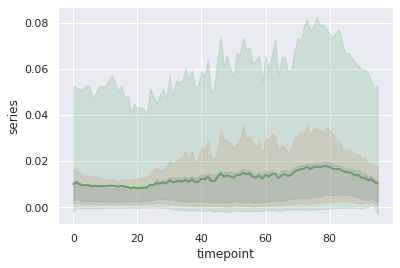

In [20]:
sns.lineplot(data=df, x="timepoint", y="series", errorbar=("pi", 50))
sns.lineplot(data=df, x="timepoint", y="series", errorbar=("pi", 75))
sns.lineplot(data=df, x="timepoint", y="series", errorbar=("pi", 95))

<AxesSubplot:xlabel='timepoint', ylabel='series'>

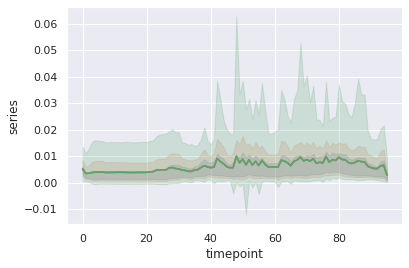

In [17]:
sns.lineplot(data=df, x="timepoint", y="series", errorbar=("pi", 50))
sns.lineplot(data=df, x="timepoint", y="series", errorbar=("pi", 75))
sns.lineplot(data=df, x="timepoint", y="series", errorbar=("pi", 95))

In [3]:
# Values for 2020 data.
#minmax = pdm.minmax
minmax = (24.68611113230385, 7506.149891493055)

# Values for 2021/20222 OpenMeter Data
minmax = (0.0, 47567.1243283996)

In [50]:
# Write to csv

In [136]:
output_data.shape

torch.Size([21960, 96])

In [8]:
output_data = (xgen_*(minmax[1]-minmax[0]))+minmax[0]
output_data.shape

torch.Size([21960, 96])

In [4]:
import datetime
timechange_remove = {
    datetime.datetime(2020, 3, 29, 2, 0, 0),
    datetime.datetime(2020, 3, 29, 2, 15, 0),
    datetime.datetime(2020, 3, 29, 2, 30, 0),
    datetime.datetime(2020, 3, 29, 2, 45, 0),
    datetime.datetime(2021, 3, 28, 2, 0, 0),
    datetime.datetime(2021, 3, 28, 2, 15, 0),
    datetime.datetime(2021, 3, 28, 2, 30, 0),
    datetime.datetime(2021, 3, 28, 2, 45, 0),
    datetime.datetime(2022, 3, 27, 2, 0, 0),
    datetime.datetime(2022, 3, 27, 2, 15, 0),
    datetime.datetime(2022, 3, 27, 2, 30, 0),
    datetime.datetime(2022, 3, 27, 2, 45, 0),
}

In [9]:
start_date = datetime.datetime(2020,1,1,0,0,0)
end_date = datetime.datetime(2023, 1, 1, 0, 0, 0)
interval_length = datetime.timedelta(minutes=15)
n_households = 386

with open("wgan_openmeter_202122_kernelsize7.csv", "w") as f:
    day = start_date
    j = 0
    while day < end_date:
        series = generate_synthetic_samples(model.generator, size=n_households, clip=False)
        series = series * (minmax[1] - minmax[0]) + minmax[0]
        for i in range(96):
            dt = day + i*interval_length
            val = series[:,0,i]
            val_string = ",".join([str(x.item()) for x in val])
            if dt not in timechange_remove:
                f.write(f"{str(dt)},{val_string}\n")
        day = day + datetime.timedelta(days=1)
        j += 1

In [12]:
!wc -l wgan_openmeter_202122_kernelsize3.csv

105204 wgan_openmeter_202122_kernelsize3.csv


In [14]:
xtrain = torch.concat([x for x in pdm.data_train]).numpy()
meanx = xtrain.mean(axis=0)

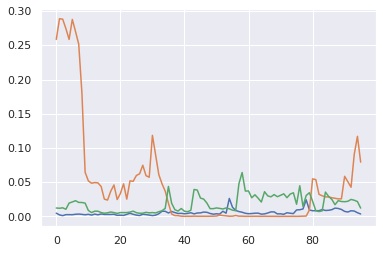

In [41]:
plt.figure()
for x in xtrain[10000:10000+3]:
    plt.plot(x)
plt.show()

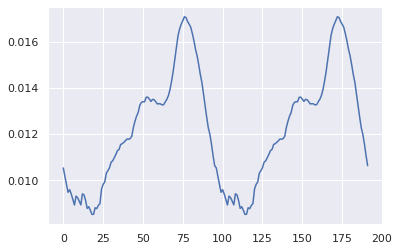

In [42]:
plt.figure()
plt.plot(2*list(meanx))
plt.show()

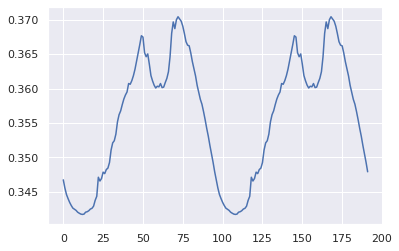

In [122]:
plt.figure()
plt.plot(2*list(meanx))
plt.show()

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
#df = pd.read_csv("output_202122.csv", header=None)
df = pd.read_csv("wgan_openmeter_202122_kernelsize3.csv", header=None)
df[0] = pd.to_datetime(df[0])
df = df.set_index(df[0])
del df[0]

<Axes: xlabel='0'>

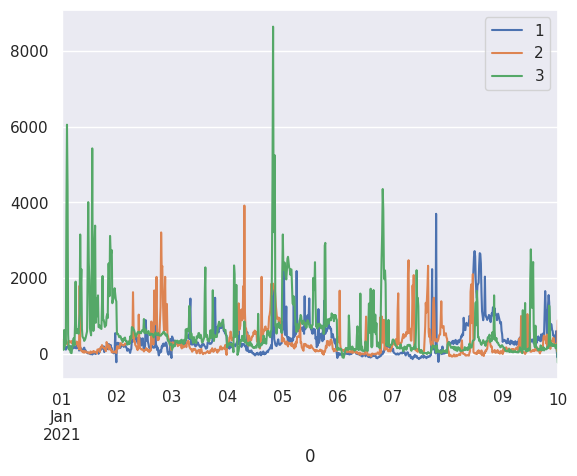

In [16]:
df.loc["2021-01-01 00:00:00":"2021-01-10 00:00:00", list(range(1,4))].plot()

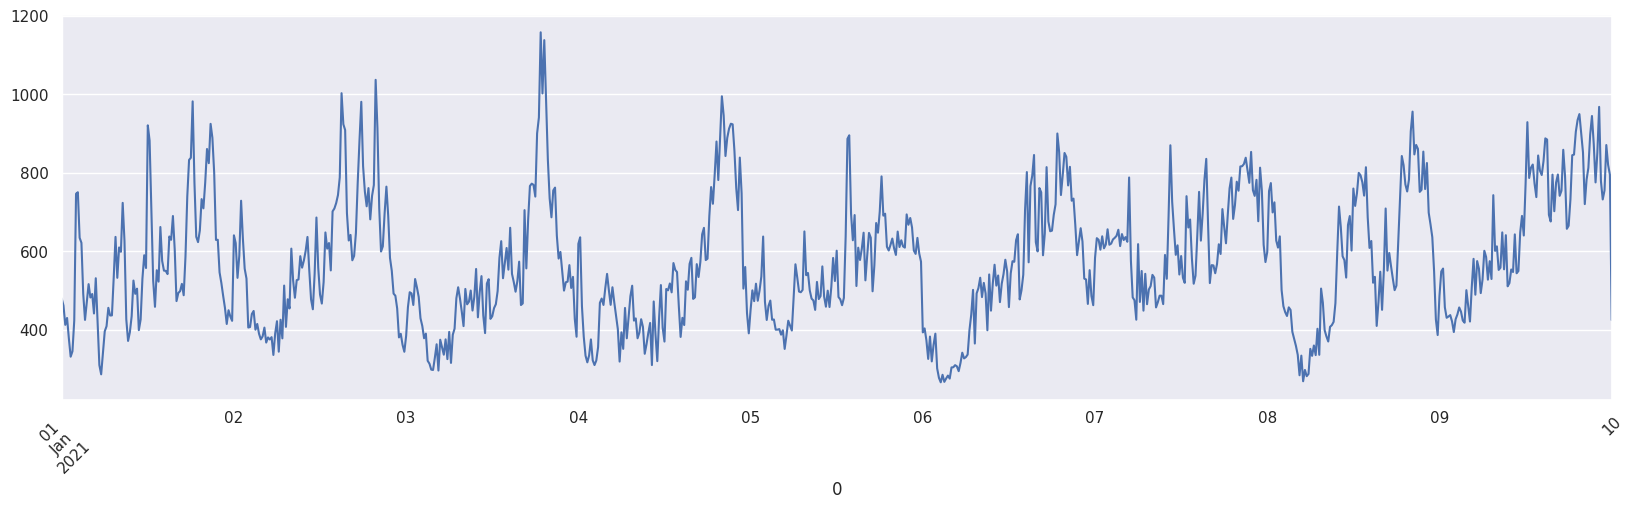

In [17]:
# Kernelsize 3
df.loc["2021-01-01 00:00:00":"2021-01-10 00:00:00"].mean(axis=1).plot(figsize=(20,5))
plt.xticks(rotation=45)
plt.show()

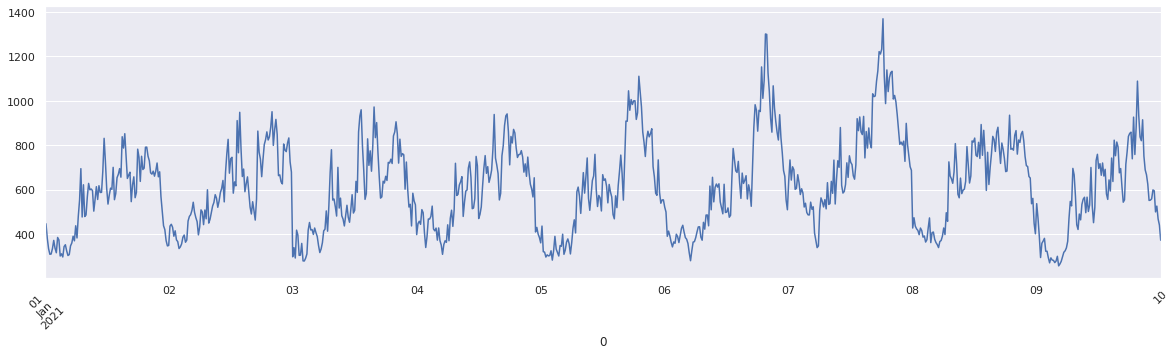

In [30]:
# Kernelsize 3
df.loc["2021-01-01 00:00:00":"2021-01-10 00:00:00"].mean(axis=1).plot(figsize=(20,5))
plt.xticks(rotation=45)
plt.show()

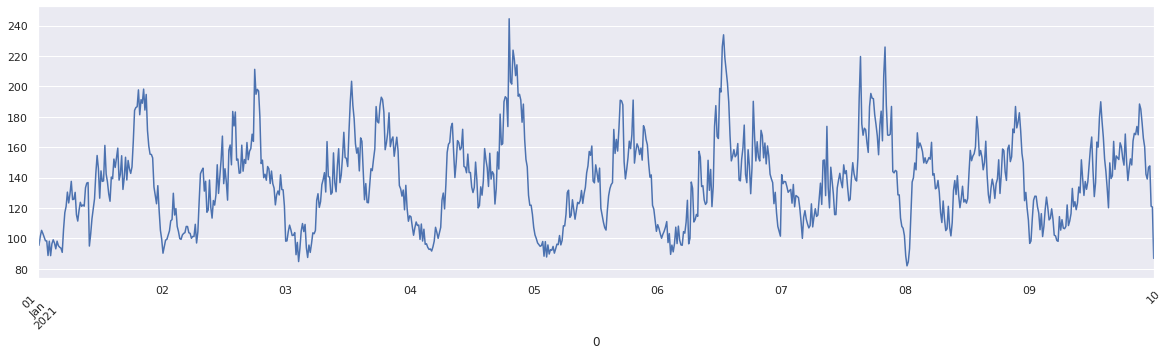

In [33]:
# Kernelsize 7
df.loc["2021-01-01 00:00:00":"2021-01-10 00:00:00"].mean(axis=1).plot(figsize=(20,5))
plt.xticks(rotation=45)
plt.show()

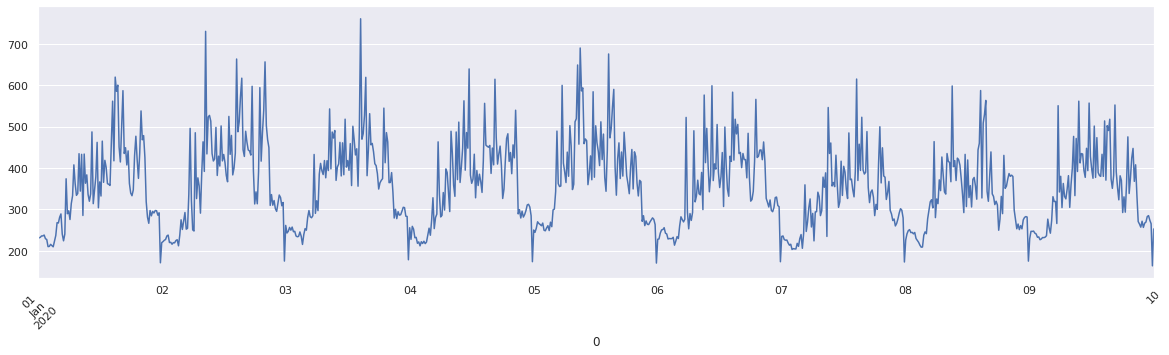

In [47]:
df.loc["2020-01-01 00:00:00":"2020-01-10 00:00:00"].mean(axis=1).plot(figsize=(20,5))
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'Power Consumption [W]')

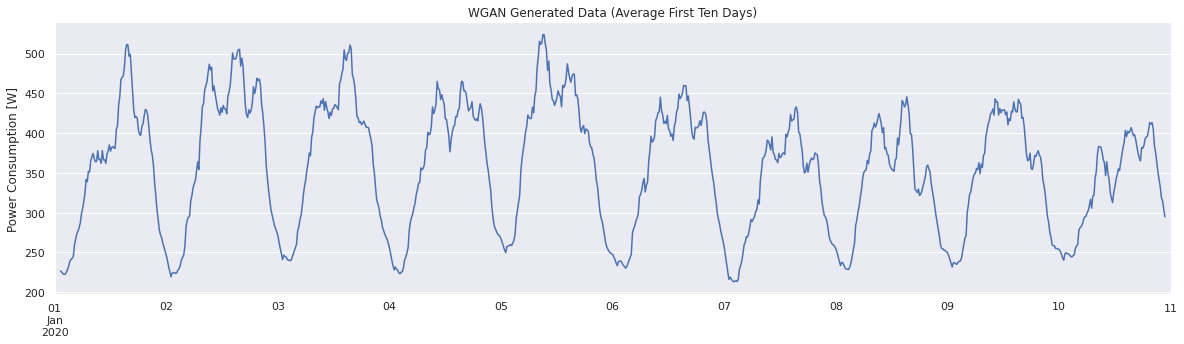

In [99]:
df.loc["2020-01-01 00:00:00":"2020-01-11 00:00:00"].mean(axis=1).rolling(11, center=True).mean().plot(figsize=(20,5))
plt.title("WGAN Generated Data (Average First Ten Days)")
ax = plt.gca()
plt.xlabel("")
plt.ylabel("Power Consumption [W]")

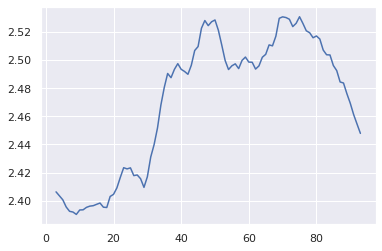

In [93]:
meancurve = (pdm.data.loc["2020-08-02 00:00:00":"2020-08-03 00:00:00"].mean(axis=1).rolling(7, center=True).mean().values
+ pdm.data.loc["2020-08-03 00:00:00":"2020-08-04 00:00:00"].mean(axis=1).rolling(7, center=True).mean().values
+ 5*pdm.data.loc["2020-08-04 00:00:00":"2020-08-05 00:00:00"].mean(axis=1).rolling(7, center=True).mean().values)

plt.figure()
plt.plot(meancurve)
plt.show()

<AxesSubplot:xlabel='time'>

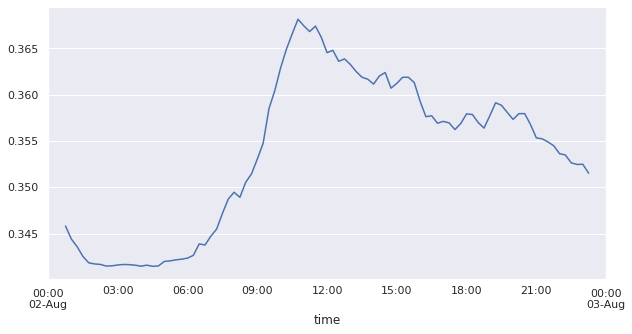

In [80]:
pdm.data.loc["2020-08-02 00:00:00":"2020-08-03 00:00:00"].mean(axis=1).rolling(7, center=True).mean().plot(figsize=(10,5)) +

In [ ]:
import matplotlib.dates as mdates
df.loc["2020-01-02 00:00:00":"2020-01-03 00:00:00"].mean(axis=1).rolling(7, center=True).mean().plot()
plt.xticks(rotation=45)
plt.title("WGAN Generated Data (Average Day)")
ax = plt.gca()
plt.xlabel("")
plt.ylabel("Power Consumption [W]")
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
#ax.xaxis.set_minor_locator(mdates.DayLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gcf().autofmt_xdate()
plt.show()

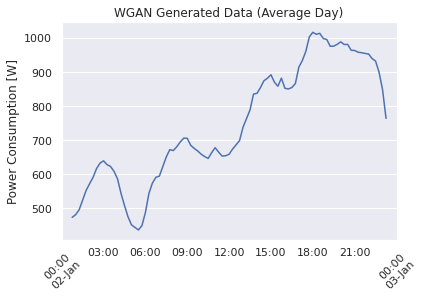

In [32]:
import matplotlib.dates as mdates
df.loc["2020-01-02 00:00:00":"2020-01-03 00:00:00"].mean(axis=1).rolling(7, center=True).mean().plot()
plt.xticks(rotation=45)
plt.title("WGAN Generated Data (Average Day)")
ax = plt.gca()
plt.xlabel("")
plt.ylabel("Power Consumption [W]")
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
#ax.xaxis.set_minor_locator(mdates.DayLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gcf().autofmt_xdate()
plt.show()

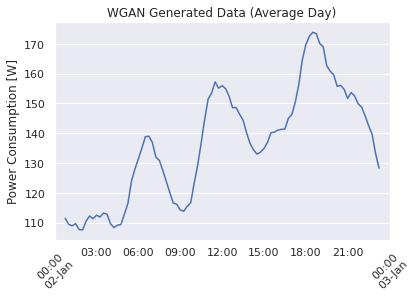

In [43]:
import matplotlib.dates as mdates
df.loc["2020-01-02 00:00:00":"2020-01-03 00:00:00"].mean(axis=1).rolling(7, center=True).mean().plot()
plt.xticks(rotation=45)
plt.title("WGAN Generated Data (Average Day)")
ax = plt.gca()
plt.xlabel("")
plt.ylabel("Power Consumption [W]")
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
#ax.xaxis.set_minor_locator(mdates.DayLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gcf().autofmt_xdate()
plt.show()

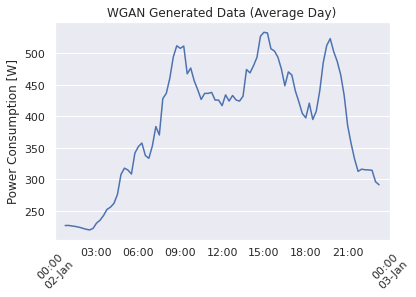

In [102]:
import matplotlib.dates as mdates
df.loc["2020-01-02 00:00:00":"2020-01-03 00:00:00"].mean(axis=1).rolling(7, center=True).mean().plot()
plt.xticks(rotation=45)
plt.title("WGAN Generated Data (Average Day)")
ax = plt.gca()
plt.xlabel("")
plt.ylabel("Power Consumption [W]")
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
#ax.xaxis.set_minor_locator(mdates.DayLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gcf().autofmt_xdate()
plt.show()

<AxesSubplot:xlabel='0'>

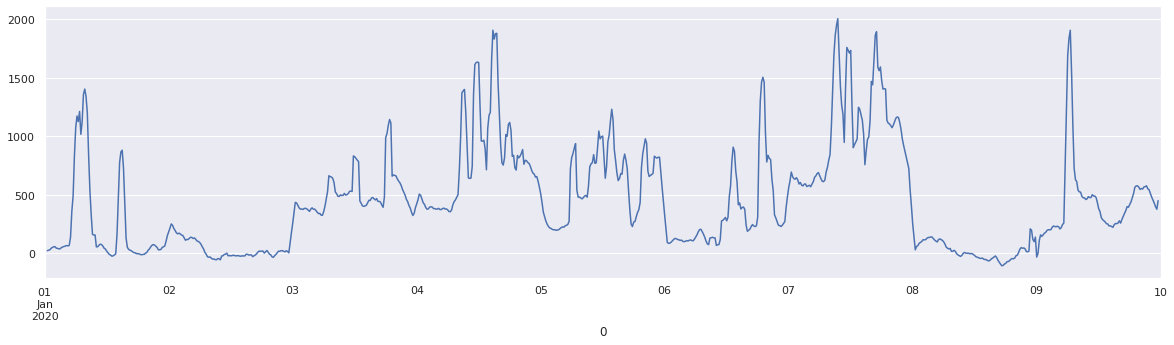

In [33]:
df.loc["2020-01-01 00:00:00":"2020-01-10 00:00:00", 5].rolling(5, center=True).mean().plot(figsize=(20,5))

<AxesSubplot:xlabel='0'>

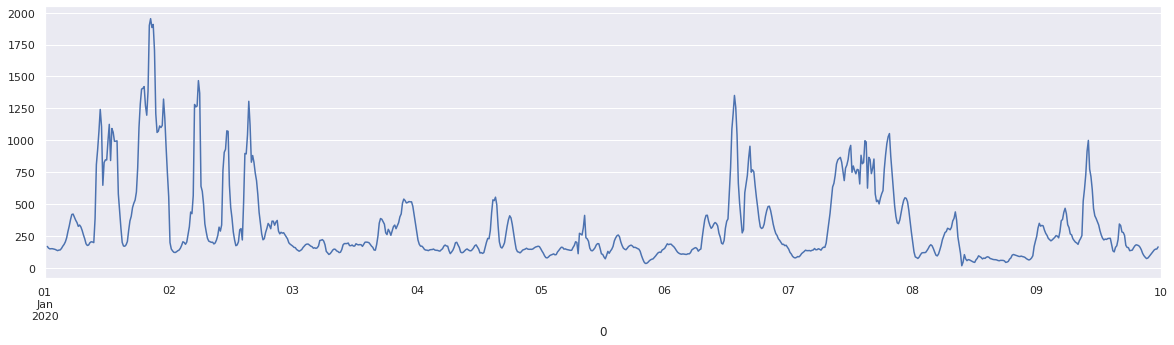

In [58]:
df.loc["2020-01-01 00:00:00":"2020-01-10 00:00:00", 5].rolling(5, center=True).mean().plot(figsize=(20,5))

<AxesSubplot:xlabel='0'>

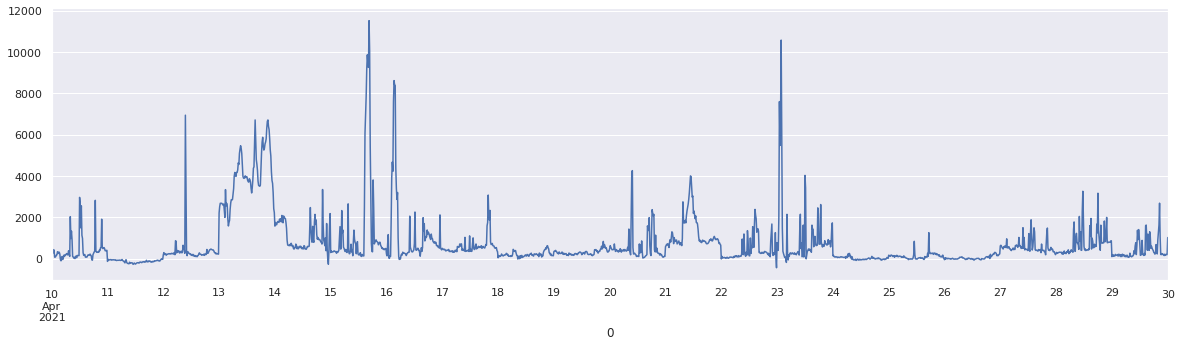

In [34]:
df.loc["2021-04-10 00:00:00":"2021-04-30 00:00:00", 1].plot(figsize=(20,5))

<AxesSubplot:xlabel='0'>

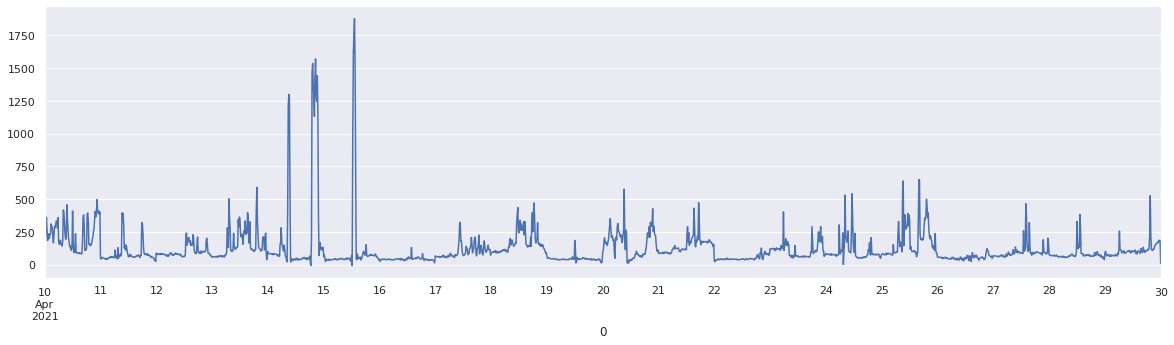

In [27]:
df.loc["2021-04-10 00:00:00":"2021-04-30 00:00:00", 1].plot(figsize=(20,5))

<AxesSubplot:xlabel='0'>

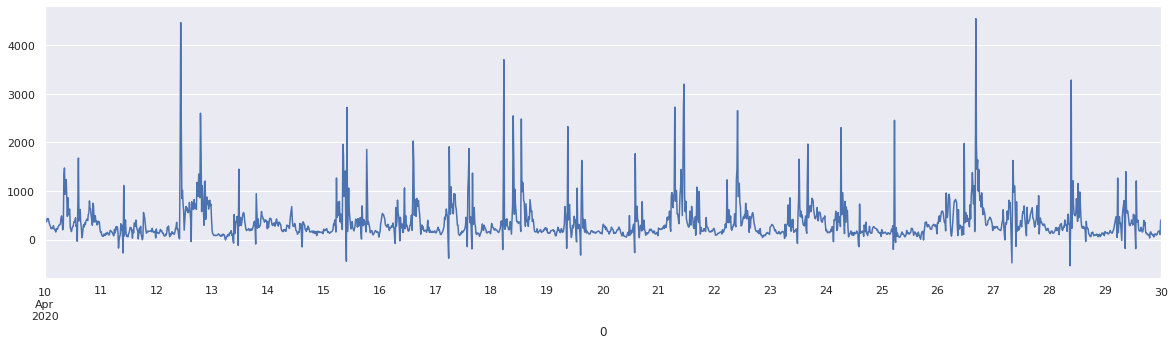

In [10]:
df.loc["2020-04-10 00:00:00":"2020-04-30 00:00:00", 1].plot(figsize=(20,5))

In [36]:
!ls output.csv

output.csv


In [35]:
df

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,161.533997,152.631866,166.087494,43.373672,-4.559043,134.614151,167.916779,623.590759,-38.010971,539.090149,...,615.226196,389.578705,278.221985,-10.167545,1843.509399,3514.724609,244.337250,174.508041,208.892731,22.969444
2020-01-01 00:15:00,170.611008,253.823700,216.441544,170.940430,81.509720,159.544205,189.540085,506.247894,76.214455,594.056824,...,779.225220,370.280792,348.643433,87.886833,2029.937378,4073.098145,264.577667,240.593826,351.415741,39.737789
2020-01-01 00:30:00,121.473763,220.242874,164.399124,107.682915,14.975919,99.974716,183.425385,560.335693,6.414958,525.307129,...,699.534241,340.295898,288.120087,15.700362,1344.364746,4257.805664,290.254181,186.751389,261.024048,20.856039
2020-01-01 00:45:00,103.477638,198.238846,197.451431,99.796219,13.516788,59.492844,125.876686,446.861267,53.136013,590.804077,...,732.569763,290.275208,261.617249,35.240608,1210.773071,4427.005859,248.106323,233.995605,260.670715,15.776838
2020-01-01 01:00:00,97.063965,224.783188,217.563141,120.494179,7.884530,83.207024,161.595291,332.360809,78.581696,616.199158,...,681.110535,218.597626,282.056824,39.517181,1265.194824,4863.653809,154.718170,190.135208,232.527115,-14.774262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:45:00,637.102661,811.435364,459.711243,896.282715,288.841248,560.698975,708.593506,242.096802,131.924606,194.328430,...,467.922455,389.738495,440.226288,1286.727783,1047.154907,395.254028,176.072983,1683.509521,119.061974,244.974579
2022-12-31 23:00:00,669.978394,487.298584,417.444916,904.790283,255.469727,488.027893,691.912720,285.176605,141.675110,170.736618,...,471.831055,394.518738,412.430969,1505.626221,475.254608,356.551727,494.994476,1554.244751,124.542755,164.936295
2022-12-31 23:15:00,695.618774,956.570374,414.021393,860.471436,272.283112,474.007996,699.749634,831.284241,924.784851,423.898499,...,454.699188,1289.734985,403.733215,1494.281250,437.942932,389.789307,224.023392,1582.364624,124.649284,216.872253


In [213]:
!ls -hl *.csv

-rw-r--r-- 1 bschaefermeier bschaefermeier  20M Jul  7 16:45 generated_profiles_wgan_wpuq_2020.csv
-rw-r--r-- 1 bschaefermeier bschaefermeier  20M Jul 10 11:17 generated_profiles_wgan_wpuq_2020_no_pv.csv
-rw-r--r-- 1 bschaefermeier bschaefermeier 2.4K Jun 22 17:36 mmds_all_households.csv
-rw-r--r-- 1 bschaefermeier bschaefermeier 2.4K Jun 30 10:29 mmds_finetuned.csv
-rw-rw-r-- 1 bschaefermeier bschaefermeier 2.7K Jun 30 10:26 mmds_finetuned_with_duplicates.csv
-rw-r--r-- 1 bschaefermeier bschaefermeier  14M Jul 10 16:21 output.csv


In [212]:
!tail output.csv

2021-12-31 21:30:00,252.3026580810547,360.40924072265625,354.26422119140625,161.02236938476562,169.74273681640625,28.74337387084961,211.8671875,80.2026138305664,196.61541748046875,453.2384033203125
2021-12-31 21:45:00,219.15330505371094,440.4488525390625,325.32916259765625,141.5084686279297,132.5448760986328,18.096187591552734,175.35797119140625,97.61714935302734,220.322265625,542.0108032226562
2021-12-31 22:00:00,209.05345153808594,381.47900390625,204.87850952148438,149.5198211669922,103.18636322021484,49.58137512207031,150.30789184570312,82.6604232788086,150.6832733154297,447.82177734375
2021-12-31 22:15:00,151.50274658203125,405.13006591796875,191.0066680908203,137.78897094726562,109.34001922607422,78.25814056396484,147.56471252441406,81.01148986816406,172.2904510498047,390.39727783203125
2021-12-31 22:30:00,172.28945922851562,399.91259765625,233.74302673339844,123.54025268554688,119.84408569335938,87.51990509033203,145.52523803710938,103.6058578491211,158.50730895996094,401.3802490

In [71]:
output_df = pd.DataFrame(output_data.numpy())

In [73]:
output_df.to_csv("generated_profiles_wgan_wpuq_2020_no_pv.csv", index=False, header=False)

In [74]:
!wc -l generated_profiles_wgan_wpuq_2020.csv

21960 generated_profiles_wgan_wpuq_2020.csv


In [75]:
!ls -hal *.csv

-rw-r--r-- 1 bschaefermeier bschaefermeier  20M Jul  7 16:45 generated_profiles_wgan_wpuq_2020.csv
-rw-r--r-- 1 bschaefermeier bschaefermeier  20M Jul 10 11:17 generated_profiles_wgan_wpuq_2020_no_pv.csv
-rw-r--r-- 1 bschaefermeier bschaefermeier 2.4K Jun 22 17:36 mmds_all_households.csv
-rw-r--r-- 1 bschaefermeier bschaefermeier 2.4K Jun 30 10:29 mmds_finetuned.csv
-rw-rw-r-- 1 bschaefermeier bschaefermeier 2.7K Jun 30 10:26 mmds_finetuned_with_duplicates.csv


### Load data

In [7]:
start_date = '2019-01-01 00:00:00+02'
split_date = '2019-02-01 00:00:00'
end_date   = '2019-02-03 00:00:00+02'
if False:
    start_date = '2019-01-01 00:00:00+02'
    split_date = '2020-01-01 00:00:00'
    end_date   = '2020-01-03 00:00:00+02'
pdm = PowerDataModule(dataset="wpuq", start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=True, min_max_scale=False)
pdm.setup()

In [24]:
start_date = '2020-01-01 00:00:00+02'
split_date = '2020-01-29 00:00:00'
end_date   = '2020-01-31 00:00:00+02'
non_pv_households = ['sfh10', 'sfh11', 'sfh12', 'sfh14', 'sfh16', 'sfh17', 'sfh18', 'sfh19', 'sfh20', 'sfh21', 'sfh22', 'sfh23', 'sfh25', 'sfh27', 'sfh28', 'sfh29', 'sfh3', 'sfh30', 'sfh31', 'sfh32', 'sfh34', 'sfh35', 'sfh36', 'sfh37', 'sfh38', 'sfh39', 'sfh4', 'sfh40', 'sfh5', 'sfh6', 'sfh7', 'sfh8', 'sfh9']

pdm = PowerDataModule(dataset="wpuq", assets = non_pv_households, start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=True, drop_na=False, min_max_scale=True)
pdm.setup()

In [25]:
start_date = '2020-01-01 00:00:00+02'
split_date = '2020-12-29 00:00:00'
end_date   = '2020-12-31 00:00:00+02'
non_pv_households = ['sfh10', 'sfh11', 'sfh12', 'sfh14', 'sfh16', 'sfh17', 'sfh18', 'sfh19', 'sfh20', 'sfh21', 'sfh22', 'sfh23', 'sfh25', 'sfh27', 'sfh28', 'sfh29', 'sfh3', 'sfh30', 'sfh31', 'sfh32', 'sfh34', 'sfh35', 'sfh36', 'sfh37', 'sfh38', 'sfh39', 'sfh4', 'sfh40', 'sfh5', 'sfh6', 'sfh7', 'sfh8', 'sfh9']
pdm = PowerDataModule(dataset="wpuq", assets = non_pv_households, start_date=start_date, end_date=end_date, split_date=split_date, load_metadata=True, drop_na=False, min_max_scale=True)
pdm.setup()

In [61]:
pdm.minmax

(24.68611113230385, 7506.149891493055)

In [26]:
minmax = (pdm.data.min().min(), pdm.data.max().max())
minmax

(0.0, 1.0)

In [90]:
((pdm.data - minmax[0])/(minmax[1]- minmax[0]))

1.0

In [24]:
pdm.minmax

(-3915.957445353657, 7078.136699761272)

In [27]:
pdm.minmax

(24.68611113230385, 7506.149891493055)

### Finetune model

In [13]:
def finetune(model, household_id, train_data, val_data, epochs=20, accelerator="auto", dirpath="/share/data1/bschaefermeier/chkpt/wgan/finetune/"):
    """
    Finetune a pretrained WGAN for a given household.
    """
    savedir = f"{dirpath}/{household_id}"
    tb_logger = pl.loggers.TensorBoardLogger(save_dir=savedir)
    checkpoint_callback = ModelCheckpoint(dirpath=savedir, filename=f'{model.__class__.__name__}_{model.name}', every_n_epochs=10, save_top_k=1)
    callbacks = [checkpoint_callback]
    loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
    trainer = pl.Trainer(logger=tb_logger, max_epochs=epochs, callbacks=callbacks, check_val_every_n_epoch=10, accelerator=accelerator)
    trainer.fit(model, loader_train, loader_val)
    return model

In [9]:
conditions = {
    "pv_households":     pdm.metadata['pv'] == True,
    "single_households": pdm.metadata['n_inhabitants'] == 1
}

subdata = { condition: set(pdm.metadata[idx]["id"].unique()) for condition, idx in conditions.items() }
subdata

{'pv_households': {'sfh13', 'sfh15', 'sfh26', 'sfh33'},
 'single_households': {'sfh15',
  'sfh21',
  'sfh26',
  'sfh27',
  'sfh30',
  'sfh34',
  'sfh6'}}

In [11]:
set(pdm.metadata.id)-subdata['pv_households']

{'sfh10',
 'sfh11',
 'sfh12',
 'sfh14',
 'sfh16',
 'sfh17',
 'sfh18',
 'sfh19',
 'sfh20',
 'sfh21',
 'sfh22',
 'sfh23',
 'sfh25',
 'sfh27',
 'sfh28',
 'sfh29',
 'sfh3',
 'sfh30',
 'sfh31',
 'sfh32',
 'sfh34',
 'sfh35',
 'sfh36',
 'sfh37',
 'sfh38',
 'sfh39',
 'sfh4',
 'sfh40',
 'sfh5',
 'sfh6',
 'sfh7',
 'sfh8',
 'sfh9'}

### Generate output data

In [63]:
pdm.minmax

(24.68611113230385, 7506.149891493055)

In [55]:
pdm.data.values.shape

(35229, 38)

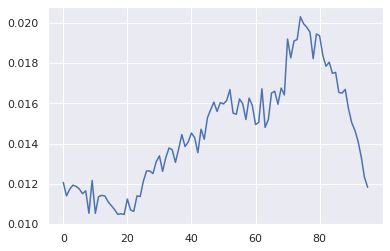

In [28]:
plt.figure()
plt.plot(xgen.reshape(xgen.shape[0], xgen.shape[-1]).mean(axis=0))

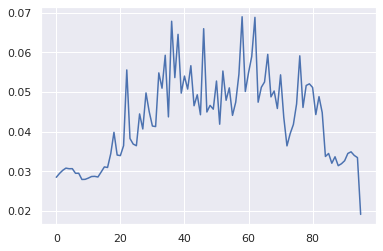

In [39]:
plt.figure()
plt.plot(reshape(output_data).mean(axis=0))

In [15]:
xgen.shape

torch.Size([5000, 1, 96])

### Evaluate the model

In [84]:
pdm.data.index.min()

Timestamp('2021-01-01 00:00:00')

In [85]:
pdm.data.index.max()

Timestamp('2023-01-01 00:00:00')

In [65]:
pdm.data.mean(axis=1)[:96]

time
2019-12-31 23:00:00    0.053118
2019-12-31 23:15:00    0.048191
2019-12-31 23:30:00    0.047987
2019-12-31 23:45:00    0.052400
2020-01-01 00:00:00    0.054026
                         ...   
2020-01-01 21:45:00    0.054738
2020-01-01 22:00:00    0.050812
2020-01-01 22:15:00    0.048307
2020-01-01 22:30:00    0.053876
2020-01-01 22:45:00    0.042382
Length: 96, dtype: float64

In [74]:
# Reload OpenMeter but only the households which will be used for training (Privat, removing one outlier household with extremely high power consumption)
households_to_use_list = ['22d3fd2c-a23d-4620-899a-1faee6da511c', '28769f0b-7601-4e5e-823f-97f8ef469910', 'e016926c-fa5c-49a7-a715-6b30d4aab4ed', '18025781-5a6c-4489-a850-7ba0f76eaadc', '8a579476-1069-4087-9ac2-12f728a6cc66', 'e58f2df6-778c-44d8-9c51-1deb5afd99a5', '6b253309-89b7-4282-a2f6-337284356dab', '5c8fbb63-735e-44ec-8f2f-0e0d99aadbfd', '2ed46eeb-bb38-4bd4-b16b-85db6f9f4267', 'cce1b7bc-4290-4312-8534-db7bc2b23a8f', '24595c1e-dd40-4c2e-b2d0-f8499ea7bd7b', '376c1716-47cd-4972-ad72-5ff9bd0e96c1', '8fabd8cb-1261-464b-a0c7-84b948bba530', 'b68504d5-b0d7-44af-a129-745dcc7f4345', 'fa90c793-cba7-4cb7-baad-3b0d8358fa87', '2241a124-0e4c-4b18-abb0-0e31108c543b', 'b06afddc-157f-4acb-a3c0-dabd217e47a9', '7558ee98-7e2c-443c-90af-fc0e7e247ef5', 'cec3d5cc-0548-43b4-9d62-772cae2f6034', '7aaf6ed0-00d8-447b-80ea-ddab8849f36c', 'c6f7ab70-0be6-4531-a65c-1d18e57a9aad', 'b2014e5b-0fce-4bf7-9088-36474df74662', 'b1a70e4d-45a4-449a-8f67-e66c21f12d85', 'd3f8e8c4-32ec-4035-a9b5-ba8c945caa4b', '6b0845f1-fbf6-40fb-9a69-9d104cfa75c6', '248f76e2-0154-466c-a85a-3a3fc22c43fa', '2d873d88-54d9-4a10-92ee-a716cae15a0f', '6e77f347-726a-4b41-a259-c9b55ae723eb', '496f1d46-1cf9-4c2a-96cd-2dc69c66d13a', '6f7d1d04-49af-456b-8f6f-1edf0f8a65f9', 'baacb198-9a92-4826-b1f2-13bb4f922f78', 'b65b40a8-489a-4266-9320-e96d85dd44e0', 'da91589e-a16e-4235-9778-f91d0182a857', '33d8f854-cd3f-41aa-bc22-b6a66a034dd8', '77926d4b-10eb-4e64-8ee4-6458cede1882', '286087f2-254e-430f-950d-b13f92346b7d', '44a6a6ba-5fa6-489d-9c61-139f59788c4c', 'd772f57f-1333-4be7-b43a-200c7dd22b8b', '7205a5fd-6307-493e-bf23-892f3eb3633a', '76ee0e6a-d86e-44a5-bc35-7cb81dc30c82', '52832fa5-6515-4188-950a-8f3d65eebce2', 'c0fcf7f2-f21b-4bdb-8b80-c809a263d7cd', '8e07b268-b0e8-4fc4-b02b-4badd5571957', 'efcf63db-735e-4339-98a2-8c9960c928dc', 'b5605a1a-3ed4-4759-8f3b-ec0164f15747', '347dc5f0-fcc8-4631-bbbf-49dc5e1a7955', 'fd440cb5-d81e-40ee-9819-8395a61c3a35', '9ce5483b-a1fc-41ef-8016-e87847613f44', 'd068fe37-f8a8-4e33-a5c1-c046f96a8af4', '504486d3-8316-47ae-82db-bc31e28e12ba', '0252a8f5-9913-47bb-a70f-c86e5c69f71a', '126327a9-1748-498c-a52d-d333b3879074', '1f2d6239-4aa7-48de-a41b-730399e0d405', '3b42328b-52e3-4027-83b6-13b938c7c2ed', '401ba297-e962-4e75-97c9-7f7f20fb48ca', 'f8e1b12a-268d-4021-8140-0375d4d936be', '0247a559-2660-4434-b204-d8f7ef9da4d4', '8060e043-c622-48b8-a963-ba7fbd4b1e52', '23937e19-e689-4ddc-99dd-bdbed63f3eb7', 'f4ae88f2-4183-4f39-86ff-0b3bfa44211b', 'e0a16fc2-dd90-4015-af33-c1378508f9ed', '6f4ad391-b95c-4ac7-b59f-371c947bcdb5', 'c95842e3-1125-4ad9-9940-0f132773469b', 'f3c1bd43-0076-4c08-9f16-b86200328a52', '1fafc377-6171-4b57-affd-f4cb989c1792', 'a14e7cba-cb2c-4154-9a5c-72b0cb5fb479', '2dc461e9-3a9e-4860-975b-6c88d5204b48', 'ad594dbc-f077-4fd2-9dcd-42b3cbcd2192', '7f18dee7-69f5-4075-8ac3-e530188e3739', 'e83fd0c9-1fc4-4395-b144-36232430bc31', '0520f1fd-30d5-4ffe-8c57-35c36615586c', '718d8e77-f83f-4856-840d-8df0a3d09da8', '946e85d5-1700-4de4-aa43-80d72defebfe', '271a4536-185e-46b1-a407-a37ca78b7dae', '1666d51f-e1b0-4825-9acf-3b312f032483', '54bb3ccc-d1e2-4246-91bb-c2ec61bfe2eb', '9468ecb1-45d4-498d-bcca-e04f27b1dcea', '5de58362-7ebb-40b1-9335-60562b2cdcbb', 'ce281f72-1cb7-4db1-99cc-9c196a7f4e00', 'cecfe8bb-c817-46d2-aa27-008174fe3128', '001dce72-b1c1-44b1-bf16-0c22cfe3a420', 'ddad5aec-cf51-4321-a649-3fa209c1498c', '9ce00f15-6d49-4010-a16a-9416cc542031', '87211969-c89f-4207-8f8e-60c9086dbc7f', '51995fa8-aff1-4efb-a366-bd2e60c2ac18', '6fafd6fb-e139-44f8-9f63-960f607221ca', '50cbb5c5-aba9-434f-8519-7535a7b735ab', '555a243d-7c29-454a-8374-d8e55c1e80d3', '79c4b2a4-8184-48e0-b36e-24146f28e12e', '39627f86-c458-4d90-a520-2f003529f93c', '51b02e2a-3702-4f33-8f8c-cbd06cf79050', 'a49ef75f-c934-447f-bd23-559a6a799a6c', 'e8d5afeb-1ea9-4121-b14f-48f939624c7e', 'a2ab14fc-b563-4e70-bbfe-d64cc9cdade9', '0358067f-cd41-4d91-ba9e-91405fbfc704', 'c21da8e5-e1fa-4b47-9d85-5abd92b48676', '19636f91-d044-4bc4-8cab-d9fae1bd07c0', '7cf6335e-2892-4057-83be-294074cf605b', '904cdf3f-e79b-4b80-8531-79f6343eb70e', '9510637f-edd1-4362-b77a-5e5af2afbd40', 'e8169711-d925-4032-8b84-ab2cebb1bd8c', '220ea888-da70-483a-8e85-ea169bb96638', '30dc5b53-e184-405a-bb21-43a60c7344fb', '4fc5c9de-ad94-4c52-b1b3-329cf6a3f5cc', '0987b42a-c841-4454-90ac-69e5b1054cd5', '6028b036-d45e-4271-b5be-3b2a825f61bb', '66f02100-c3ec-4480-9fba-1b3260129cd6', '96593fda-33be-4d8f-88f7-9a5fc6b8b888', '12aedcfd-33cd-47ac-b495-81c13e0c3039', '0de28587-2941-47f6-9555-b4456ab5ae9c', '6402f9bb-b2ac-47d2-b944-75945fa856e4', '9415ae40-f716-4e78-88b9-51b17fe8acc9', 'baceccf6-99c2-4782-b9d1-691b90968879', '787941a4-d4bf-47bc-8bfc-dd750fe651f3', '9514b930-b41a-4990-8b6d-c0ac4e0b0d67', 'e3a17831-e2af-4002-83a1-57c2aa51f190', '94526bac-11c0-4854-8475-25afcc35dcbd', 'c43336bd-9e0c-46e7-9b27-c712d8ba0a14', '13f73a8c-8876-4d5d-aa85-c7c44c0a960d', '6c2c5ed1-5c20-49c9-9587-0acf85a4ea55', '2f82df5e-78d4-4616-9ab9-5ba69dddabb3', 'da54df98-ffa4-4b1d-9552-40bc0164da8b', '1cc862fc-6e3a-4454-92ac-0649984a9b72', '65a9f0d9-35f1-4fe8-a447-e6f533e9368c', 'c7fd6823-b724-4a5f-9c96-0d9e30133ed4', 'c31919ec-7b31-41f7-a881-8760656f5a78', 'f34846ac-1d2a-457b-ad84-660e7c76fa5d', 'c828b042-f102-4186-b543-ff52fe146342', '6c926838-cd1f-4d5e-a50f-e8ff3f53510d', '8018bb28-1612-461b-afb2-649af8f29a98', '90063fab-7535-459a-b4da-789124247aaf', 'f08a52b7-119f-4797-a306-078abf8f3426', '1714f630-6922-4bfa-84cf-07b61aa076ba', '44d22209-778b-4244-ad0b-f7eecf5d339c', '729c42e9-5169-45ad-a693-58e30038281a', 'de0931c5-afb9-4e52-a745-48dcbc11308f', '7c5ed116-c213-4a50-b330-4d3328ed3e95', '65e70984-7b9d-4e2c-a324-aef5460b202e', 'fe352710-860f-4686-ad4e-e187e99c7256', '9dd60a04-82ff-4979-933b-3f765fdebee3', '5fa47966-1bb1-4f1d-8df1-c31ced754b63', 'bd00a4b7-d6a3-4310-8173-f16e868e96c2', '31bfee98-6de8-4a2b-8896-daf7069f0827', 'c4040dbd-7657-451b-af8a-7e2d35a20982', '6205b6cc-e9ae-4065-8b74-7e0e52e42b49', 'f430e0e4-5cc1-4f40-a5bd-9af423c06677', 'e2304ab3-913c-437e-b363-415361651bb5', 'd4c9f05d-57e0-41b9-b1de-c98942d0c9c8', '9ab2ac51-6547-4a2a-a1ac-02ac4c99883b', 'bca24757-0acc-42fb-a531-a14655da6bd0', 'bd184654-3a4b-4609-b41d-b3b5e55bb1c6', 'e472f992-aad5-4fea-8fa0-e26b6591a323', '4225ef3a-8c23-44a6-a38b-892171d3adcb', 'ef2e3567-bcad-4c28-ac21-9bcbaaf4c385', 'e8eec69f-4ea6-44bc-9ffc-b434575ca38a', '75106228-f23e-4f7b-a3da-9456bb35ea93', '721b47b2-d5cc-411d-80ea-56a2f857acaf', '04b1dc78-587d-4837-978e-ac288a2b480c', 'ccca55e4-25e2-4f2e-a48b-6ca1ec31d96e', 'cd2807e1-0085-4fc6-adfc-6367995d7c34', '3a06e019-2b14-4ed6-9d37-0031640b80a5', '1178737b-13d0-4f18-be37-485975448f37', '319cebc4-74f3-4f4b-b52c-9f6b707a28b3', '9f5a00c2-f4ff-426c-bb2e-921c2bbd21c6', '689006b1-50c6-451a-9e53-89b245dee080', 'b226ba15-8433-4d9d-a3fd-9161439a1b4d', '54e347ca-e41d-427d-ae60-b86443802881', 'e44b6322-1e88-483f-90d3-7e32519b769f', '305f98a7-94fa-413f-a490-1a471d17f547', '8c119331-71a1-4ef2-a5fe-6122e240adef', '9ea84709-259f-4f37-99ee-b8d774894925', 'c24d301f-6475-40e3-b291-43d9cfd88134', '17497f18-6482-4b24-a6d2-02f909d66a37', '21253f10-b379-4846-8891-744b9bad9778', '8cd8c86c-df1c-45b7-85b1-6337d7dcac89', '8aaaad56-171e-4b04-9c6f-5e243d6f3507', '75504b66-0cb8-4235-97f1-6c1591a61260', '84722250-7b20-4b27-b112-db08af7854f6', '5df5fe62-598d-4b46-bb40-ffe9e169d4c4', 'b9d7c4d8-2f13-4f6c-80ca-bbbc9cbd550d', '6b5714fb-56e8-4f68-b05c-b44b8ae7044d', 'bba43084-3a42-4ee1-a261-92b353b24c0a', 'b9bb01f1-e80f-4473-ab13-2455a2eb7ff5', 'fd53424d-2cfa-4a08-8010-98a2b1aec35f', '720a7976-86b1-4a51-95fc-1cb9ba92849d', 'e360e958-e0ce-4c2f-94e2-01e31d151b32', '6a9cb54f-0257-4e2d-9055-1216c51d7a2d', 'cc9122c8-ebdc-4238-a5c3-ec90df8d91bd', '67d6ef4b-f11c-4077-b71e-a3dbb5e91623', 'e7d993b3-fb7d-4fde-bec1-53ac74f24904', '848c4714-27c2-4064-9de8-7a88d60360bc', '0320fee3-66fb-4f70-b139-ff45d4e03a17', '33b6957c-d968-4397-bec1-4ead226b5f68', '63d87914-8afd-4856-90cd-2d00f5d36b4c', 'a5da17fc-3765-4e65-927a-53e54dd2454a', 'a84c293c-80e3-4578-8194-e6eaa290c382', 'b4284ee5-5873-46e8-9593-4c916feaaa34', 'bbf974de-6a5e-4fe9-9873-c54ca3bba75c', '7856246d-8cbf-4bae-bcba-9a734a0637e6', '73f215ea-73cb-41d6-89a7-e2a3eb9b6c16', 'ae540ff8-5f24-48f3-9677-9cc928b6f6c2', '5b8a2d23-6c49-4516-9712-9960c9df651e', 'ef67f92e-0be2-4f7b-9aa0-094149b1e1e4', '37d2353e-8bae-41d2-863e-86adbb8aad5e', '536162d0-a901-4243-947f-bf2dcbef0532', 'bacabe66-e63d-4dee-b350-a85d801c07d7', 'c03cbd32-1df6-4655-b73a-4753ef06fb83', 'e52e65cb-75e9-485d-b294-6fd41c393caf', '03b8c76b-aee3-473e-8f25-c21cea1e0ba6', 'e3eebde2-a143-4434-8a64-061dcab77a54', '4337ad00-30a3-47d9-8f6f-2e7ff6086801', 'fb0d081f-ec23-4e37-aff4-b595e7789b22', '7d50541d-1d50-4ded-8bb4-56c4f2a08ed5', 'f6a5371f-93e9-41f3-81cd-9546ed94055e', '912df36e-fd7c-49bf-a072-40b9b52294d2', '5af6d974-de89-4823-b226-c52cf1104b45', 'fb66b0f7-16cf-4bdc-8099-745f2c6e39e4', 'e060e605-4eda-4cb3-8d72-dd969b94ca5b', '81dc89ea-e932-4e5e-b232-f62f396042eb', '82b052bd-81c7-409e-85a6-a161507cdcaf', 'df64235a-9b4c-4543-a1bf-73bd3e4d8d53', '4241346f-2e6d-4db1-86c2-bf90d8a6af4e', '3f9eccea-aa85-4987-9fa4-ccdc85e92b9e', '60b63962-cc0e-4cea-adcd-6c0308c2cb1c', 'eaa7b605-c2fa-4ff9-9125-3024969db714', '90b04679-6db2-43f3-896c-00049a5eb66d', 'e4628967-a156-4b91-9e2a-593655660359', 'cfa5cfad-50e7-4626-a027-f1b2b1578ea4', 'a9fe09cc-de85-45f9-aa65-077d49a586d2', '8300e048-0fce-4a39-8ac5-e990b22ad9f8', '685740db-827e-4eb5-bd08-5bc8ae905a38', '95f2ef9c-10cb-43fd-a239-d6fe1e4094f3', '96331270-24b9-4577-b509-86187aad3bee', '13afec5f-dd17-4bc5-a544-194ab20575ca', '9be36162-73f3-4981-96fb-cd9e5779784b', 'f6e7f7cd-489a-4536-b48c-a3168df64a1b', 'c24d4d9e-cbbc-4815-8f81-d95911a90f44', 'e06e7a66-c777-4eb9-832f-cb104b34fe25', '8fd50bcc-e036-41ac-ba7b-d9aa870d4f6d', '352f4c93-d38c-4109-a961-03f4db879ec3', 'de068292-41dc-482d-9fd8-92688a7abbb9', '82cec8ed-719f-4352-9b78-ba1ae69560ed', '2ceed31d-5c71-46c8-ba1b-e93a787d683f', '4cbfbd27-821f-4105-bcc9-2c8d62d205c6', '51391be0-c021-471f-8c0a-14a36c8488ad', '12c77d0d-c6a0-4fc8-ae44-022c11e38aa3', 'dbe8794f-2aea-4af7-939c-6dc2cca2e793', '7a906aaf-2609-43d8-bcf5-2c4d73d1d822', 'ce785826-7e58-4582-9b45-048efbe48857', 'c3252268-497a-44ea-b37f-7576de1d8894', 'e866d8ad-8042-499d-aee5-7c5ec420d964', '9b7f9468-a636-4a27-995f-4ab6a18125cd', 'f8964cf8-7f5f-4c4c-b65e-4f1a889ad00c', '5a8082d8-3166-41bd-844b-bfce41bbcd13', '913c7123-048d-44cf-924e-d8e77eb7eaf9', 'c01e315e-6642-417e-9563-357e5d682bc7', 'c4329fb3-632f-4dad-94f6-176e4ea0c7ec', 'c7155c71-4c97-4031-92fc-9e7872fb2f3e', '18ba6fc3-d380-4243-bbef-857c3de97e31', '0d1df061-d516-455b-9194-4b515a2a94af', '7401b884-9ebe-4b11-ad95-9ea729752f49', '476ebd3c-f503-4ff6-9525-7ceddb52010f', '5d303fea-0cbf-4fe4-a638-26644acbdcc4', '367621ef-7d7b-43eb-ba1f-988e90b4fbed', 'ccce5a09-d6a9-428d-af89-41d43d9eb753', 'b9a2746d-9183-4126-a3f8-88df2480784d', 'f872917d-dbbc-4b88-bbf9-ef412a91decc', 'da798658-93b2-4247-8b23-66ef0eb46bb6', '340d6050-bd32-474e-94ed-33b7bf4c1df3', '5a5ae6dd-24bb-46e8-8971-a581b6f8975e', 'ad68fc76-36bb-4318-9b7a-ca1eb7843370', '32cb5e56-6f0b-4e70-be36-db410c823620', '41e334b9-b076-47de-ac59-fb4270b06dd3', '8504cd6e-4113-441a-81e7-14dbcf239a50', '72d8a014-3432-48e7-b086-ddaa8b0e2e74', 'bd1e8fb4-6433-4a03-80ad-1c42db9240ed', '0ab2b2e6-1a39-46c5-bc67-0a635875e03b', 'ec55484f-d199-4c01-b45e-218424e32894', 'd8d942fe-e6bb-42cb-96ca-a6c9e37d148e', '41a4575e-db00-4ed4-b77d-df2d628f46c1', 'e5a00a12-9321-41ea-bbc5-4665578ec279', 'bc83dddd-68dc-41d8-8e73-acd7c05bba8c', 'c2d07729-1c8f-4859-aece-965790c914b6', '04b810f1-7117-4dd3-8fc1-1845877daf63', '9742cee9-4f6c-4f14-b9b5-7bdd3985f17c', '6f6730f9-83d4-45eb-bd1c-1df7dea9b78e', '1885cf63-5f31-45b9-94ab-f7f7815d3bed', '6154d275-3bb6-4d5c-9c18-a6e0672c8777', '9b5517ba-c9ad-45f7-a5b6-b0c468a04117', 'd7247ebb-4331-4474-968a-8b2ef1054394', '65284aad-1703-4842-82d7-0d455db8e613', '49ed3643-d884-4644-8669-5791e50711f2', 'd31632fc-6e04-4b1b-a450-d24076fb23ff', 'd37837d5-c260-432b-8469-2e93b809b68c', '7ffa2647-e30f-4be6-ae08-8b60f1f3f422', 'd50abaef-dff0-4bbd-b2c7-34a7a400ab37', 'cf93a4ef-eabe-44ee-9b1f-6783b84076d4', 'd0e94030-b874-4b54-806c-2fc1bddb48aa', 'ba76c95d-a7dd-40ef-9d99-34fab373a26d', 'a3400766-e86e-4a08-bd86-e832bdc27daa', 'e6a547e8-50b3-4465-bce4-bc300a108b04', '151d956a-53ee-480c-91a6-2aa5afcce049', 'fb0edc78-41d5-4af5-ac57-d8ac69e71600', '5dbfe71d-dd31-4b76-bef6-82e05b9c6077', '6cbe26d6-43bd-42c6-a440-57a0f4b81dab', '1f03795f-faf0-4d0e-8434-7eda17f639db', 'c8abb2cd-1b2b-4904-90f6-8715831f4414', 'cdf7f73c-94b9-4bd7-ac83-95a717a6226c', '09f9a8ca-f346-4c9e-9ce6-8e7725bae5b3', 'd037820c-304f-48d9-b29c-49f612501aae', '732d3985-e43d-4e56-a623-25249370a69d', '83a60410-51a3-43a8-a79e-e0324a94b766', 'f442db46-ac45-4067-9d2d-635d6b57f4f4', 'fa05d21a-c315-443a-84b4-c96006bbb8f7', '9081bf52-436e-4560-a8af-e0fab319dd06', 'af1bbe13-62fa-48f6-b254-d3b84fb12cba', 'be6347df-6de6-4437-9f63-92e2723b7625', 'f1f5762d-5201-4521-af27-6103c774f091', 'aee6dc17-0672-4a22-ab3d-a99598254e86', 'b3a75204-d619-402d-8ba4-84c7c703ca67', 'df1f7a47-4dc3-427b-b992-e6856306fd59', '037d3c0e-2c33-4705-a6a4-778ce0858c85', 'fdc9f3b1-aabf-4a4a-8f12-1db945883b48', '44b34988-891c-4d54-959a-37195bf260aa', '8fbd2e66-e864-4b31-b522-0695b09cd6b6', 'f6ad84a3-2cdc-4ed4-b230-45dce5c718b2', '8f5c5a24-5cb0-481d-a5f2-38fd331eaa62', '6e70641f-9b9c-4060-9193-bb9f125ca882', '0cc0fcd7-ba31-4b36-abd6-a59b9700918c', 'bf22b603-ef1e-4259-ba74-14db33e0337c', '80196b3e-ebc5-4d4d-9c63-a71b5a40ee68', 'b4fcc832-67b7-4edd-b565-034baa835e01', '38478ba8-ecec-46c4-9212-212eca5133a1', 'ea69ce00-03ad-4280-ba0e-6fd6c60898fa', '175a1ef7-2f94-453d-8713-d9f1912dd027', '06d1421b-265b-4a13-a39f-6df00dbf92a6', 'bceda8de-d598-4a15-ad58-bdc7c6e24bf5', '4b838d22-262d-481e-922b-b544c050a7ff', '5a6fd236-ab3e-4447-88b3-73307558d024', 'ef04658c-1b31-440b-938a-f1fb7c30829e', 'e95ad8c8-511a-495c-92ec-3da14872d9a4', '7035ee06-3fe9-472e-ac47-fe8348bf0b98', '681027e8-876a-4135-bbea-574f62d9b86a', '86e1b6fb-80c5-470f-80f1-2d805ba78522', '158d63a8-d682-4619-a5fa-d4b444beb144', 'e9ebfb7c-3f73-42ae-a9b6-213408505a3f', 'fb191ad9-ee1a-43f7-8045-036158ca45fc', '28274691-20c8-4d90-9b14-5ebf7671d78e', '646f5434-3166-476f-a195-ee4f895b27fe', '7ff81177-37f7-4082-b47a-3f12999b70f5', '6f978c7f-5e38-4df9-80f9-2d755c3e6762', 'cdc9c096-eca2-4d42-8c29-dcbbbc033f81', '833309b2-bd3e-4559-b4c4-9d8dda901727', '888b20c6-591f-4156-9a1d-3816923f1097', '43e60f16-5ef9-442b-857e-d814326fc016', 'd346a361-e169-4413-b835-a3c10673052d', '2d43dcc1-1eb5-4a0f-b74b-27ec71a64c22', '12481948-7808-4615-84f7-a0d92eeaf1a2', '4eeb1554-fcbf-423c-937d-01e88d423196', '522e204d-0382-4d42-a4eb-00d29b3e191d', '0ffa64b2-77bd-4ff9-b1c0-125bd6f541ef', 'b6203b9c-6fee-4117-82f3-051f24ac13c6', '9a952675-9478-4579-a6db-f4e433188f3e', 'd822de3f-f952-47bc-b013-d6a32612d1ad', '6c094402-c471-4bb7-b473-ec4ee1efeb0b', '960d65a4-61a4-4c14-b04c-672ecf0324ed', '50f4e836-a17f-493b-b12a-d70211e38efd', '97fb3f44-ce55-45bc-a6b2-84df0a85e878', '289df69e-ec97-4684-b9a2-a797996fd1cf', '0e3bc76d-f700-4f37-b09c-60de4f2fd8e7', '60948552-b1fa-4311-9a83-fa00fe4f0260', '89dbe96a-ca85-49e0-b5e8-24460ec3b025', '9f6b4516-236d-4eb9-92b4-215b8ac6566e', '4437a34b-9bc6-40fc-96fd-f253e5866333', '7daae0ae-9b8d-4544-9d97-0471c65696fe', '94af212f-e931-48f3-9140-8b47c0954939', '8434374e-d41f-4e4b-af0c-b6c637679282', '4b02a4e9-6745-4c0e-9bed-34aec430fad9', '531555ac-3f0c-40c6-a010-b13ab6d91d1f', '1c782eb6-32f2-4636-9c3e-bc42a7c8bac1', '98a9e93a-e70a-48a4-b8b6-885600b11643', '132493ee-cece-4eb1-b41e-668773466e6c', 'b082685a-5ab2-4e28-81c4-89a8c43f2de0', '8bde7491-e6e0-4c4a-826a-31585424cdb5', '82083982-3803-4732-b261-d7c9d5488ff0', 'a5bfa607-40a7-4e36-be2a-68cb02a2e780', 'ac3e7264-49b5-4177-a114-7b72711629a2', 'e9ceb786-8e50-4000-bc7d-6b1e304204af', '57a0bb2f-5b6c-4586-9d86-d10b9cbdb78b', 'f7406a33-b082-463a-bf61-f00d2e48c9ce', 'a61a03be-f279-45df-aad6-89a09d43ccd5', '89cb00a4-c335-48e4-a977-9dda71c6db7f', 'b2c4ee13-dd01-4934-9ca5-09f81d9ac555', '111893ca-bbac-4269-a2d0-67e9864b3c47', 'e44db49a-2558-42c2-a674-1bffaacfe77c', '49ebab0a-58c0-4bc4-94e0-987aa20c0754', 'ab97fa63-71c3-49df-81df-4685e6dd39f7', '00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d', '2bf791e6-e405-4181-be2a-21620cbad815', 'feaefbc3-fb58-4165-a39f-c28df81abd55', '44425e1b-44d9-4c83-aff5-246cd80785e6', 'ed3ebf8d-05e0-472d-9673-71a39263ac41', 'a96d0e82-7f51-4866-afcf-e337a569485e', 'aa8aeed6-9998-40a2-9d7e-453c5890599e', '962b9291-5a74-484a-9d09-ee043e0a2187', '3dbb03ca-239f-4133-ab4c-92cb81dae68d', 'cc40159f-1207-4b0c-8b69-0adae0ee6621', '8d2167f1-57c0-4f9c-9cc8-3f9d30b915cc', '217c520a-20b7-45ce-965f-ffab4f04e4d6', '3e8c9436-5005-4615-b1e1-3eb392ff903a', '7e09287f-e47f-47c0-8af6-92b2b63acb08', '283826a4-c18f-4c0f-a1c5-01caa15386cf', '695c3a9f-dd04-423a-b607-0616019fe64a', '7840dd62-042f-42e8-9179-87909fc6b17e', 'a99be937-c031-4311-b0f6-3b1f380a6198', 'c5359389-5fd6-4922-80c0-14af16db89d6', '5248624a-45d0-4ee2-b509-92e5e7ea487a', '5c059e6d-f3a1-493a-bc33-c288129833cd', '3356ae03-6ec7-4427-bdef-ee4de3fe1e32', 'ef67edfe-3f83-46d7-995e-f8df21afe257', 'bec6e861-b419-43d0-a36b-047c1a14acb6', 'cff30f5a-fd11-4897-aee9-a09d760c207a', 'fcf879e3-b960-4d3b-91eb-a7c9b7eab187', '6dfff445-3b3d-445e-8582-80543bac144c', 'c1ba0e8a-9a5a-4537-ac56-85bb18f9eea5', '938cdb60-6255-4739-8588-0550962cdb9e', 'b9396d73-e265-43ac-b1c8-16c1dea3947c', '6f42a2b3-4ed3-46ca-be7e-2acd46f7db39', '88221f62-eece-4a8e-86fe-ec6e1d2c863c', '9f0c004b-af56-400c-b897-d591108ab00f', 'bd74dcb8-5345-46fa-8e83-2d56d99862ab', 'd86d0dff-a8c9-4aed-ad19-ed199ec18447', '2f566b20-d4d9-4608-baa9-0d16c13d8689', '67b35e81-1ea8-4a37-8c6e-890d9bf20253', '26a48d2a-b656-4a2c-a15f-ca9dedd48f2c', '4b625506-e1c0-4679-971a-4f847ee2f4ab', 'd652b20d-88e6-4a23-bb50-951ddaf1c5fb', '39b75c35-ddda-4c10-9121-de1b4939134d', '713544bb-736a-4078-93f5-fe4643a20f15', 'b8d1afad-1014-446d-ba60-9a44260d830e', 'dbbc93fc-129d-4827-98d8-de1a6a5abeb0', '7225bf67-90fa-433b-b976-a5c62f65173b', '88e4a08a-e259-4829-8d2c-db7ca01e811d', '08a12b61-04d9-456c-9312-f20abc713e35', '9e8c9393-259e-4f5b-a1df-8371530b2255', '7ccfe084-b08e-45b9-8775-b2c4421c210d', 'f7a68a1d-ac0a-4185-b9f3-6921b2b80d16', 'e16164ef-4c56-49d3-92cd-4906648599a4', '99392c7c-8ba7-450c-acf5-d263d0458373', '4f1d7ffb-f642-4fa8-82a9-83cc4591b85c', 'd91f48eb-e8dc-47ce-8eaf-20dbb77bcd69', 'fc4ee653-5aed-4375-8fec-87de4147471a', '38db4760-ae1a-4ce5-98d5-30c7536f6889', '54bc6af9-5112-4391-9d91-6e5ab837b96a', 'b21bf451-5821-4cdd-8cd4-c5f981e1963f', '730ad994-385b-4223-b9d3-55a4f56453ae', '9a3a5ed4-2bde-4cf4-a2f2-95e28d794551', 'c688a22b-efd0-4d6c-8773-6b1537e82745', 'c999d931-2b5f-4a86-ba1e-1209d03e90e1', 'f29d9800-5dd1-41fc-ab58-36934843a8ff', '5943796b-5ba8-4281-867d-d92276c30629', '5a963345-29c2-463c-bea2-88a76c9f9564', '50124dc4-8255-46d2-a756-25d6d6660e4b', 'e3d680e9-f25e-4f69-9f51-550fede78c99', 'f03bdb32-c517-46fd-95f0-1d9d18181dfc', '6720e2e4-0d1d-4dcf-bc4f-8a9252e4ca5f', '9c3ddafd-2118-4e1e-bd69-81bfcb1f63a8', '3f64e7ac-34f4-4249-90d6-a6097046906f', '02a7475b-9007-4aef-a265-b38bbdbbec32', '223d4a12-1c4f-4008-bb3c-f113fc9b9d6c', '98eeab3e-9cf2-4112-91d0-b8b01aa340d3', '39092c3c-8ede-4bda-acc9-7bf7a852edf9', '17627d00-b9db-48ec-bffe-fd4c3913ce6a', 'a78ee8ee-2c2c-4c05-a02a-71d4f1d28c93', '25b652df-9fcf-4c73-823f-0756ecc7596e', '802773ff-4abe-496d-b815-3481c82d6434', 'ca39110f-1940-43de-b75b-db37d2b2f890', '870d35b8-18ac-4aae-93ff-ab839041bf9b', 'fb298917-7c1f-4a35-ada3-bff21b9a1e16', 'ff029d36-1c57-43fc-922f-2c148c3f6200', '694123fb-0fdf-4682-8e4b-fd69adcfa5bb', 'b710b334-08d8-4d9d-aa95-cacb8607bcb5', '444ea45d-e284-4aed-b719-c9ca2717a7b4', '62dc775c-6e68-49ba-af91-10b35266440a', '77c17c08-c504-408c-ba53-4a94fa77b77c', '9df0970a-73fd-4b9c-813b-26a12db4706f', '38e7f8c4-3952-4ce8-a7d9-acce7d45a427', '6b2a0a23-5dce-4454-bdb4-3e4a12c6ef3d', '56f789d9-61d1-469f-8c62-9cfb7790e64c', 'bf312a70-21dd-4a06-83cd-7db883689880', 'a590797a-3a1a-4bcd-b4f6-55d21d8e5ff2', '4f0b0827-909b-4557-8b73-a8ced57c2c0d', 'a6bcde91-4618-476b-beaa-5aae97f81ac9', '82fafa6b-54a6-4ba1-a069-f628077e3419', 'a40f8e61-9708-49a2-bbd8-649ad91f77d2', 'a8d69716-3da9-4e27-9ee4-7669c95b0e1c', 'f2058765-fbe6-427d-94f0-094eade585f0', '808ce138-f15d-4631-821d-8b61e52f56f7', '99355ded-73fa-4137-8c33-5bd41f4b6758', 'b1978822-3fc3-453d-a362-d79a96149b6e', 'cf567f9a-fe04-4c56-9bde-b659632d04fa', '3d2e3938-3537-4f51-8336-eef1161116a4', '189ecfbf-82ff-44ed-a2ee-b553cd60cc4c', '8e329ca9-b091-4f31-a9b8-6da4ee3c2cc1', '69101267-96ee-4ca4-8e01-ac4d4480ce23', '579b7c87-236c-4187-8596-424b59edd873', 'efe9e067-06ab-4933-aa61-485b9eefb91f', '5ead91a1-1a4e-4d6c-9b01-52aa5571b46e', '542c2b05-36e8-4dca-9de3-af0f28e47706', 'b787342d-b5a3-44c4-bb5a-1350f6b614dd', '768edbce-daae-40d1-8056-94b3b18a1af4', 'b2ad0630-0fbf-421d-9219-a171352a9203', 'f4f555e3-5ff3-460f-a4db-75c15ac8f192', '145c8646-ab3b-4999-9799-de82bd00d2b6', '9ec40732-b54e-40b4-b248-3708570c0468', 'fb534067-5a19-4800-90b4-886642fbd0ed', '325c829d-90c2-44ab-a359-47d702b9fc47', 'b6e58031-5617-4974-8756-850858970fde', 'c6f20025-3526-427d-833e-c3adc31f799a', 'd4ac0df5-c73f-4f22-b905-e575880c0694', '26836f05-c34f-43d2-a29b-b25884c9f9ef', 'e1d71c00-7ad4-44ff-8aa2-6bf523986b0b', '4a442c01-3d27-4263-8a1c-5fc24ee7e340', 'cb3fb2b4-cbd6-49fe-b67d-4ee035847d56', '46bae31a-e839-43b2-b1ce-07e07b45a96b', '7df41ded-e917-4c3d-b244-77b9c98d5c83', '37eee0ce-86d6-458c-9873-e6d4e4186d1d', '96f31d5d-e6d2-46ca-8d2b-cbffc6394fd4', '7cbd49f8-a257-4cba-af5e-4bdc2ab3116b', 'baaf99e9-bc29-495a-8b74-05c2a85f58cc', 'b5accb5f-b664-460d-9c69-77efbd99ab7a', '64de082e-e8d3-46e5-868d-125b4a7fb7c9', '1834a95b-72e7-43c6-8cb8-2e44f23baaae', '85f3e805-c4c5-4ea9-a4b5-a5437f49d2fc', '1659bb8f-768c-43a5-98d6-7343b146cc74', '31694247-273b-4309-acb0-56fa476baaf4', '0ceb32a7-a1ab-4a67-9d24-af9bdae31c11', 'e2233e46-5e84-4bde-9fb6-94018b7ee48c', 'b2e6e119-b6d8-4806-942a-b9d2d7e34d7d', '5aef7e0d-e43e-463e-a58b-a10a74fdb7c4', '1a3291cb-1448-4558-b5a7-7ecc8e53ac7e', '64bd73f4-e367-4145-9a74-15db40382711', '6e27946f-9d76-4e90-bd15-f8054c708f8b', 'dc48921d-32c4-401c-87d9-0dc5d27eec60', '13caa6b5-0434-4b9f-8623-59e0274c455c', '00f8ec53-2c1c-4eeb-a159-5f4881907a72', 'ab7be4e4-97f9-493c-a11c-73a70affd965', '1a3b62a9-3717-4571-a5a8-1c18be4d0a25', 'f4814feb-378c-48df-a9fe-af7b943e565d', '6007de43-dbde-4be6-a76a-bd24f4826e72', '9ddb9b66-dee6-4393-90fc-a9517e1f0c9a', '530f584a-d00a-4444-9c69-c9ab17046a62', 'b18d6cdb-8cab-4366-b765-d4b2e7369830', '6133cc07-8092-4d59-9e87-8352f48bdf0a', 'd9d2bf89-7222-447d-b428-02bf465980fa', '9a265a70-ce59-4c4a-83ab-557be308b0ea', 'ee7cb244-e51b-4ac2-8301-9c4f111bcf02', '1a89940f-c848-4333-83ce-ead08cb9be80', '9a22dfd8-7cf4-45d4-8f73-7a8784ee8e6d', '4d02a52a-81c8-44b8-bed1-c9a8a6bde669', '9efdb593-8309-4e0b-8edf-f65ee197fbef', 'd4205e2c-000b-4e64-ae65-0c28d646590f', '962d78d2-519c-40ab-b16e-59aa2d172d53', 'b743f70e-3ab4-45fc-baaf-f66142ecc3e2', '91f019de-6907-4233-a677-245d8f61410a', 'b5eef497-052b-401c-9f43-69018c5d4207', 'd21bfd0a-9abc-4c18-a022-f50a48fe1857', '18250f70-382d-4cb8-a5df-1683737d47ae', 'e1e5eded-f40b-4588-bbc3-4e75b7f1855b', '29bd893e-5684-4fb3-ab75-2d71b5fa4ea8', '4c6944f1-f355-425b-9096-263d1e3afe42', 'accaa4da-92b6-4722-ac9b-acc834d9cddd', '2052ea3b-f357-469b-af9e-a80133b0b286', '6d7328d2-d43b-42ad-8056-79985caeeb24', '4f34c235-5eb2-4cab-b6da-c8a68e620fb3', '0b8efd0d-2944-4300-87fe-47be4fb8500f', '3ed94f53-5fc3-4c25-b710-65f75231fd6e', '848c7331-e6a7-49da-aca8-e773fe98e299', 'd832a1ee-3090-4191-9885-4322aa46bf32', '2a5f6c56-52f2-49b0-88b4-f8a13a7e1874', '54410653-bb02-439a-a89d-f73a0d61c029', 'e6677da5-32f1-454e-a5c8-fa3f80cc9d2c', '47bd869b-324b-4a8d-bfd8-65a5ad0f05a3', 'f900a773-7ab2-4923-b0c2-60b45903013c', '6810b930-871d-4b66-ad23-29de22d20dec', '94f72fcf-b12b-4305-85d1-ed63736ee640', 'f3bc4a8d-0b8d-420e-8551-1c15a6f79b9d', '7e1e9264-f60d-4635-8a52-6b9d36428663', '05bb094d-93c6-4328-b0cf-c27a7d34fe30', '2cfdab06-4c1d-4663-a017-fae4521be7af', 'd8316feb-9d32-4fa8-af7a-d044653093b0', '335e6fe0-1521-4392-91d8-ce2259d8a396', '7c60634e-71ce-466f-af98-47cd3c81ea86', '5e8dff63-37b5-43d9-b494-42138ce83153', 'e063ffef-01e0-4576-ac65-98bb4c9541f8', 'bfc084c6-3b55-4bd8-b897-fa360012bf15', '498f023c-35c6-460c-99cb-d8b495e39c10', '8927b8ed-a2e9-47c1-87e6-d20e6d14e528', 'bada06bc-cb41-4f99-9a2a-2b9725a38c60', '58ec2ff0-0d8c-482e-80db-4fc5ecc1b9bd', '079761e9-7cff-4a34-9039-31a95ae670ea', 'f0dafc7c-f5f6-4613-9e3a-8d96c469e551', 'cab93257-85db-4ef3-a89a-43a92a04c128', '4fd5926b-6f87-4f12-9775-f2d79a8ac184', '9e371822-cd93-4c0e-9f3a-4cfa932f9262', 'db2456e5-357e-4f35-97cf-2072ffa52c02', '648320b9-d8e8-4eb1-be53-3f8d313b493e', 'eb679562-8514-434b-92e9-7eae3b042280', '2cb7ce73-ba1b-4459-9280-15d969e1711f', 'f27479db-3ed0-4314-9659-e3b166c8dc64', '67b50ba2-335f-4eeb-9632-aab92859f5c3', '77ffe792-f16c-4cea-964f-c04b3bd8886c', '0e642415-2f53-443d-8c86-d0a4863cfedf', '4865a464-9253-427c-a2c9-69156016eb3f', '4dde6da8-0a5f-4dae-a7db-c41851ad1f7b', 'ade36947-ac3b-46ca-99df-f69f05623466', 'd7089d24-afea-4326-9de2-f9691488217b', '5ea93cae-db3f-4591-92b5-3090ca3ef468', '436a9767-40d3-474e-aebd-ef993a784bf5']
start_date = '2021-01-01 00:00:00+01'
end_date   = '2022-01-01 00:00:00+01'
pdm21 = PowerDataModule(dataset="openmeter", assets=households_to_use_list, start_date=start_date, end_date=end_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm21.setup()

In [75]:
# Reload OpenMeter but only the households which will be used for training (Privat, removing one outlier household with extremely high power consumption)
households_to_use_list = ['22d3fd2c-a23d-4620-899a-1faee6da511c', '28769f0b-7601-4e5e-823f-97f8ef469910', 'e016926c-fa5c-49a7-a715-6b30d4aab4ed', '18025781-5a6c-4489-a850-7ba0f76eaadc', '8a579476-1069-4087-9ac2-12f728a6cc66', 'e58f2df6-778c-44d8-9c51-1deb5afd99a5', '6b253309-89b7-4282-a2f6-337284356dab', '5c8fbb63-735e-44ec-8f2f-0e0d99aadbfd', '2ed46eeb-bb38-4bd4-b16b-85db6f9f4267', 'cce1b7bc-4290-4312-8534-db7bc2b23a8f', '24595c1e-dd40-4c2e-b2d0-f8499ea7bd7b', '376c1716-47cd-4972-ad72-5ff9bd0e96c1', '8fabd8cb-1261-464b-a0c7-84b948bba530', 'b68504d5-b0d7-44af-a129-745dcc7f4345', 'fa90c793-cba7-4cb7-baad-3b0d8358fa87', '2241a124-0e4c-4b18-abb0-0e31108c543b', 'b06afddc-157f-4acb-a3c0-dabd217e47a9', '7558ee98-7e2c-443c-90af-fc0e7e247ef5', 'cec3d5cc-0548-43b4-9d62-772cae2f6034', '7aaf6ed0-00d8-447b-80ea-ddab8849f36c', 'c6f7ab70-0be6-4531-a65c-1d18e57a9aad', 'b2014e5b-0fce-4bf7-9088-36474df74662', 'b1a70e4d-45a4-449a-8f67-e66c21f12d85', 'd3f8e8c4-32ec-4035-a9b5-ba8c945caa4b', '6b0845f1-fbf6-40fb-9a69-9d104cfa75c6', '248f76e2-0154-466c-a85a-3a3fc22c43fa', '2d873d88-54d9-4a10-92ee-a716cae15a0f', '6e77f347-726a-4b41-a259-c9b55ae723eb', '496f1d46-1cf9-4c2a-96cd-2dc69c66d13a', '6f7d1d04-49af-456b-8f6f-1edf0f8a65f9', 'baacb198-9a92-4826-b1f2-13bb4f922f78', 'b65b40a8-489a-4266-9320-e96d85dd44e0', 'da91589e-a16e-4235-9778-f91d0182a857', '33d8f854-cd3f-41aa-bc22-b6a66a034dd8', '77926d4b-10eb-4e64-8ee4-6458cede1882', '286087f2-254e-430f-950d-b13f92346b7d', '44a6a6ba-5fa6-489d-9c61-139f59788c4c', 'd772f57f-1333-4be7-b43a-200c7dd22b8b', '7205a5fd-6307-493e-bf23-892f3eb3633a', '76ee0e6a-d86e-44a5-bc35-7cb81dc30c82', '52832fa5-6515-4188-950a-8f3d65eebce2', 'c0fcf7f2-f21b-4bdb-8b80-c809a263d7cd', '8e07b268-b0e8-4fc4-b02b-4badd5571957', 'efcf63db-735e-4339-98a2-8c9960c928dc', 'b5605a1a-3ed4-4759-8f3b-ec0164f15747', '347dc5f0-fcc8-4631-bbbf-49dc5e1a7955', 'fd440cb5-d81e-40ee-9819-8395a61c3a35', '9ce5483b-a1fc-41ef-8016-e87847613f44', 'd068fe37-f8a8-4e33-a5c1-c046f96a8af4', '504486d3-8316-47ae-82db-bc31e28e12ba', '0252a8f5-9913-47bb-a70f-c86e5c69f71a', '126327a9-1748-498c-a52d-d333b3879074', '1f2d6239-4aa7-48de-a41b-730399e0d405', '3b42328b-52e3-4027-83b6-13b938c7c2ed', '401ba297-e962-4e75-97c9-7f7f20fb48ca', 'f8e1b12a-268d-4021-8140-0375d4d936be', '0247a559-2660-4434-b204-d8f7ef9da4d4', '8060e043-c622-48b8-a963-ba7fbd4b1e52', '23937e19-e689-4ddc-99dd-bdbed63f3eb7', 'f4ae88f2-4183-4f39-86ff-0b3bfa44211b', 'e0a16fc2-dd90-4015-af33-c1378508f9ed', '6f4ad391-b95c-4ac7-b59f-371c947bcdb5', 'c95842e3-1125-4ad9-9940-0f132773469b', 'f3c1bd43-0076-4c08-9f16-b86200328a52', '1fafc377-6171-4b57-affd-f4cb989c1792', 'a14e7cba-cb2c-4154-9a5c-72b0cb5fb479', '2dc461e9-3a9e-4860-975b-6c88d5204b48', 'ad594dbc-f077-4fd2-9dcd-42b3cbcd2192', '7f18dee7-69f5-4075-8ac3-e530188e3739', 'e83fd0c9-1fc4-4395-b144-36232430bc31', '0520f1fd-30d5-4ffe-8c57-35c36615586c', '718d8e77-f83f-4856-840d-8df0a3d09da8', '946e85d5-1700-4de4-aa43-80d72defebfe', '271a4536-185e-46b1-a407-a37ca78b7dae', '1666d51f-e1b0-4825-9acf-3b312f032483', '54bb3ccc-d1e2-4246-91bb-c2ec61bfe2eb', '9468ecb1-45d4-498d-bcca-e04f27b1dcea', '5de58362-7ebb-40b1-9335-60562b2cdcbb', 'ce281f72-1cb7-4db1-99cc-9c196a7f4e00', 'cecfe8bb-c817-46d2-aa27-008174fe3128', '001dce72-b1c1-44b1-bf16-0c22cfe3a420', 'ddad5aec-cf51-4321-a649-3fa209c1498c', '9ce00f15-6d49-4010-a16a-9416cc542031', '87211969-c89f-4207-8f8e-60c9086dbc7f', '51995fa8-aff1-4efb-a366-bd2e60c2ac18', '6fafd6fb-e139-44f8-9f63-960f607221ca', '50cbb5c5-aba9-434f-8519-7535a7b735ab', '555a243d-7c29-454a-8374-d8e55c1e80d3', '79c4b2a4-8184-48e0-b36e-24146f28e12e', '39627f86-c458-4d90-a520-2f003529f93c', '51b02e2a-3702-4f33-8f8c-cbd06cf79050', 'a49ef75f-c934-447f-bd23-559a6a799a6c', 'e8d5afeb-1ea9-4121-b14f-48f939624c7e', 'a2ab14fc-b563-4e70-bbfe-d64cc9cdade9', '0358067f-cd41-4d91-ba9e-91405fbfc704', 'c21da8e5-e1fa-4b47-9d85-5abd92b48676', '19636f91-d044-4bc4-8cab-d9fae1bd07c0', '7cf6335e-2892-4057-83be-294074cf605b', '904cdf3f-e79b-4b80-8531-79f6343eb70e', '9510637f-edd1-4362-b77a-5e5af2afbd40', 'e8169711-d925-4032-8b84-ab2cebb1bd8c', '220ea888-da70-483a-8e85-ea169bb96638', '30dc5b53-e184-405a-bb21-43a60c7344fb', '4fc5c9de-ad94-4c52-b1b3-329cf6a3f5cc', '0987b42a-c841-4454-90ac-69e5b1054cd5', '6028b036-d45e-4271-b5be-3b2a825f61bb', '66f02100-c3ec-4480-9fba-1b3260129cd6', '96593fda-33be-4d8f-88f7-9a5fc6b8b888', '12aedcfd-33cd-47ac-b495-81c13e0c3039', '0de28587-2941-47f6-9555-b4456ab5ae9c', '6402f9bb-b2ac-47d2-b944-75945fa856e4', '9415ae40-f716-4e78-88b9-51b17fe8acc9', 'baceccf6-99c2-4782-b9d1-691b90968879', '787941a4-d4bf-47bc-8bfc-dd750fe651f3', '9514b930-b41a-4990-8b6d-c0ac4e0b0d67', 'e3a17831-e2af-4002-83a1-57c2aa51f190', '94526bac-11c0-4854-8475-25afcc35dcbd', 'c43336bd-9e0c-46e7-9b27-c712d8ba0a14', '13f73a8c-8876-4d5d-aa85-c7c44c0a960d', '6c2c5ed1-5c20-49c9-9587-0acf85a4ea55', '2f82df5e-78d4-4616-9ab9-5ba69dddabb3', 'da54df98-ffa4-4b1d-9552-40bc0164da8b', '1cc862fc-6e3a-4454-92ac-0649984a9b72', '65a9f0d9-35f1-4fe8-a447-e6f533e9368c', 'c7fd6823-b724-4a5f-9c96-0d9e30133ed4', 'c31919ec-7b31-41f7-a881-8760656f5a78', 'f34846ac-1d2a-457b-ad84-660e7c76fa5d', 'c828b042-f102-4186-b543-ff52fe146342', '6c926838-cd1f-4d5e-a50f-e8ff3f53510d', '8018bb28-1612-461b-afb2-649af8f29a98', '90063fab-7535-459a-b4da-789124247aaf', 'f08a52b7-119f-4797-a306-078abf8f3426', '1714f630-6922-4bfa-84cf-07b61aa076ba', '44d22209-778b-4244-ad0b-f7eecf5d339c', '729c42e9-5169-45ad-a693-58e30038281a', 'de0931c5-afb9-4e52-a745-48dcbc11308f', '7c5ed116-c213-4a50-b330-4d3328ed3e95', '65e70984-7b9d-4e2c-a324-aef5460b202e', 'fe352710-860f-4686-ad4e-e187e99c7256', '9dd60a04-82ff-4979-933b-3f765fdebee3', '5fa47966-1bb1-4f1d-8df1-c31ced754b63', 'bd00a4b7-d6a3-4310-8173-f16e868e96c2', '31bfee98-6de8-4a2b-8896-daf7069f0827', 'c4040dbd-7657-451b-af8a-7e2d35a20982', '6205b6cc-e9ae-4065-8b74-7e0e52e42b49', 'f430e0e4-5cc1-4f40-a5bd-9af423c06677', 'e2304ab3-913c-437e-b363-415361651bb5', 'd4c9f05d-57e0-41b9-b1de-c98942d0c9c8', '9ab2ac51-6547-4a2a-a1ac-02ac4c99883b', 'bca24757-0acc-42fb-a531-a14655da6bd0', 'bd184654-3a4b-4609-b41d-b3b5e55bb1c6', 'e472f992-aad5-4fea-8fa0-e26b6591a323', '4225ef3a-8c23-44a6-a38b-892171d3adcb', 'ef2e3567-bcad-4c28-ac21-9bcbaaf4c385', 'e8eec69f-4ea6-44bc-9ffc-b434575ca38a', '75106228-f23e-4f7b-a3da-9456bb35ea93', '721b47b2-d5cc-411d-80ea-56a2f857acaf', '04b1dc78-587d-4837-978e-ac288a2b480c', 'ccca55e4-25e2-4f2e-a48b-6ca1ec31d96e', 'cd2807e1-0085-4fc6-adfc-6367995d7c34', '3a06e019-2b14-4ed6-9d37-0031640b80a5', '1178737b-13d0-4f18-be37-485975448f37', '319cebc4-74f3-4f4b-b52c-9f6b707a28b3', '9f5a00c2-f4ff-426c-bb2e-921c2bbd21c6', '689006b1-50c6-451a-9e53-89b245dee080', 'b226ba15-8433-4d9d-a3fd-9161439a1b4d', '54e347ca-e41d-427d-ae60-b86443802881', 'e44b6322-1e88-483f-90d3-7e32519b769f', '305f98a7-94fa-413f-a490-1a471d17f547', '8c119331-71a1-4ef2-a5fe-6122e240adef', '9ea84709-259f-4f37-99ee-b8d774894925', 'c24d301f-6475-40e3-b291-43d9cfd88134', '17497f18-6482-4b24-a6d2-02f909d66a37', '21253f10-b379-4846-8891-744b9bad9778', '8cd8c86c-df1c-45b7-85b1-6337d7dcac89', '8aaaad56-171e-4b04-9c6f-5e243d6f3507', '75504b66-0cb8-4235-97f1-6c1591a61260', '84722250-7b20-4b27-b112-db08af7854f6', '5df5fe62-598d-4b46-bb40-ffe9e169d4c4', 'b9d7c4d8-2f13-4f6c-80ca-bbbc9cbd550d', '6b5714fb-56e8-4f68-b05c-b44b8ae7044d', 'bba43084-3a42-4ee1-a261-92b353b24c0a', 'b9bb01f1-e80f-4473-ab13-2455a2eb7ff5', 'fd53424d-2cfa-4a08-8010-98a2b1aec35f', '720a7976-86b1-4a51-95fc-1cb9ba92849d', 'e360e958-e0ce-4c2f-94e2-01e31d151b32', '6a9cb54f-0257-4e2d-9055-1216c51d7a2d', 'cc9122c8-ebdc-4238-a5c3-ec90df8d91bd', '67d6ef4b-f11c-4077-b71e-a3dbb5e91623', 'e7d993b3-fb7d-4fde-bec1-53ac74f24904', '848c4714-27c2-4064-9de8-7a88d60360bc', '0320fee3-66fb-4f70-b139-ff45d4e03a17', '33b6957c-d968-4397-bec1-4ead226b5f68', '63d87914-8afd-4856-90cd-2d00f5d36b4c', 'a5da17fc-3765-4e65-927a-53e54dd2454a', 'a84c293c-80e3-4578-8194-e6eaa290c382', 'b4284ee5-5873-46e8-9593-4c916feaaa34', 'bbf974de-6a5e-4fe9-9873-c54ca3bba75c', '7856246d-8cbf-4bae-bcba-9a734a0637e6', '73f215ea-73cb-41d6-89a7-e2a3eb9b6c16', 'ae540ff8-5f24-48f3-9677-9cc928b6f6c2', '5b8a2d23-6c49-4516-9712-9960c9df651e', 'ef67f92e-0be2-4f7b-9aa0-094149b1e1e4', '37d2353e-8bae-41d2-863e-86adbb8aad5e', '536162d0-a901-4243-947f-bf2dcbef0532', 'bacabe66-e63d-4dee-b350-a85d801c07d7', 'c03cbd32-1df6-4655-b73a-4753ef06fb83', 'e52e65cb-75e9-485d-b294-6fd41c393caf', '03b8c76b-aee3-473e-8f25-c21cea1e0ba6', 'e3eebde2-a143-4434-8a64-061dcab77a54', '4337ad00-30a3-47d9-8f6f-2e7ff6086801', 'fb0d081f-ec23-4e37-aff4-b595e7789b22', '7d50541d-1d50-4ded-8bb4-56c4f2a08ed5', 'f6a5371f-93e9-41f3-81cd-9546ed94055e', '912df36e-fd7c-49bf-a072-40b9b52294d2', '5af6d974-de89-4823-b226-c52cf1104b45', 'fb66b0f7-16cf-4bdc-8099-745f2c6e39e4', 'e060e605-4eda-4cb3-8d72-dd969b94ca5b', '81dc89ea-e932-4e5e-b232-f62f396042eb', '82b052bd-81c7-409e-85a6-a161507cdcaf', 'df64235a-9b4c-4543-a1bf-73bd3e4d8d53', '4241346f-2e6d-4db1-86c2-bf90d8a6af4e', '3f9eccea-aa85-4987-9fa4-ccdc85e92b9e', '60b63962-cc0e-4cea-adcd-6c0308c2cb1c', 'eaa7b605-c2fa-4ff9-9125-3024969db714', '90b04679-6db2-43f3-896c-00049a5eb66d', 'e4628967-a156-4b91-9e2a-593655660359', 'cfa5cfad-50e7-4626-a027-f1b2b1578ea4', 'a9fe09cc-de85-45f9-aa65-077d49a586d2', '8300e048-0fce-4a39-8ac5-e990b22ad9f8', '685740db-827e-4eb5-bd08-5bc8ae905a38', '95f2ef9c-10cb-43fd-a239-d6fe1e4094f3', '96331270-24b9-4577-b509-86187aad3bee', '13afec5f-dd17-4bc5-a544-194ab20575ca', '9be36162-73f3-4981-96fb-cd9e5779784b', 'f6e7f7cd-489a-4536-b48c-a3168df64a1b', 'c24d4d9e-cbbc-4815-8f81-d95911a90f44', 'e06e7a66-c777-4eb9-832f-cb104b34fe25', '8fd50bcc-e036-41ac-ba7b-d9aa870d4f6d', '352f4c93-d38c-4109-a961-03f4db879ec3', 'de068292-41dc-482d-9fd8-92688a7abbb9', '82cec8ed-719f-4352-9b78-ba1ae69560ed', '2ceed31d-5c71-46c8-ba1b-e93a787d683f', '4cbfbd27-821f-4105-bcc9-2c8d62d205c6', '51391be0-c021-471f-8c0a-14a36c8488ad', '12c77d0d-c6a0-4fc8-ae44-022c11e38aa3', 'dbe8794f-2aea-4af7-939c-6dc2cca2e793', '7a906aaf-2609-43d8-bcf5-2c4d73d1d822', 'ce785826-7e58-4582-9b45-048efbe48857', 'c3252268-497a-44ea-b37f-7576de1d8894', 'e866d8ad-8042-499d-aee5-7c5ec420d964', '9b7f9468-a636-4a27-995f-4ab6a18125cd', 'f8964cf8-7f5f-4c4c-b65e-4f1a889ad00c', '5a8082d8-3166-41bd-844b-bfce41bbcd13', '913c7123-048d-44cf-924e-d8e77eb7eaf9', 'c01e315e-6642-417e-9563-357e5d682bc7', 'c4329fb3-632f-4dad-94f6-176e4ea0c7ec', 'c7155c71-4c97-4031-92fc-9e7872fb2f3e', '18ba6fc3-d380-4243-bbef-857c3de97e31', '0d1df061-d516-455b-9194-4b515a2a94af', '7401b884-9ebe-4b11-ad95-9ea729752f49', '476ebd3c-f503-4ff6-9525-7ceddb52010f', '5d303fea-0cbf-4fe4-a638-26644acbdcc4', '367621ef-7d7b-43eb-ba1f-988e90b4fbed', 'ccce5a09-d6a9-428d-af89-41d43d9eb753', 'b9a2746d-9183-4126-a3f8-88df2480784d', 'f872917d-dbbc-4b88-bbf9-ef412a91decc', 'da798658-93b2-4247-8b23-66ef0eb46bb6', '340d6050-bd32-474e-94ed-33b7bf4c1df3', '5a5ae6dd-24bb-46e8-8971-a581b6f8975e', 'ad68fc76-36bb-4318-9b7a-ca1eb7843370', '32cb5e56-6f0b-4e70-be36-db410c823620', '41e334b9-b076-47de-ac59-fb4270b06dd3', '8504cd6e-4113-441a-81e7-14dbcf239a50', '72d8a014-3432-48e7-b086-ddaa8b0e2e74', 'bd1e8fb4-6433-4a03-80ad-1c42db9240ed', '0ab2b2e6-1a39-46c5-bc67-0a635875e03b', 'ec55484f-d199-4c01-b45e-218424e32894', 'd8d942fe-e6bb-42cb-96ca-a6c9e37d148e', '41a4575e-db00-4ed4-b77d-df2d628f46c1', 'e5a00a12-9321-41ea-bbc5-4665578ec279', 'bc83dddd-68dc-41d8-8e73-acd7c05bba8c', 'c2d07729-1c8f-4859-aece-965790c914b6', '04b810f1-7117-4dd3-8fc1-1845877daf63', '9742cee9-4f6c-4f14-b9b5-7bdd3985f17c', '6f6730f9-83d4-45eb-bd1c-1df7dea9b78e', '1885cf63-5f31-45b9-94ab-f7f7815d3bed', '6154d275-3bb6-4d5c-9c18-a6e0672c8777', '9b5517ba-c9ad-45f7-a5b6-b0c468a04117', 'd7247ebb-4331-4474-968a-8b2ef1054394', '65284aad-1703-4842-82d7-0d455db8e613', '49ed3643-d884-4644-8669-5791e50711f2', 'd31632fc-6e04-4b1b-a450-d24076fb23ff', 'd37837d5-c260-432b-8469-2e93b809b68c', '7ffa2647-e30f-4be6-ae08-8b60f1f3f422', 'd50abaef-dff0-4bbd-b2c7-34a7a400ab37', 'cf93a4ef-eabe-44ee-9b1f-6783b84076d4', 'd0e94030-b874-4b54-806c-2fc1bddb48aa', 'ba76c95d-a7dd-40ef-9d99-34fab373a26d', 'a3400766-e86e-4a08-bd86-e832bdc27daa', 'e6a547e8-50b3-4465-bce4-bc300a108b04', '151d956a-53ee-480c-91a6-2aa5afcce049', 'fb0edc78-41d5-4af5-ac57-d8ac69e71600', '5dbfe71d-dd31-4b76-bef6-82e05b9c6077', '6cbe26d6-43bd-42c6-a440-57a0f4b81dab', '1f03795f-faf0-4d0e-8434-7eda17f639db', 'c8abb2cd-1b2b-4904-90f6-8715831f4414', 'cdf7f73c-94b9-4bd7-ac83-95a717a6226c', '09f9a8ca-f346-4c9e-9ce6-8e7725bae5b3', 'd037820c-304f-48d9-b29c-49f612501aae', '732d3985-e43d-4e56-a623-25249370a69d', '83a60410-51a3-43a8-a79e-e0324a94b766', 'f442db46-ac45-4067-9d2d-635d6b57f4f4', 'fa05d21a-c315-443a-84b4-c96006bbb8f7', '9081bf52-436e-4560-a8af-e0fab319dd06', 'af1bbe13-62fa-48f6-b254-d3b84fb12cba', 'be6347df-6de6-4437-9f63-92e2723b7625', 'f1f5762d-5201-4521-af27-6103c774f091', 'aee6dc17-0672-4a22-ab3d-a99598254e86', 'b3a75204-d619-402d-8ba4-84c7c703ca67', 'df1f7a47-4dc3-427b-b992-e6856306fd59', '037d3c0e-2c33-4705-a6a4-778ce0858c85', 'fdc9f3b1-aabf-4a4a-8f12-1db945883b48', '44b34988-891c-4d54-959a-37195bf260aa', '8fbd2e66-e864-4b31-b522-0695b09cd6b6', 'f6ad84a3-2cdc-4ed4-b230-45dce5c718b2', '8f5c5a24-5cb0-481d-a5f2-38fd331eaa62', '6e70641f-9b9c-4060-9193-bb9f125ca882', '0cc0fcd7-ba31-4b36-abd6-a59b9700918c', 'bf22b603-ef1e-4259-ba74-14db33e0337c', '80196b3e-ebc5-4d4d-9c63-a71b5a40ee68', 'b4fcc832-67b7-4edd-b565-034baa835e01', '38478ba8-ecec-46c4-9212-212eca5133a1', 'ea69ce00-03ad-4280-ba0e-6fd6c60898fa', '175a1ef7-2f94-453d-8713-d9f1912dd027', '06d1421b-265b-4a13-a39f-6df00dbf92a6', 'bceda8de-d598-4a15-ad58-bdc7c6e24bf5', '4b838d22-262d-481e-922b-b544c050a7ff', '5a6fd236-ab3e-4447-88b3-73307558d024', 'ef04658c-1b31-440b-938a-f1fb7c30829e', 'e95ad8c8-511a-495c-92ec-3da14872d9a4', '7035ee06-3fe9-472e-ac47-fe8348bf0b98', '681027e8-876a-4135-bbea-574f62d9b86a', '86e1b6fb-80c5-470f-80f1-2d805ba78522', '158d63a8-d682-4619-a5fa-d4b444beb144', 'e9ebfb7c-3f73-42ae-a9b6-213408505a3f', 'fb191ad9-ee1a-43f7-8045-036158ca45fc', '28274691-20c8-4d90-9b14-5ebf7671d78e', '646f5434-3166-476f-a195-ee4f895b27fe', '7ff81177-37f7-4082-b47a-3f12999b70f5', '6f978c7f-5e38-4df9-80f9-2d755c3e6762', 'cdc9c096-eca2-4d42-8c29-dcbbbc033f81', '833309b2-bd3e-4559-b4c4-9d8dda901727', '888b20c6-591f-4156-9a1d-3816923f1097', '43e60f16-5ef9-442b-857e-d814326fc016', 'd346a361-e169-4413-b835-a3c10673052d', '2d43dcc1-1eb5-4a0f-b74b-27ec71a64c22', '12481948-7808-4615-84f7-a0d92eeaf1a2', '4eeb1554-fcbf-423c-937d-01e88d423196', '522e204d-0382-4d42-a4eb-00d29b3e191d', '0ffa64b2-77bd-4ff9-b1c0-125bd6f541ef', 'b6203b9c-6fee-4117-82f3-051f24ac13c6', '9a952675-9478-4579-a6db-f4e433188f3e', 'd822de3f-f952-47bc-b013-d6a32612d1ad', '6c094402-c471-4bb7-b473-ec4ee1efeb0b', '960d65a4-61a4-4c14-b04c-672ecf0324ed', '50f4e836-a17f-493b-b12a-d70211e38efd', '97fb3f44-ce55-45bc-a6b2-84df0a85e878', '289df69e-ec97-4684-b9a2-a797996fd1cf', '0e3bc76d-f700-4f37-b09c-60de4f2fd8e7', '60948552-b1fa-4311-9a83-fa00fe4f0260', '89dbe96a-ca85-49e0-b5e8-24460ec3b025', '9f6b4516-236d-4eb9-92b4-215b8ac6566e', '4437a34b-9bc6-40fc-96fd-f253e5866333', '7daae0ae-9b8d-4544-9d97-0471c65696fe', '94af212f-e931-48f3-9140-8b47c0954939', '8434374e-d41f-4e4b-af0c-b6c637679282', '4b02a4e9-6745-4c0e-9bed-34aec430fad9', '531555ac-3f0c-40c6-a010-b13ab6d91d1f', '1c782eb6-32f2-4636-9c3e-bc42a7c8bac1', '98a9e93a-e70a-48a4-b8b6-885600b11643', '132493ee-cece-4eb1-b41e-668773466e6c', 'b082685a-5ab2-4e28-81c4-89a8c43f2de0', '8bde7491-e6e0-4c4a-826a-31585424cdb5', '82083982-3803-4732-b261-d7c9d5488ff0', 'a5bfa607-40a7-4e36-be2a-68cb02a2e780', 'ac3e7264-49b5-4177-a114-7b72711629a2', 'e9ceb786-8e50-4000-bc7d-6b1e304204af', '57a0bb2f-5b6c-4586-9d86-d10b9cbdb78b', 'f7406a33-b082-463a-bf61-f00d2e48c9ce', 'a61a03be-f279-45df-aad6-89a09d43ccd5', '89cb00a4-c335-48e4-a977-9dda71c6db7f', 'b2c4ee13-dd01-4934-9ca5-09f81d9ac555', '111893ca-bbac-4269-a2d0-67e9864b3c47', 'e44db49a-2558-42c2-a674-1bffaacfe77c', '49ebab0a-58c0-4bc4-94e0-987aa20c0754', 'ab97fa63-71c3-49df-81df-4685e6dd39f7', '00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d', '2bf791e6-e405-4181-be2a-21620cbad815', 'feaefbc3-fb58-4165-a39f-c28df81abd55', '44425e1b-44d9-4c83-aff5-246cd80785e6', 'ed3ebf8d-05e0-472d-9673-71a39263ac41', 'a96d0e82-7f51-4866-afcf-e337a569485e', 'aa8aeed6-9998-40a2-9d7e-453c5890599e', '962b9291-5a74-484a-9d09-ee043e0a2187', '3dbb03ca-239f-4133-ab4c-92cb81dae68d', 'cc40159f-1207-4b0c-8b69-0adae0ee6621', '8d2167f1-57c0-4f9c-9cc8-3f9d30b915cc', '217c520a-20b7-45ce-965f-ffab4f04e4d6', '3e8c9436-5005-4615-b1e1-3eb392ff903a', '7e09287f-e47f-47c0-8af6-92b2b63acb08', '283826a4-c18f-4c0f-a1c5-01caa15386cf', '695c3a9f-dd04-423a-b607-0616019fe64a', '7840dd62-042f-42e8-9179-87909fc6b17e', 'a99be937-c031-4311-b0f6-3b1f380a6198', 'c5359389-5fd6-4922-80c0-14af16db89d6', '5248624a-45d0-4ee2-b509-92e5e7ea487a', '5c059e6d-f3a1-493a-bc33-c288129833cd', '3356ae03-6ec7-4427-bdef-ee4de3fe1e32', 'ef67edfe-3f83-46d7-995e-f8df21afe257', 'bec6e861-b419-43d0-a36b-047c1a14acb6', 'cff30f5a-fd11-4897-aee9-a09d760c207a', 'fcf879e3-b960-4d3b-91eb-a7c9b7eab187', '6dfff445-3b3d-445e-8582-80543bac144c', 'c1ba0e8a-9a5a-4537-ac56-85bb18f9eea5', '938cdb60-6255-4739-8588-0550962cdb9e', 'b9396d73-e265-43ac-b1c8-16c1dea3947c', '6f42a2b3-4ed3-46ca-be7e-2acd46f7db39', '88221f62-eece-4a8e-86fe-ec6e1d2c863c', '9f0c004b-af56-400c-b897-d591108ab00f', 'bd74dcb8-5345-46fa-8e83-2d56d99862ab', 'd86d0dff-a8c9-4aed-ad19-ed199ec18447', '2f566b20-d4d9-4608-baa9-0d16c13d8689', '67b35e81-1ea8-4a37-8c6e-890d9bf20253', '26a48d2a-b656-4a2c-a15f-ca9dedd48f2c', '4b625506-e1c0-4679-971a-4f847ee2f4ab', 'd652b20d-88e6-4a23-bb50-951ddaf1c5fb', '39b75c35-ddda-4c10-9121-de1b4939134d', '713544bb-736a-4078-93f5-fe4643a20f15', 'b8d1afad-1014-446d-ba60-9a44260d830e', 'dbbc93fc-129d-4827-98d8-de1a6a5abeb0', '7225bf67-90fa-433b-b976-a5c62f65173b', '88e4a08a-e259-4829-8d2c-db7ca01e811d', '08a12b61-04d9-456c-9312-f20abc713e35', '9e8c9393-259e-4f5b-a1df-8371530b2255', '7ccfe084-b08e-45b9-8775-b2c4421c210d', 'f7a68a1d-ac0a-4185-b9f3-6921b2b80d16', 'e16164ef-4c56-49d3-92cd-4906648599a4', '99392c7c-8ba7-450c-acf5-d263d0458373', '4f1d7ffb-f642-4fa8-82a9-83cc4591b85c', 'd91f48eb-e8dc-47ce-8eaf-20dbb77bcd69', 'fc4ee653-5aed-4375-8fec-87de4147471a', '38db4760-ae1a-4ce5-98d5-30c7536f6889', '54bc6af9-5112-4391-9d91-6e5ab837b96a', 'b21bf451-5821-4cdd-8cd4-c5f981e1963f', '730ad994-385b-4223-b9d3-55a4f56453ae', '9a3a5ed4-2bde-4cf4-a2f2-95e28d794551', 'c688a22b-efd0-4d6c-8773-6b1537e82745', 'c999d931-2b5f-4a86-ba1e-1209d03e90e1', 'f29d9800-5dd1-41fc-ab58-36934843a8ff', '5943796b-5ba8-4281-867d-d92276c30629', '5a963345-29c2-463c-bea2-88a76c9f9564', '50124dc4-8255-46d2-a756-25d6d6660e4b', 'e3d680e9-f25e-4f69-9f51-550fede78c99', 'f03bdb32-c517-46fd-95f0-1d9d18181dfc', '6720e2e4-0d1d-4dcf-bc4f-8a9252e4ca5f', '9c3ddafd-2118-4e1e-bd69-81bfcb1f63a8', '3f64e7ac-34f4-4249-90d6-a6097046906f', '02a7475b-9007-4aef-a265-b38bbdbbec32', '223d4a12-1c4f-4008-bb3c-f113fc9b9d6c', '98eeab3e-9cf2-4112-91d0-b8b01aa340d3', '39092c3c-8ede-4bda-acc9-7bf7a852edf9', '17627d00-b9db-48ec-bffe-fd4c3913ce6a', 'a78ee8ee-2c2c-4c05-a02a-71d4f1d28c93', '25b652df-9fcf-4c73-823f-0756ecc7596e', '802773ff-4abe-496d-b815-3481c82d6434', 'ca39110f-1940-43de-b75b-db37d2b2f890', '870d35b8-18ac-4aae-93ff-ab839041bf9b', 'fb298917-7c1f-4a35-ada3-bff21b9a1e16', 'ff029d36-1c57-43fc-922f-2c148c3f6200', '694123fb-0fdf-4682-8e4b-fd69adcfa5bb', 'b710b334-08d8-4d9d-aa95-cacb8607bcb5', '444ea45d-e284-4aed-b719-c9ca2717a7b4', '62dc775c-6e68-49ba-af91-10b35266440a', '77c17c08-c504-408c-ba53-4a94fa77b77c', '9df0970a-73fd-4b9c-813b-26a12db4706f', '38e7f8c4-3952-4ce8-a7d9-acce7d45a427', '6b2a0a23-5dce-4454-bdb4-3e4a12c6ef3d', '56f789d9-61d1-469f-8c62-9cfb7790e64c', 'bf312a70-21dd-4a06-83cd-7db883689880', 'a590797a-3a1a-4bcd-b4f6-55d21d8e5ff2', '4f0b0827-909b-4557-8b73-a8ced57c2c0d', 'a6bcde91-4618-476b-beaa-5aae97f81ac9', '82fafa6b-54a6-4ba1-a069-f628077e3419', 'a40f8e61-9708-49a2-bbd8-649ad91f77d2', 'a8d69716-3da9-4e27-9ee4-7669c95b0e1c', 'f2058765-fbe6-427d-94f0-094eade585f0', '808ce138-f15d-4631-821d-8b61e52f56f7', '99355ded-73fa-4137-8c33-5bd41f4b6758', 'b1978822-3fc3-453d-a362-d79a96149b6e', 'cf567f9a-fe04-4c56-9bde-b659632d04fa', '3d2e3938-3537-4f51-8336-eef1161116a4', '189ecfbf-82ff-44ed-a2ee-b553cd60cc4c', '8e329ca9-b091-4f31-a9b8-6da4ee3c2cc1', '69101267-96ee-4ca4-8e01-ac4d4480ce23', '579b7c87-236c-4187-8596-424b59edd873', 'efe9e067-06ab-4933-aa61-485b9eefb91f', '5ead91a1-1a4e-4d6c-9b01-52aa5571b46e', '542c2b05-36e8-4dca-9de3-af0f28e47706', 'b787342d-b5a3-44c4-bb5a-1350f6b614dd', '768edbce-daae-40d1-8056-94b3b18a1af4', 'b2ad0630-0fbf-421d-9219-a171352a9203', 'f4f555e3-5ff3-460f-a4db-75c15ac8f192', '145c8646-ab3b-4999-9799-de82bd00d2b6', '9ec40732-b54e-40b4-b248-3708570c0468', 'fb534067-5a19-4800-90b4-886642fbd0ed', '325c829d-90c2-44ab-a359-47d702b9fc47', 'b6e58031-5617-4974-8756-850858970fde', 'c6f20025-3526-427d-833e-c3adc31f799a', 'd4ac0df5-c73f-4f22-b905-e575880c0694', '26836f05-c34f-43d2-a29b-b25884c9f9ef', 'e1d71c00-7ad4-44ff-8aa2-6bf523986b0b', '4a442c01-3d27-4263-8a1c-5fc24ee7e340', 'cb3fb2b4-cbd6-49fe-b67d-4ee035847d56', '46bae31a-e839-43b2-b1ce-07e07b45a96b', '7df41ded-e917-4c3d-b244-77b9c98d5c83', '37eee0ce-86d6-458c-9873-e6d4e4186d1d', '96f31d5d-e6d2-46ca-8d2b-cbffc6394fd4', '7cbd49f8-a257-4cba-af5e-4bdc2ab3116b', 'baaf99e9-bc29-495a-8b74-05c2a85f58cc', 'b5accb5f-b664-460d-9c69-77efbd99ab7a', '64de082e-e8d3-46e5-868d-125b4a7fb7c9', '1834a95b-72e7-43c6-8cb8-2e44f23baaae', '85f3e805-c4c5-4ea9-a4b5-a5437f49d2fc', '1659bb8f-768c-43a5-98d6-7343b146cc74', '31694247-273b-4309-acb0-56fa476baaf4', '0ceb32a7-a1ab-4a67-9d24-af9bdae31c11', 'e2233e46-5e84-4bde-9fb6-94018b7ee48c', 'b2e6e119-b6d8-4806-942a-b9d2d7e34d7d', '5aef7e0d-e43e-463e-a58b-a10a74fdb7c4', '1a3291cb-1448-4558-b5a7-7ecc8e53ac7e', '64bd73f4-e367-4145-9a74-15db40382711', '6e27946f-9d76-4e90-bd15-f8054c708f8b', 'dc48921d-32c4-401c-87d9-0dc5d27eec60', '13caa6b5-0434-4b9f-8623-59e0274c455c', '00f8ec53-2c1c-4eeb-a159-5f4881907a72', 'ab7be4e4-97f9-493c-a11c-73a70affd965', '1a3b62a9-3717-4571-a5a8-1c18be4d0a25', 'f4814feb-378c-48df-a9fe-af7b943e565d', '6007de43-dbde-4be6-a76a-bd24f4826e72', '9ddb9b66-dee6-4393-90fc-a9517e1f0c9a', '530f584a-d00a-4444-9c69-c9ab17046a62', 'b18d6cdb-8cab-4366-b765-d4b2e7369830', '6133cc07-8092-4d59-9e87-8352f48bdf0a', 'd9d2bf89-7222-447d-b428-02bf465980fa', '9a265a70-ce59-4c4a-83ab-557be308b0ea', 'ee7cb244-e51b-4ac2-8301-9c4f111bcf02', '1a89940f-c848-4333-83ce-ead08cb9be80', '9a22dfd8-7cf4-45d4-8f73-7a8784ee8e6d', '4d02a52a-81c8-44b8-bed1-c9a8a6bde669', '9efdb593-8309-4e0b-8edf-f65ee197fbef', 'd4205e2c-000b-4e64-ae65-0c28d646590f', '962d78d2-519c-40ab-b16e-59aa2d172d53', 'b743f70e-3ab4-45fc-baaf-f66142ecc3e2', '91f019de-6907-4233-a677-245d8f61410a', 'b5eef497-052b-401c-9f43-69018c5d4207', 'd21bfd0a-9abc-4c18-a022-f50a48fe1857', '18250f70-382d-4cb8-a5df-1683737d47ae', 'e1e5eded-f40b-4588-bbc3-4e75b7f1855b', '29bd893e-5684-4fb3-ab75-2d71b5fa4ea8', '4c6944f1-f355-425b-9096-263d1e3afe42', 'accaa4da-92b6-4722-ac9b-acc834d9cddd', '2052ea3b-f357-469b-af9e-a80133b0b286', '6d7328d2-d43b-42ad-8056-79985caeeb24', '4f34c235-5eb2-4cab-b6da-c8a68e620fb3', '0b8efd0d-2944-4300-87fe-47be4fb8500f', '3ed94f53-5fc3-4c25-b710-65f75231fd6e', '848c7331-e6a7-49da-aca8-e773fe98e299', 'd832a1ee-3090-4191-9885-4322aa46bf32', '2a5f6c56-52f2-49b0-88b4-f8a13a7e1874', '54410653-bb02-439a-a89d-f73a0d61c029', 'e6677da5-32f1-454e-a5c8-fa3f80cc9d2c', '47bd869b-324b-4a8d-bfd8-65a5ad0f05a3', 'f900a773-7ab2-4923-b0c2-60b45903013c', '6810b930-871d-4b66-ad23-29de22d20dec', '94f72fcf-b12b-4305-85d1-ed63736ee640', 'f3bc4a8d-0b8d-420e-8551-1c15a6f79b9d', '7e1e9264-f60d-4635-8a52-6b9d36428663', '05bb094d-93c6-4328-b0cf-c27a7d34fe30', '2cfdab06-4c1d-4663-a017-fae4521be7af', 'd8316feb-9d32-4fa8-af7a-d044653093b0', '335e6fe0-1521-4392-91d8-ce2259d8a396', '7c60634e-71ce-466f-af98-47cd3c81ea86', '5e8dff63-37b5-43d9-b494-42138ce83153', 'e063ffef-01e0-4576-ac65-98bb4c9541f8', 'bfc084c6-3b55-4bd8-b897-fa360012bf15', '498f023c-35c6-460c-99cb-d8b495e39c10', '8927b8ed-a2e9-47c1-87e6-d20e6d14e528', 'bada06bc-cb41-4f99-9a2a-2b9725a38c60', '58ec2ff0-0d8c-482e-80db-4fc5ecc1b9bd', '079761e9-7cff-4a34-9039-31a95ae670ea', 'f0dafc7c-f5f6-4613-9e3a-8d96c469e551', 'cab93257-85db-4ef3-a89a-43a92a04c128', '4fd5926b-6f87-4f12-9775-f2d79a8ac184', '9e371822-cd93-4c0e-9f3a-4cfa932f9262', 'db2456e5-357e-4f35-97cf-2072ffa52c02', '648320b9-d8e8-4eb1-be53-3f8d313b493e', 'eb679562-8514-434b-92e9-7eae3b042280', '2cb7ce73-ba1b-4459-9280-15d969e1711f', 'f27479db-3ed0-4314-9659-e3b166c8dc64', '67b50ba2-335f-4eeb-9632-aab92859f5c3', '77ffe792-f16c-4cea-964f-c04b3bd8886c', '0e642415-2f53-443d-8c86-d0a4863cfedf', '4865a464-9253-427c-a2c9-69156016eb3f', '4dde6da8-0a5f-4dae-a7db-c41851ad1f7b', 'ade36947-ac3b-46ca-99df-f69f05623466', 'd7089d24-afea-4326-9de2-f9691488217b', '5ea93cae-db3f-4591-92b5-3090ca3ef468', '436a9767-40d3-474e-aebd-ef993a784bf5']
start_date = '2022-01-01 00:00:00+01'
end_date   = '2023-01-01 00:00:00+01'
pdm22 = PowerDataModule(dataset="openmeter", assets=households_to_use_list, start_date=start_date, end_date=end_date, load_metadata=True, drop_na=True, min_max_scale=True, labeled=False)
pdm22.setup()

In [89]:
xtrain = pdm.back_transform(torch.stack([x for x in pdm.data_train]))
xtrain.shape

torch.Size([332133, 1, 96])

In [93]:
pdm21.minmax

(0.0, 47567.1243283996)

In [94]:
pdm22.minmax

(0.0, 32376.5837551909)

In [95]:
pdm.minmax

(0.0, 47567.1243283996)

In [40]:
xtrain21 = pdm21.back_transform(torch.stack([x for x in pdm21.data_train]))
xtrain22 = pdm22.back_transform(torch.stack([x for x in pdm22.data_train]))

NameError: name 'pdm21' is not defined

In [79]:
len(xtrain21)

170681

In [80]:
len(xtrain22)

161451

In [120]:
xgen.shape

torch.Size([21960, 1, 96])

In [125]:
xvals = xgen[:100].reshape((xgen[:100].shape[0], xgen[:100].shape[-1]))

In [131]:
df

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,86.292068,110.397820,94.132446,77.983643,65.750130,66.106812,127.676559,67.981262,29.893595,93.524712,...,92.772720,58.706272,81.285599,113.655609,209.830353,67.946930,502.704163,198.601395,111.703354,96.585350
2020-01-01 00:15:00,85.272095,97.943466,85.352798,67.347511,64.548798,54.721603,168.871552,67.359306,15.872262,99.252823,...,78.605133,49.138763,79.407166,102.022995,233.749832,58.329227,289.623474,248.489792,89.423660,97.292816
2020-01-01 00:30:00,79.839111,99.927132,91.915901,73.078659,67.036911,57.347458,166.273605,69.221939,26.978296,107.064407,...,82.500244,54.545010,80.242523,105.594574,239.603439,63.381481,388.675293,172.504883,98.192680,100.341393
2020-01-01 00:45:00,74.897408,100.744102,97.200897,77.312439,68.180832,59.391933,154.778854,70.727097,36.258400,112.283188,...,84.935242,58.281357,80.376106,107.831741,234.339706,67.806274,455.264465,102.801147,104.461052,104.241180
2020-01-01 01:00:00,76.554794,100.440430,94.217972,74.087769,65.698013,57.985500,116.794540,69.940933,37.615746,105.106659,...,86.646515,56.098427,77.399361,106.810402,193.768921,66.156631,315.549988,114.398201,102.156868,98.137939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:45:00,121.044464,107.797424,42.102013,169.716461,38.703461,136.354813,75.355339,143.988617,180.693329,65.663063,...,188.744568,80.158150,88.508835,67.565193,129.203857,354.644409,40.872009,58.924740,116.572914,103.532661
2022-12-31 23:00:00,119.363914,97.799652,44.101692,168.805099,41.111267,130.839401,82.749001,143.179291,134.410400,61.172501,...,142.377014,63.171539,77.205551,67.196014,133.482819,306.233826,45.403305,62.383377,116.478912,94.440475
2022-12-31 23:15:00,103.232864,85.105103,36.224854,140.382874,39.391289,112.529816,86.213722,127.843498,120.051125,47.913464,...,158.412201,65.567383,68.777206,66.762665,122.553246,312.810608,26.661570,48.727978,109.292450,91.648575


In [ ]:
xgen

(96,)

In [164]:
df

,series,id,timepoint
0,2776.410016,0,0
1,852.475455,0,1
2,444.746452,0,2
3,108.227018,0,3
4,206.334311,0,4
...,...,...,...
2108155,966.060543,21959,91
2108156,1129.175801,21959,92
2108157,951.700235,21959,93
2108158,900.499057,21959,94


In [167]:
df.groupby("id").median()

,series,timepoint
id,,
0,340.470503,47.5
1,133.453142,47.5
2,473.971695,47.5
3,277.402972,47.5
4,553.749956,47.5
...,...,...
21955,391.148627,47.5
21956,1004.968067,47.5
21957,632.978516,47.5


In [192]:
log(xtrain)

NameError: name 'log' is not defined

In [195]:
len(xtrain)

332133

In [196]:
len(xgen)

21960

In [37]:
xnewtrain = torch.concat([x for x in pdm.data_train])
xnewtrain.shape

torch.Size([332133, 96])

In [258]:
from syndatagenerators.data_preparation.data_preprocessing import slice_windows, sliding_window
import datetime as dt
window_length = dt.timedelta(hours=24)
window_offset = dt.timedelta(hours=24)
fulltrain = slice_windows(pdm.train_df, series_length=96, with_labels=False,
                                window_generator=sliding_window(pdm.train_df,
                                                                base="midnight",
                                                                window_length=window_length,
                                                                window_offset = window_offset))

In [279]:
logdata.shape

torch.Size([369037, 1, 96])

In [ ]:
logdata = np.log(pdm.back_transform(fulltrain))

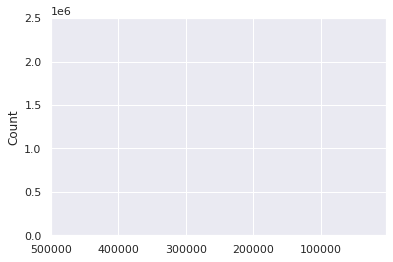

In [286]:
sns.histplot(pdm.back_transform(fulltrain).reshape(-1))
plt.xlim(0.5e6,3000)
#plt.ylim(0,0.5)
plt.show()

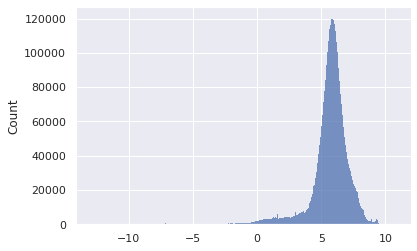

In [280]:
sns.histplot(logdata.reshape(-1))
plt.show()

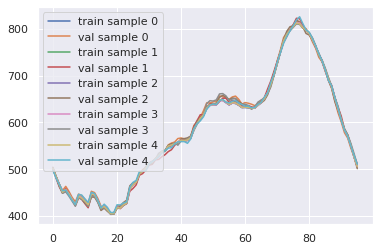

In [ ]:
from torch.utils.data import random_split

#plt.figure()
for i in range(5):
    length_train = int(len(fulltrain) * 0.9)
    length_val = len(fulltrain) - length_train
    train, val = random_split(fulltrain, [length_train, length_val])
    xnewtrain = torch.concat([x for x in train])
    xnewval = torch.concat([x for x in val])
    #plt.figure()
    plt.plot(pdm.back_transform(xnewtrain.mean(axis=0)), label=f"train sample {i}")
    plt.plot(pdm.back_transform(xnewval.mean(axis=0)), label=f"val sample {i}")
plt.legend()

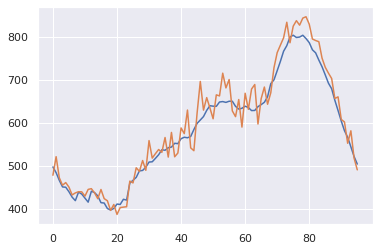

In [38]:
# Kernelsize 3
plt.figure()
idx = np.random.randint(0, len(xnewtrain), len(xgen))
plt.plot(pdm.back_transform(xnewtrain[idx].mean(axis=0)))
plt.plot(pdm.back_transform(xgen.reshape(-1,96).mean(axis=0)))
plt.show()

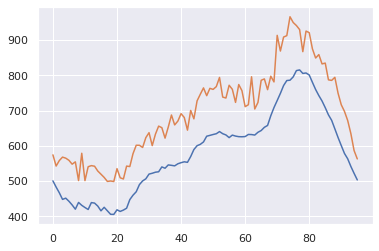

In [255]:
# Kernelsize 7
plt.figure()
idx = np.random.randint(0, len(xnewtrain), len(xgen))
plt.plot(pdm.back_transform(xnewtrain[idx].mean(axis=0)))
plt.plot(pdm.back_transform(xgen.reshape(-1,96).mean(axis=0)))
plt.show()

In [292]:
pdm22.data.columns.shape

(613,)

In [289]:
pdm.data.columns.shape

(619,)

In [47]:
xgen

tensor([[[0.0084, 0.0087, 0.0070,  ..., 0.0082, 0.0061, 0.0051]],

        [[0.0039, 0.0048, 0.0031,  ..., 0.0058, 0.0050, 0.0045]],

        [[0.0115, 0.0112, 0.0127,  ..., 0.0089, 0.0070, 0.0061]],

        ...,

        [[0.0165, 0.0165, 0.0159,  ..., 0.0232, 0.0191, 0.0176]],

        [[0.0047, 0.0058, 0.0044,  ..., 0.0042, 0.0037, 0.0027]],

        [[0.0082, 0.0075, 0.0070,  ..., 0.0064, 0.0086, 0.0094]]])

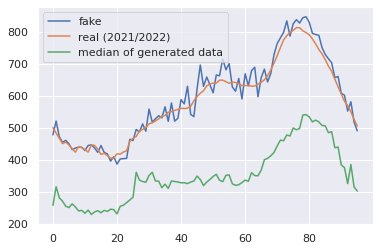

In [50]:
# Kernelsize 3
plt.plot(pdm.back_transform(xgen.reshape((xgen.shape[0], xgen.shape[-1]))).mean(axis=0), label="fake")
plt.plot(pdm.back_transform(xtrain.reshape((xtrain.shape[0], xtrain.shape[-1]))).mean(axis=0), label="real (2021/2022)")
plt.plot(pdm.back_transform(np.median(xgen.reshape(-1,96), axis=0)), label="median of generated data")
plt.legend()

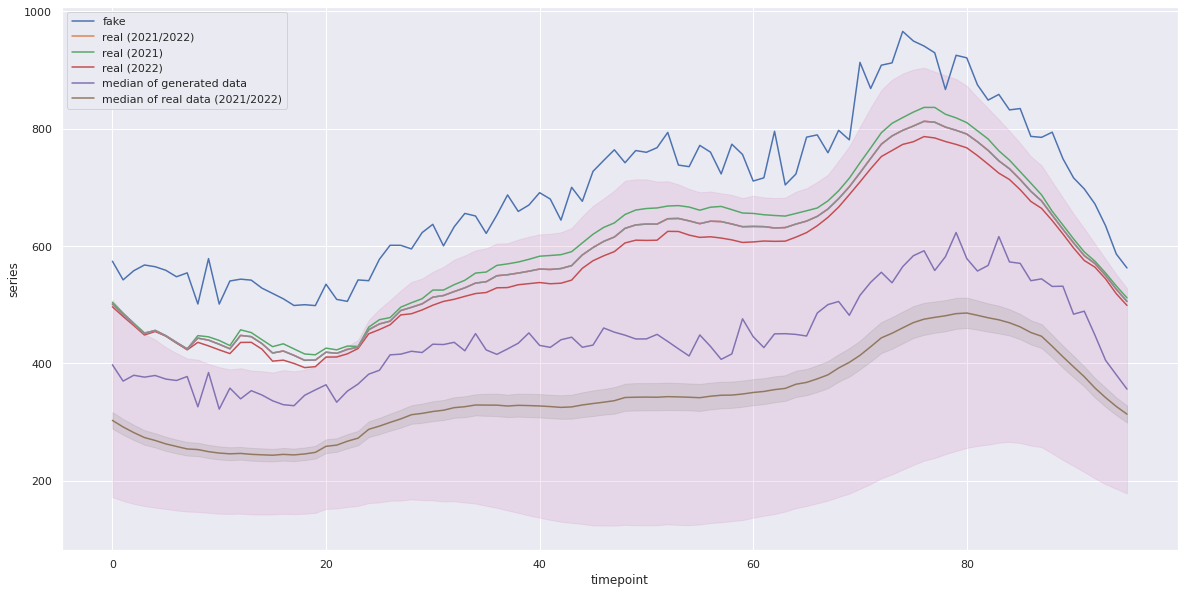

In [189]:
plt.figure(figsize=(20,10))
plt.plot(pdm.back_transform(xgen.reshape((xgen.shape[0], xgen.shape[-1]))).mean(axis=0), label="fake")
plt.plot(xtrain.reshape((xtrain.shape[0], xtrain.shape[-1])).mean(axis=0), label="real (2021/2022)")
plt.plot(xtrain21.reshape((xtrain21.shape[0], xtrain21.shape[-1])).mean(axis=0), label="real (2021)")
plt.plot(xtrain22.reshape((xtrain22.shape[0], xtrain22.shape[-1])).mean(axis=0), label="real (2022)")
plt.plot(pdm.back_transform(np.median(xgen.reshape(-1,96), axis=0)), label="median of generated data")
plt.plot(np.median(xtrain.reshape((xtrain.shape[0], xtrain.shape[-1])), axis=0), label="median of real data (2021/2022)")
sns.lineplot(data=dfreal, x="timepoint", y="series", errorbar=("pi", 50))
sns.lineplot(data=dfreal, x="timepoint", y="series", errorbar=("pi", 5))
#plt.plot(pdm.data.mean(axis=1)[:96].values, label="original first day")
plt.legend()
plt.show()

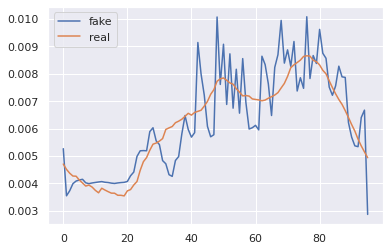

In [13]:
plt.figure()
plt.plot(xgen.reshape((xgen.shape[0], xgen.shape[-1])).mean(axis=0), label="fake")
plt.plot(xtrain.reshape((xtrain.shape[0], xtrain.shape[-1])).mean(axis=0), label="real")
#plt.plot(pdm.data.mean(axis=1)[:96].values, label="original first day")
plt.legend()
plt.show()

In [ ]:
pdm.back_transform(pdm.data.mean(axis=1)).rolling(700).mean().plot(title="Average Power consumption over time", ylabel="Average power consumption [W]")
#plt.savefig("./power_overtime.pdf")

In [64]:
plt.figure()
#plt.plot(xgen.reshape((xgen.shape[0], xgen.shape[-1])).mean(axis=0), label="fake")
plt.plot(xtrain.reshape((xtrain.shape[0], xtrain.shape[-1])).mean(axis=0), label="real")
plt.plot(pdm.data.mean(axis=1)[:96].values, label="original first day")
plt.legend()
plt.show()

NameError: name 'xtrain' is not defined

<Figure size 432x288 with 0 Axes>

In [16]:
xtrain.shape

torch.Size([33172, 1, 96])

In [17]:
# OpenMeter 2020
calculated_mmd = mmd(xtrain[:5000], xgen.reshape(xgen.shape[0], 1, xgen.shape[-1])[:5000])
calculated_mmd

tensor(0.0156, dtype=torch.float64)

In [ ]:
#WPUQ

In [33]:
calculated_mmd = mmd(xtrain, xgen.reshape(xgen.shape[0], 1, xgen.shape[-1]))
calculated_mmd

tensor(0.0056, dtype=torch.float64)

In [40]:
calculated_mmd = mmd(xtrain, xgen)
calculated_mmd

tensor(0.0057, dtype=torch.float64)

In [77]:
# MMD seems to be independent from data scaling
calculated_mmd = mmd(xtrain, xgen*100)
calculated_mmd

tensor(0.6697, dtype=torch.float64)

In [54]:
# MMD seems to be independent from data scaling
calculated_mmd = mmd(xtrain*100, xgen*100)
calculated_mmd

tensor(0.0056, dtype=torch.float64)

In [12]:
calculated_mmd = mmd(xtrain, xgen)
calculated_mmd

tensor(0.0430, dtype=torch.float64)

In [60]:
calculated_mmd = mmd(xtrain, pdm.data_test)
calculated_mmd

tensor(0.0421, dtype=torch.float64)

In [60]:
#OpenMeter 2021/2022
calculated_mmd = mmd(torch.tensor(xgen[:5000]), torch.tensor(xtrain[:5000]).reshape(-1,1,96))
calculated_mmd

/share/apps/anaconda/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor(0.0078, dtype=torch.float64)

../../syndatagenerators/models/utils/plot_functions.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.random.choice([x for x in data], n_rows*n_cols) if random_sample else data[:n_rows*n_cols]
../../syndatagenerators/models/utils/plot_functions.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.random.choice([x for x in data], n_rows*n_c

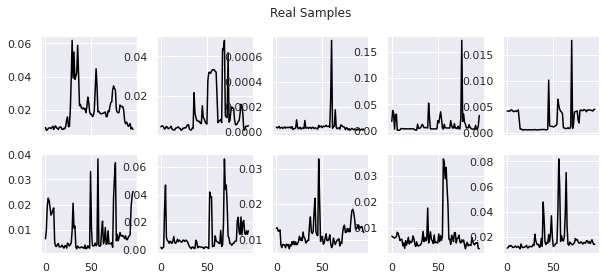

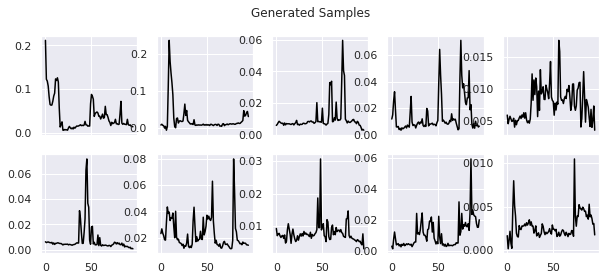

In [62]:
#OpenMeter 2021/2022
plot_sample_grid(torch.tensor(xtrain)[:], random_sample=True, title='Real Samples')
fig = plot_sample_grid(xgen, random_sample=True, title='Generated Samples')

../../syndatagenerators/models/utils/plot_functions.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.random.choice([x for x in data], n_rows*n_cols) if random_sample else data[:n_rows*n_cols]
../../syndatagenerators/models/utils/plot_functions.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.random.choice([x for x in data], n_rows*n_c

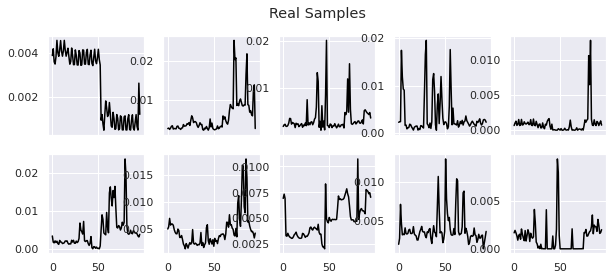

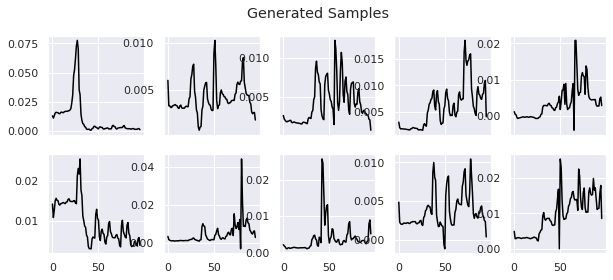

In [18]:
#OpenMeter 2020
plot_sample_grid(xtrain[:], random_sample=True, title='Real Samples')
fig = plot_sample_grid(xgen, random_sample=True, title='Generated Samples')

../../syndatagenerators/models/utils/plot_functions.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.random.choice([x for x in data], n_rows*n_cols) if random_sample else data[:n_rows*n_cols]


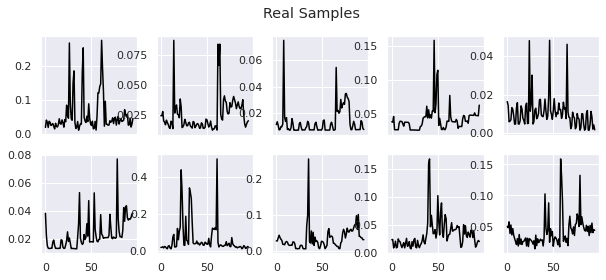

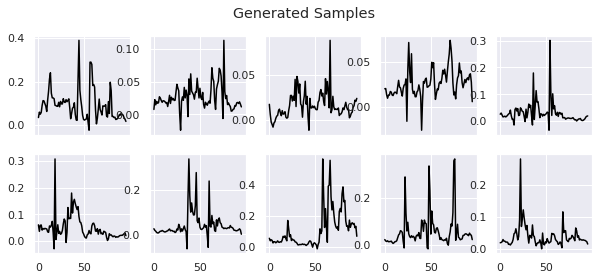

In [41]:
#WPUQ
plot_sample_grid(xtrain[:], random_sample=True, title='Real Samples')
fig = plot_sample_grid(xgen, random_sample=True, title='Generated Samples')

In [20]:
len(xgen)

21960

In [67]:
xtrain.shape

(332133, 96)

In [66]:
xgen.shape

torch.Size([21960, 1, 96])

In [96]:
len(xtrain)

332133

In [ ]:
tsne_plot = plot_TSNE(torch.tensor(xtrain.reshape(-1,1,96)), generate_synthetic_samples(model.generator, size=len(xtrain), clip=False), use_seaborn=True, alpha=0.1)

/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


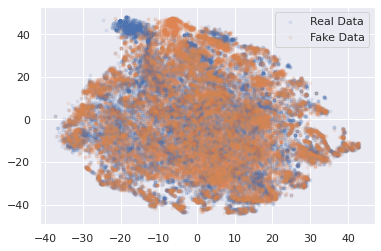

In [52]:
#OpenMeter 2021/2022 (Kernelsize 3)
from syndatagenerators.metrics.visualization import plot_TSNE
n_tsne_samples = min(len(xtrain), len(xgen))
tsne_plot = plot_TSNE(torch.tensor(xtrain[:n_tsne_samples].reshape(-1,1,96)), xgen[:n_tsne_samples], use_seaborn=True, alpha=0.1)

/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


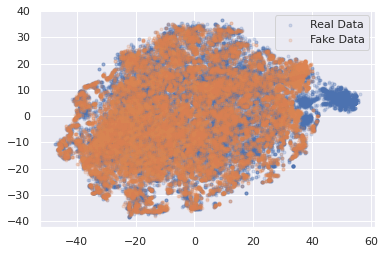

In [70]:
#OpenMeter 2021/2022 (Kernelsize 7)
from syndatagenerators.metrics.visualization import plot_TSNE
n_tsne_samples = min(len(xtrain), len(xgen))
tsne_plot = plot_TSNE(torch.tensor(xtrain[:n_tsne_samples].reshape(-1,1,96)), xgen[:n_tsne_samples], use_seaborn=True, alpha=0.2)

In [71]:
# OpenMeter 2020
from syndatagenerators.metrics.visualization import plot_TSNE
tsne_plot = plot_TSNE(xtrain[:len(xgen)], xgen, use_seaborn=True, alpha=0.1)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


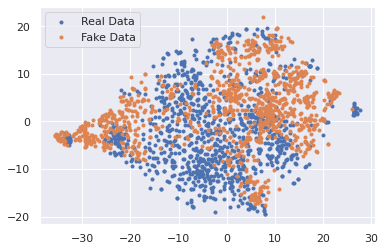

In [14]:
#WPUQ
from syndatagenerators.metrics.visualization import plot_TSNE
tsne_plot = plot_TSNE(xtrain, xgen[:xtrain.shape[0]], use_seaborn=True)

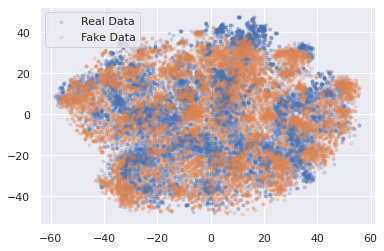

In [43]:
from syndatagenerators.metrics.visualization import plot_TSNE
tsne_plot = plot_TSNE(xtrain, xgen[:xtrain.shape[0]], use_seaborn=True, alpha=0.2)

In [101]:
# Zeitumstellung auf Sommerzeit (um 2 Uhr auf 3 Uhr) -> Stunde von 2 bis 3 Uhr fehlt (korrekterweise)
pdm.data["2020-03-29 0:00:00":"2020-03-29 23:59:00"].index

DatetimeIndex(['2020-03-29 00:00:00', '2020-03-29 00:15:00',
               '2020-03-29 00:30:00', '2020-03-29 00:45:00',
               '2020-03-29 01:00:00', '2020-03-29 01:15:00',
               '2020-03-29 01:30:00', '2020-03-29 01:45:00',
               '2020-03-29 03:00:00', '2020-03-29 03:15:00',
               '2020-03-29 03:30:00', '2020-03-29 03:45:00',
               '2020-03-29 04:00:00', '2020-03-29 04:15:00',
               '2020-03-29 04:30:00', '2020-03-29 04:45:00',
               '2020-03-29 05:00:00', '2020-03-29 05:15:00',
               '2020-03-29 05:30:00', '2020-03-29 05:45:00',
               '2020-03-29 06:00:00', '2020-03-29 06:15:00',
               '2020-03-29 06:30:00', '2020-03-29 06:45:00',
               '2020-03-29 07:00:00', '2020-03-29 07:15:00',
               '2020-03-29 07:30:00', '2020-03-29 07:45:00',
               '2020-03-29 08:00:00', '2020-03-29 08:15:00',
               '2020-03-29 08:30:00', '2020-03-29 08:45:00',
               '2020-03-

In [99]:
# Zeitumstellung auf Winterzeit -> Zusätzliche Stunde in den Daten fehlt/wird vermutlich überschrieben (sollte nicht so sein)
pdm.data["2020-10-25 0:00:00":"2020-10-25 23:59:00"].index

DatetimeIndex(['2020-10-25 00:00:00', '2020-10-25 00:15:00',
               '2020-10-25 00:30:00', '2020-10-25 00:45:00',
               '2020-10-25 01:00:00', '2020-10-25 01:15:00',
               '2020-10-25 01:30:00', '2020-10-25 01:45:00',
               '2020-10-25 02:00:00', '2020-10-25 02:15:00',
               '2020-10-25 02:30:00', '2020-10-25 02:45:00',
               '2020-10-25 03:00:00', '2020-10-25 03:15:00',
               '2020-10-25 03:30:00', '2020-10-25 03:45:00',
               '2020-10-25 04:00:00', '2020-10-25 04:15:00',
               '2020-10-25 04:30:00', '2020-10-25 04:45:00',
               '2020-10-25 05:00:00', '2020-10-25 05:15:00',
               '2020-10-25 05:30:00', '2020-10-25 05:45:00',
               '2020-10-25 06:00:00', '2020-10-25 06:15:00',
               '2020-10-25 06:30:00', '2020-10-25 06:45:00',
               '2020-10-25 07:00:00', '2020-10-25 07:15:00',
               '2020-10-25 07:30:00', '2020-10-25 07:45:00',
               '2020-10-

In [108]:
idx = pd.date_range('2020-01-01 00:00:00', '2020-12-31 00:00:00', freq="15min")
df = pd.DataFrame(index=idx)
df["2020-10-25 0:00:00":"2020-10-25 23:59:00"].index

DatetimeIndex(['2020-10-25 00:00:00', '2020-10-25 00:15:00',
               '2020-10-25 00:30:00', '2020-10-25 00:45:00',
               '2020-10-25 01:00:00', '2020-10-25 01:15:00',
               '2020-10-25 01:30:00', '2020-10-25 01:45:00',
               '2020-10-25 02:00:00', '2020-10-25 02:15:00',
               '2020-10-25 02:30:00', '2020-10-25 02:45:00',
               '2020-10-25 03:00:00', '2020-10-25 03:15:00',
               '2020-10-25 03:30:00', '2020-10-25 03:45:00',
               '2020-10-25 04:00:00', '2020-10-25 04:15:00',
               '2020-10-25 04:30:00', '2020-10-25 04:45:00',
               '2020-10-25 05:00:00', '2020-10-25 05:15:00',
               '2020-10-25 05:30:00', '2020-10-25 05:45:00',
               '2020-10-25 06:00:00', '2020-10-25 06:15:00',
               '2020-10-25 06:30:00', '2020-10-25 06:45:00',
               '2020-10-25 07:00:00', '2020-10-25 07:15:00',
               '2020-10-25 07:30:00', '2020-10-25 07:45:00',
               '2020-10-